In [ ]:
# --- Importation des librairies (section ajoutée pour regrouper tous les imports) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# Importation des modules utilitaires
from utils.data_registry import DATASETS
from utils.benchmarks import get_models, get_unsupervised_models, get_supervised_advanced_models
from utils.data_loading import load_datasets
from utils.data_preprocessing import normalize_rendements_by_row, create_low_nan_dataset
from utils.feature_engineering import add_features, add_financial_features
from utils.experiment_runner import run_experiment, display_experiment_result, add_result
from utils.data_analysis import (
    analyze_distributions,
    compare_column_stats,
    analyze_normalization,
    compare_normalization_impact,
    perform_pca_analysis,
    analyze_correlations
)
from utils.feature_selection import (
    select_by_correlation,
    select_by_f_value,
    select_by_mutual_info,
    optimize_feature_count,
    find_important_features
)
from utils.model_interpretation import analyze_feature_importance, analyze_with_shap, plot_shap_summary
from utils.model_evaluation import optimize_hyperparameters, evaluate_model_performance, plot_confusion_matrix, create_results_summary

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from IPython.display import display
from tqdm import tqdm

# Create empty results tracker avec les colonnes améliorées
results_tracker = pd.DataFrame(columns=[
    "dataset", "dataset_description", "model", "model_description",
    "features_added", "feature_sets", "normalize_by_row", "accuracy", 
    "precision_weighted", "recall_weighted", "f1_weighted",
    "training_time", "prediction_time", "total_time", "notes"
])

# Prédiction de la direction des prix sur les marchés financiers

## 1. Introduction et présentation du problème


### 1.1 Contexte et enjeux

Dans le cadre de ce challenge (issu du Collège de France ou du Lab Banque de France), nous disposons de données de marché avec pour objectif de prédire la direction du prix (baisse, stable, hausse) en fin de journée, à partir des rendements du matin.
 
Ce marché américain étant particulièrement liquide, l'enjeu est de pouvoir estimer la tendance entre 14h et 16h pour prendre des décisions d'investissement ou d'arbitrage.


### 1.2 Description des données

- **Index des données**
  - Chaque ligne représente un jour donné et une action donnée (identifiants : `day` et `equity`).
  - Les colonnes `r0` à `r52` correspondent aux rendements (en points de base) toutes les 5 minutes entre 9h30 et 14h.

- **Variables explicatives**
  - Les 53 rendements (`r0, r1, …, r52`), éventuellement d'autres features dérivées.

- **Variable cible**
  - `reod` {-1, 0, 1} indiquant la tendance de l'actif entre 14h et 16h (baisse, stable ou hausse).



### 1.3 Problématique et défis

Notre mission est de prédire la classe de rendement (`reod`) en fin de journée, à partir des données matinales. Les défis principaux sont :

- La **taille importante** du dataset (plusieurs centaines de milliers de lignes).
- La **présence de valeurs manquantes** (`NaN`).
- L'**absence de jours/actions communs** entre le jeu d'entraînement et le jeu de test, ce qui complique l'utilisation directe de `equity` ou `day` en tant que features.
- Le **risque de surcoût mémoire** et de temps de calcul avec certains modèles comme les Random Forest.



## 2. Exploration des données (EDA)

### 2.1 Aperçu des données et analyse des valeurs manquantes

Nous commençons par explorer les données d'entraînement pour comprendre leur structure et la distribution des valeurs manquantes.


In [ ]:
# Importation des données d'entraînement
X = pd.read_csv('input_training.csv')
X.sort_values(by="ID", inplace=True)
y = pd.read_csv('output/output_training_gmEd6Zt.csv')

# Importation des données de test
data_test = pd.read_csv('input_test.csv')
data_test.sort_values(by="ID", inplace=True)
y_test = pd.read_csv("output/output_test_random.csv")

# Fusion des données et labels
X_train = pd.merge(X, y, on="ID").copy()
data_test.sort_values(by="ID", inplace=True)
X_test = pd.merge(data_test, y_test, on="ID").copy()

# Aperçu des données
print("\n--- Aperçu des données d'entraînement ---")
print(f"Nombre de lignes train: {X_train.shape[0]}, Nombre de colonnes: {X_train.shape[1]}")
print(f"Nombre de lignes test: {X_test.shape[0]}, Nombre de colonnes: {X_test.shape[1]}")
print("\nPremières lignes:")
X_train.head()


--- Aperçu des données d'entraînement ---
Nombre de lignes train: 843299, Nombre de colonnes: 57
Nombre de lignes test: 885799, Nombre de colonnes: 57

Premières lignes:


ID  day  equity      r0      r1     r2     r3     r4     r5     r6  ...  \
0   0  249    1488    0.00     NaN    NaN    NaN   0.00    NaN    NaN  ...   
1   1  272     107   -9.76    0.00 -12.21  46.44  34.08   0.00  41.24  ...   
2   2  323    1063   49.85    0.00   0.00 -26.64 -23.66 -22.14  49.12  ...   
3   3  302     513    0.00     NaN   0.00   0.00   0.00    NaN    NaN  ...   
4   4  123    1465 -123.84 -115.18 -26.44   0.00  42.42  10.56   0.00  ...   

     r44    r45    r46    r47   r48    r49    r50    r51    r52  reod  
0   0.00    NaN   0.00    NaN  0.00    NaN    NaN    NaN   0.00     0  
1 -16.92  -4.84   4.84   0.00  7.26  -9.68 -19.38   9.71  26.68     0  
2   1.59   6.37 -49.32  -9.59 -6.40  22.41  -6.39   7.99  15.96    -1  
3    NaN    NaN    NaN    NaN   NaN    NaN    NaN   0.00    NaN     0  
4 -21.44 -21.48  10.78 -21.55 -5.40 -10.81   5.41 -32.47  43.43    -1  

[5 rows x 57 columns]

#### Analyse des valeurs manquantes 

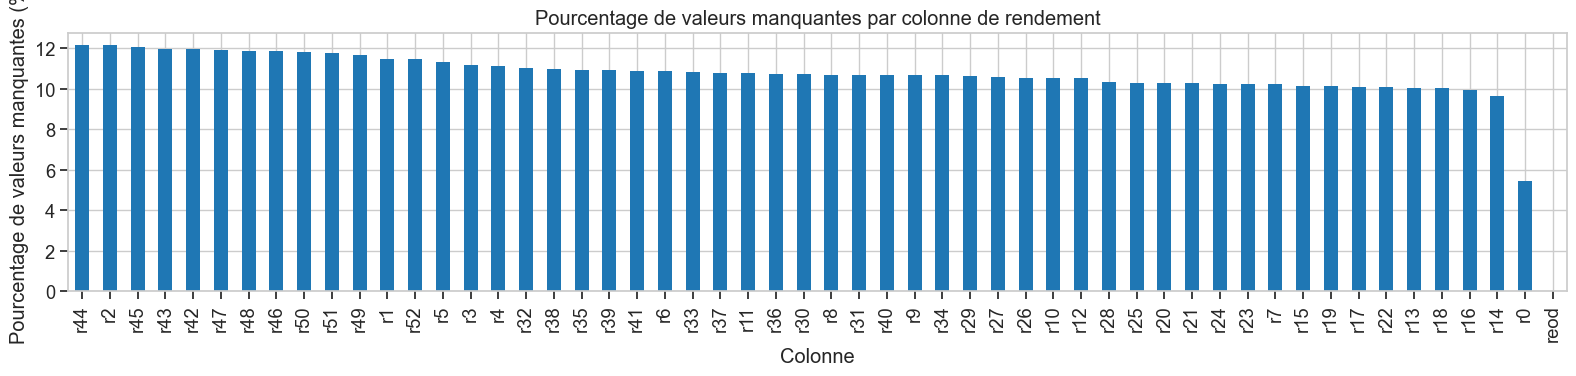

In [ ]:
col_rendements = [col for col in X_train.columns if col.startswith("r")]
# Analyse du nombre de valeurs manquantes par colonne
plt.figure(figsize=(16, 4))

missing_values_count = X_train[col_rendements].isna().sum()
missing_values_percent = (missing_values_count / len(X_train)) * 100
missing_df = pd.DataFrame({
    'Nombre de NaN': missing_values_count,
    'Pourcentage (%)': missing_values_percent
}).sort_values('Nombre de NaN', ascending=False)

ax = missing_df['Pourcentage (%)'].plot.bar()
plt.title('Pourcentage de valeurs manquantes par colonne de rendement')
plt.ylabel('Pourcentage de valeurs manquantes (%)')
plt.xlabel('Colonne')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

On observe que la majorité des colonnes contiennent en moyenne 10% de NaN. Le plus probable est que ce soit lié à des lignes majoritairement composées de NaN, probablement lié à une erreur lors de l'extraction des données. 

Nombre de lignes totales du dataset: 843299
Nombre de lignes contenant au moins un NaN: 242363, soit 28.74%
Nombre de lignes avec plus de 30% de NaN: 121123, soit 14.36%
Nombre de lignes avec plus de 50% de NaN: 77034, soit 9.13%


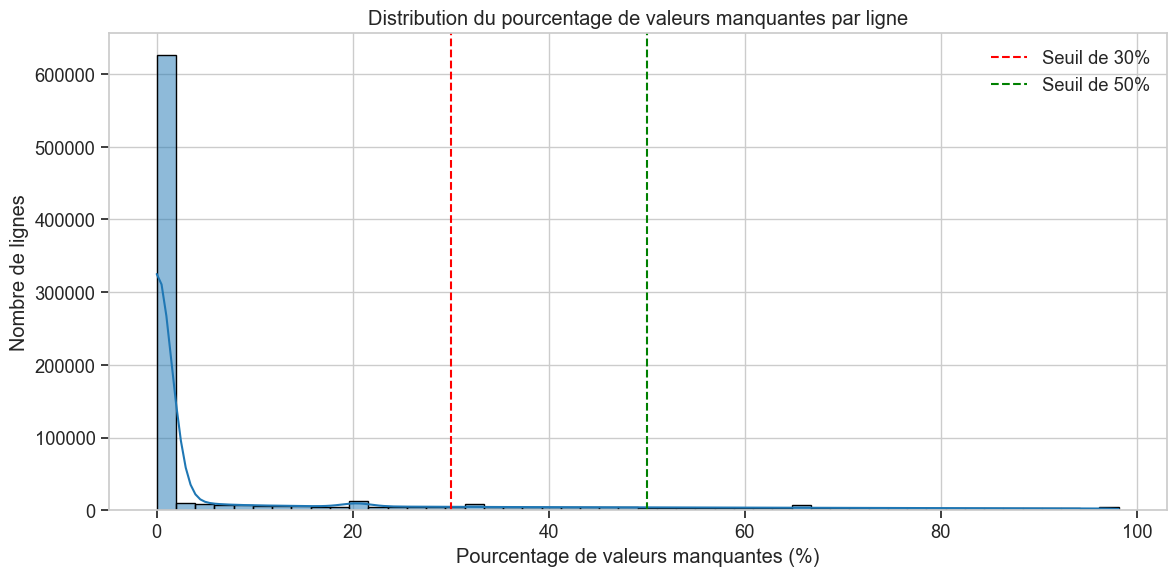

In [ ]:
# Analyse du nombre de valeurs manquantes par ligne
NaN_analysis = pd.DataFrame(index=X_train.index, columns=["NaN_count", "NaN_percent"])
NaN_analysis["NaN_count"] = X_train[col_rendements].isna().sum(axis=1)
nombre_colonnes_rend = len(col_rendements)
NaN_analysis["NaN_percent"] = (NaN_analysis["NaN_count"] / nombre_colonnes_rend) * 100

# Compter le nombre de lignes avec des NaN
nbr_row_na = X_train.isna().any(axis=1).sum()

print(f"Nombre de lignes totales du dataset: {len(X_train)}")
print(f"Nombre de lignes contenant au moins un NaN: {nbr_row_na}, soit {(nbr_row_na/len(X_train)*100):.2f}%")
print(f"Nombre de lignes avec plus de 30% de NaN: {len(NaN_analysis[NaN_analysis['NaN_percent']>30])}, soit {len(NaN_analysis[NaN_analysis['NaN_percent']>30])/len(X_train)*100:.2f}%")
print(f"Nombre de lignes avec plus de 50% de NaN: {len(NaN_analysis[NaN_analysis['NaN_percent']>50])}, soit {len(NaN_analysis[NaN_analysis['NaN_percent']>50])/len(X_train)*100:.2f}%")

plt.figure(figsize=(12, 6))
sns.histplot(NaN_analysis["NaN_percent"], bins=50, kde=True)
plt.title('Distribution du pourcentage de valeurs manquantes par ligne')
plt.xlabel('Pourcentage de valeurs manquantes (%)')
plt.ylabel('Nombre de lignes')
plt.axvline(x=30, color='r', linestyle='--', label='Seuil de 30%')
plt.axvline(x=50, color='g', linestyle='--', label='Seuil de 50%')
plt.legend()
plt.tight_layout()
plt.show()

On décide arbitrairement de retirer l'ensemble des lignes qui contiennent 30% de NaN (dans les colonnes rendements, donc day, equity, ID sont exclus) afin d'avoir un dataset potentiellement plus propre.

Fast Forward : Cette décision est également motivée par la répartition des classes "reod", composée majoritairement de 0 (environ 41%). On peut intellectualiser cela par le fait que les problèmes de données viennent des exchanges ou du marché résultant dans un marché peu mouvementé. On aurait donc un lien entre l'absence de mouvement dans les marchés et le problème de récupération des données. Potentiellement une fermeture de marché

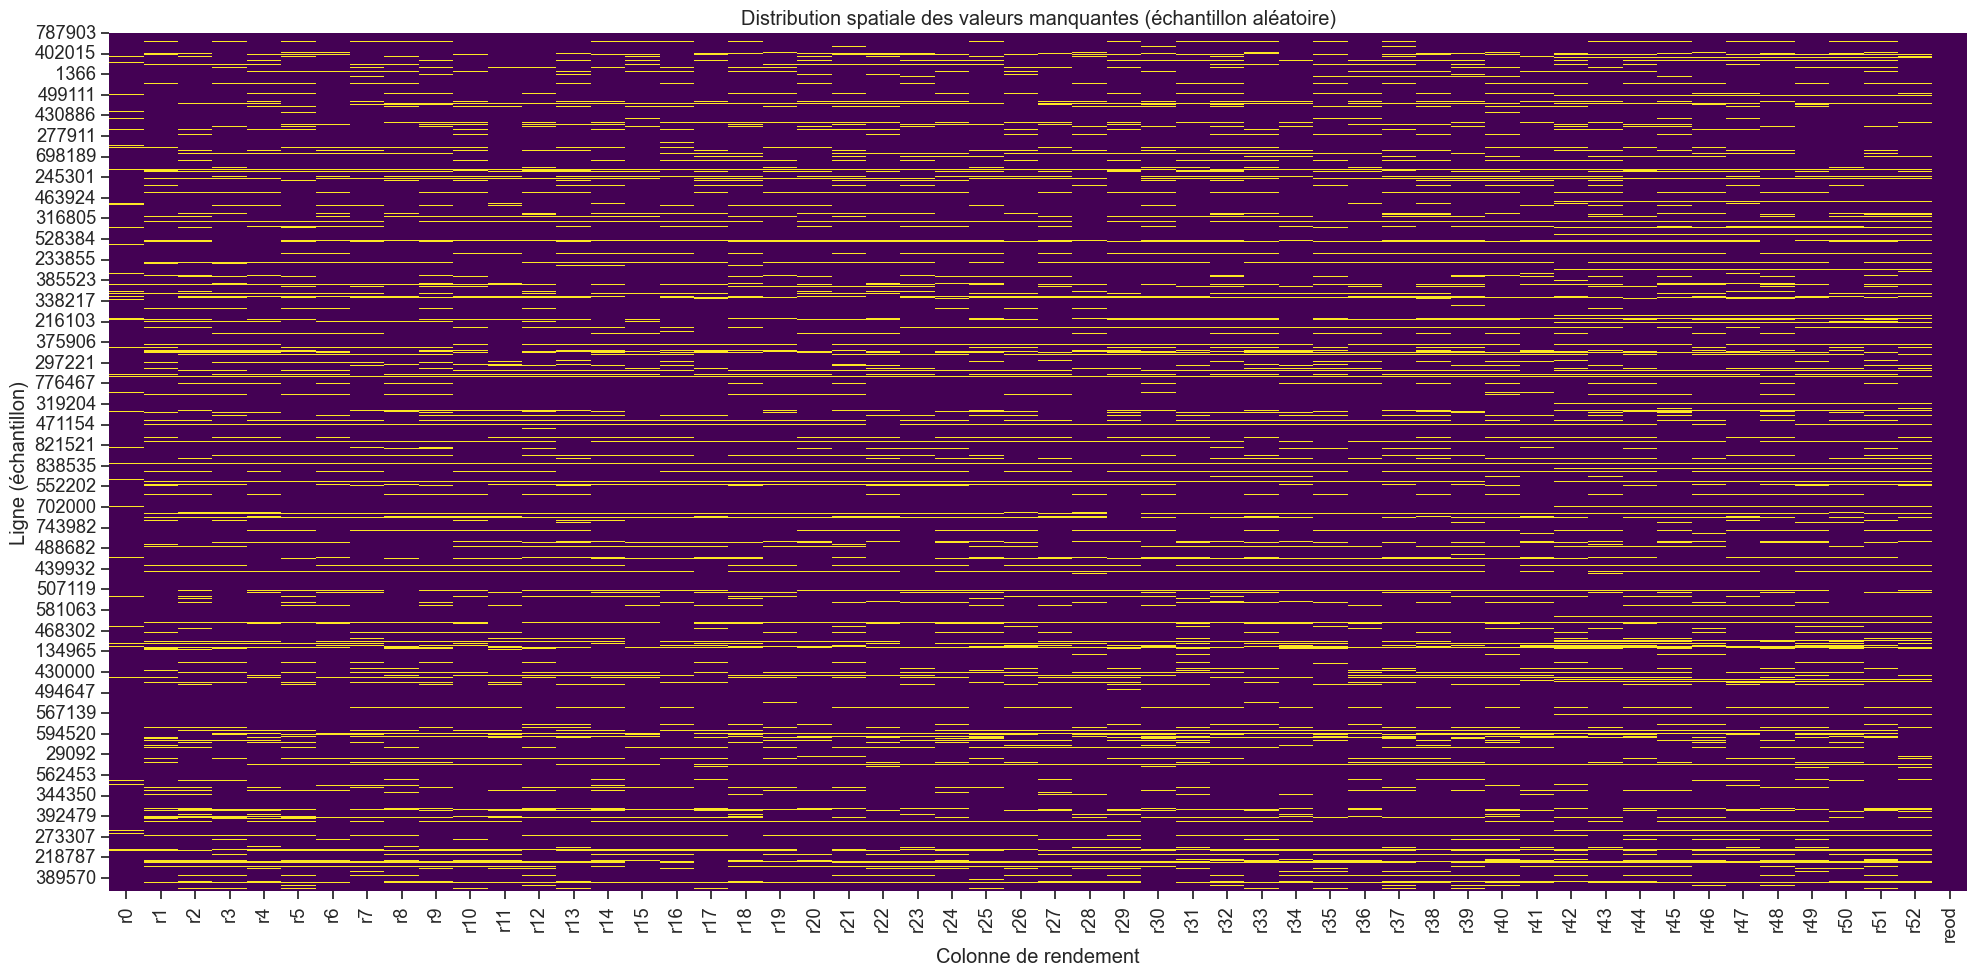

In [ ]:
# Distribution spatiale des NaN (heatmap)
plt.figure(figsize=(20, 10))
sample_size = min(1000, len(X_train))  # Limiter à 1000 lignes pour la lisibilité
sample_indices = np.random.choice(range(len(X_train)), sample_size, replace=False)
sample_data = X_train.iloc[sample_indices][col_rendements].isna()
sns.heatmap(sample_data, cbar=False, cmap='viridis')
plt.title('Distribution spatiale des valeurs manquantes (échantillon aléatoire)')
plt.xlabel('Colonne de rendement')
plt.ylabel('Ligne (échantillon)')
plt.tight_layout()
plt.show()

### 2.2 Distribution des rendements

Analysons la distribution des rendements pour identifier d'éventuelles caractéristiques ou anomalies.

In [ ]:
col_rendements.remove("reod")

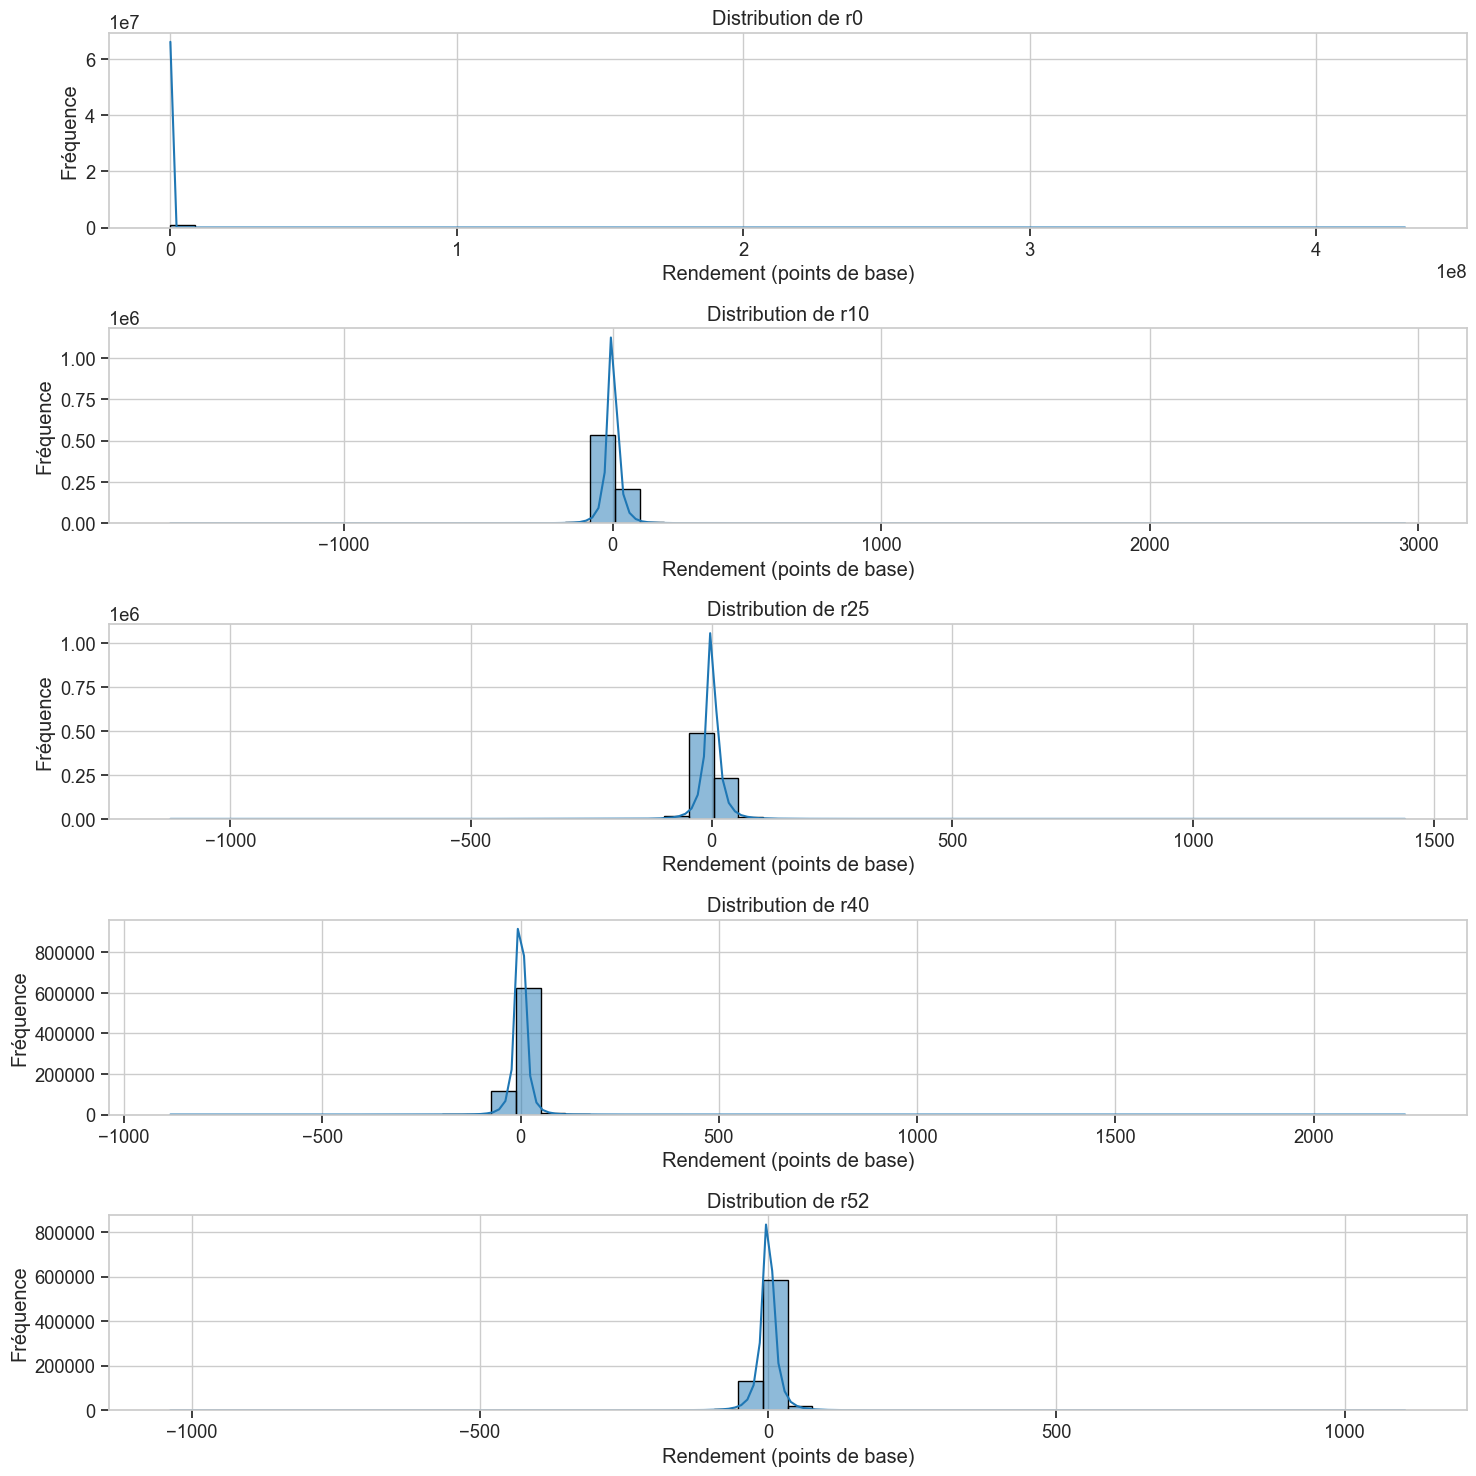

In [ ]:
# Affichage de la distribution pour quelques rendements représentatifs
sample_cols = ['r0', 'r1', 'r2', 'r3','r4', 'r5','r6', 'r10', 'r25', 'r40','r50','r51', 'r52']
plt.figure(figsize=(15, 15))

for i, col in enumerate(sample_cols):
    plt.subplot(len(sample_cols), 1, i+1)
    sns.histplot(X_train[col].dropna(), kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    plt.xlabel('Rendement (points de base)')
    plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

L'analyse de la distribution des rendements n'est venue qu'assez tard dans notre analyse des données. En effet, avant de se plonger dans la construction des modèles, nous avions un benchmark, le XGBoost. L'objectif était de retrouver dans un premier temps les résultats du benchmark du challenge. Ces tentatives d'amélioration sont passées par de nombreuses de transformations de données, dont certaines imputations que l'on retrouvera plus tard (forward fill, backward fill...) puis l'analyse de la normalité des données. Le StandardScaler() de scikit learn s'effectuant sur les colonnes, il fallait d'abord regarder comment se comportaient certaines colonnes. Nous nous pencherons sur cette analyse dans le focus sur le XGBoost (Partie 5).

Bien que les rendements ne suivent pas une loi normale, de toute évidence, il est important de noter que certains présentent de nombreuses valeurs extrêmes, notamment les rendements en début de journée (de r0 à r3) donc les 20 premières minutes qui présentent une moyenne très élevée et surtout de nombreuses valeurs extrêmes. 

In [ ]:
rendements_stats = X_train[col_rendements].describe().T
rendements_stats['missing_percent'] = X_train[col_rendements].isna().mean() * 100
rendements_stats = rendements_stats.sort_values('max', ascending=False)
rendements_stats.head(10)

count         mean            std      min    25%  50%    75%  \
r0   797476.0  1839.874545  609754.773378 -9967.67 -30.58  0.0  21.34   
r1   746484.0   193.534369  115327.121385 -9973.54 -21.10  0.0  20.71   
r2   740829.0    70.113991   55888.225790 -4823.74 -17.60  0.0  16.51   
r3   749130.0    19.564481   17850.550113 -1949.69 -17.47  0.0  15.17   
r28  756012.0    -0.270700      24.155237 -1219.51  -7.43  0.0   6.91   
r31  753271.0    -0.098791      23.342380 -1131.26  -6.66  0.0   6.54   
r15  757907.0    -0.625162      29.575757 -1290.32 -10.18  0.0   8.68   
r10  754488.0     0.372729      33.535457 -1647.06 -10.15  0.0  10.76   
r7   757167.0    -1.195195      38.327389 -2066.67 -13.76  0.0  11.44   
r9   753369.0     0.405408      34.341933 -1390.42 -10.34  0.0  11.25   

              max  missing_percent  
r0   4.310700e+08         5.433779  
r1   7.516000e+07        11.480507  
r2   4.789000e+07        12.151088  
r3   1.545000e+07        11.166739  
r28  3.217820e+03        10.350659  
r31  3.114750e+03        10.675692  
r15  3.076920e+03        10.125946  
r10  2.951810e+03        10.531377  
r7   2.733810e+03        10.213696  
r9   2.462310e+03        10.664071

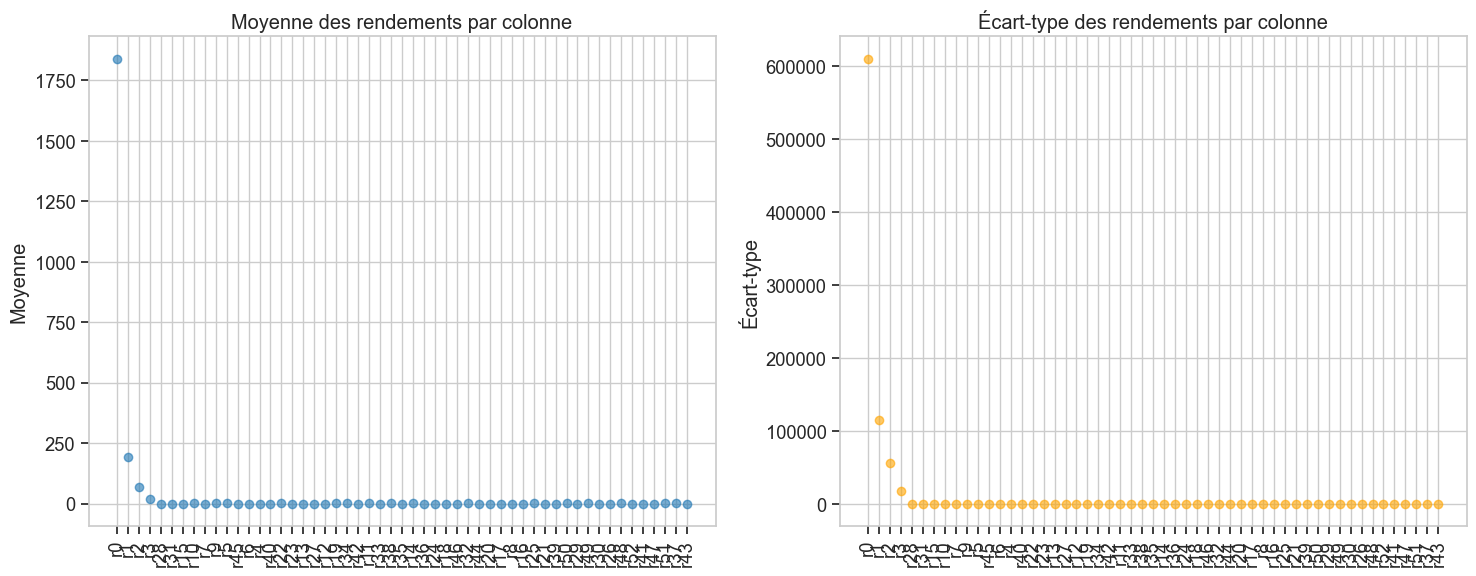

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(rendements_stats.index, rendements_stats['mean'], alpha=0.6)
plt.title('Moyenne des rendements par colonne')
plt.xticks(rotation=90)
plt.ylabel('Moyenne')

plt.subplot(1, 2, 2)
plt.scatter(rendements_stats.index, rendements_stats['std'], alpha=0.6, color='orange')
plt.title('Écart-type des rendements par colonne')
plt.xticks(rotation=90)
plt.ylabel('Écart-type')
plt.tight_layout()
plt.show()

### 2.3 Analyse de la variable cible

Examinons la distribution de notre variable cible `reod` pour vérifier l'équilibre entre les classes.

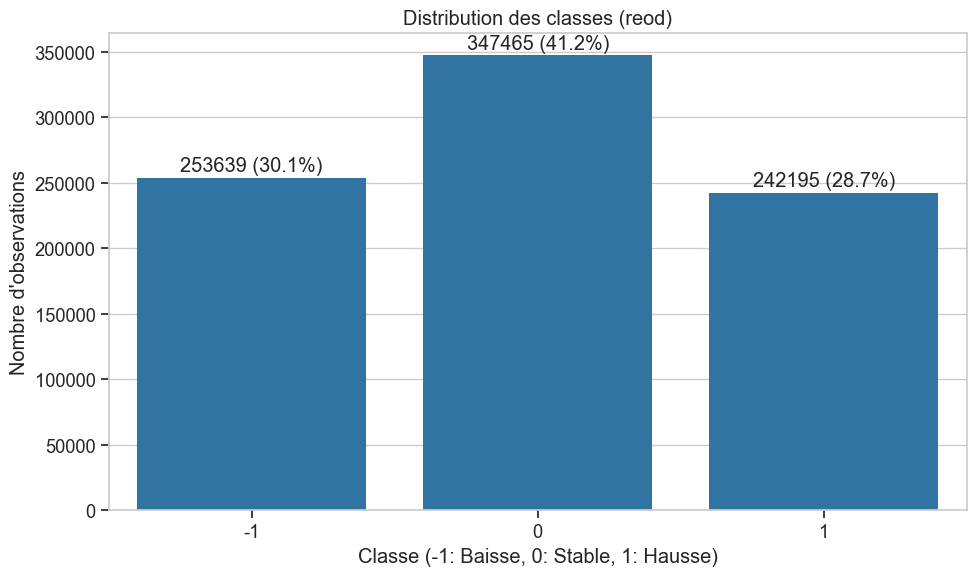

In [ ]:
# Distribution des classes
plt.figure(figsize=(10, 6))

class_counts = X_train['reod'].value_counts().sort_index()
ax = sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title('Distribution des classes (reod)')
plt.xlabel('Classe (-1: Baisse, 0: Stable, 1: Hausse)')
plt.ylabel('Nombre d\'observations')

total = len(X_train)
for i, v in enumerate(class_counts):
    ax.text(i, v + 5000, f'{v} ({v/total*100:.1f}%)', ha='center')
    
plt.tight_layout()
plt.show()

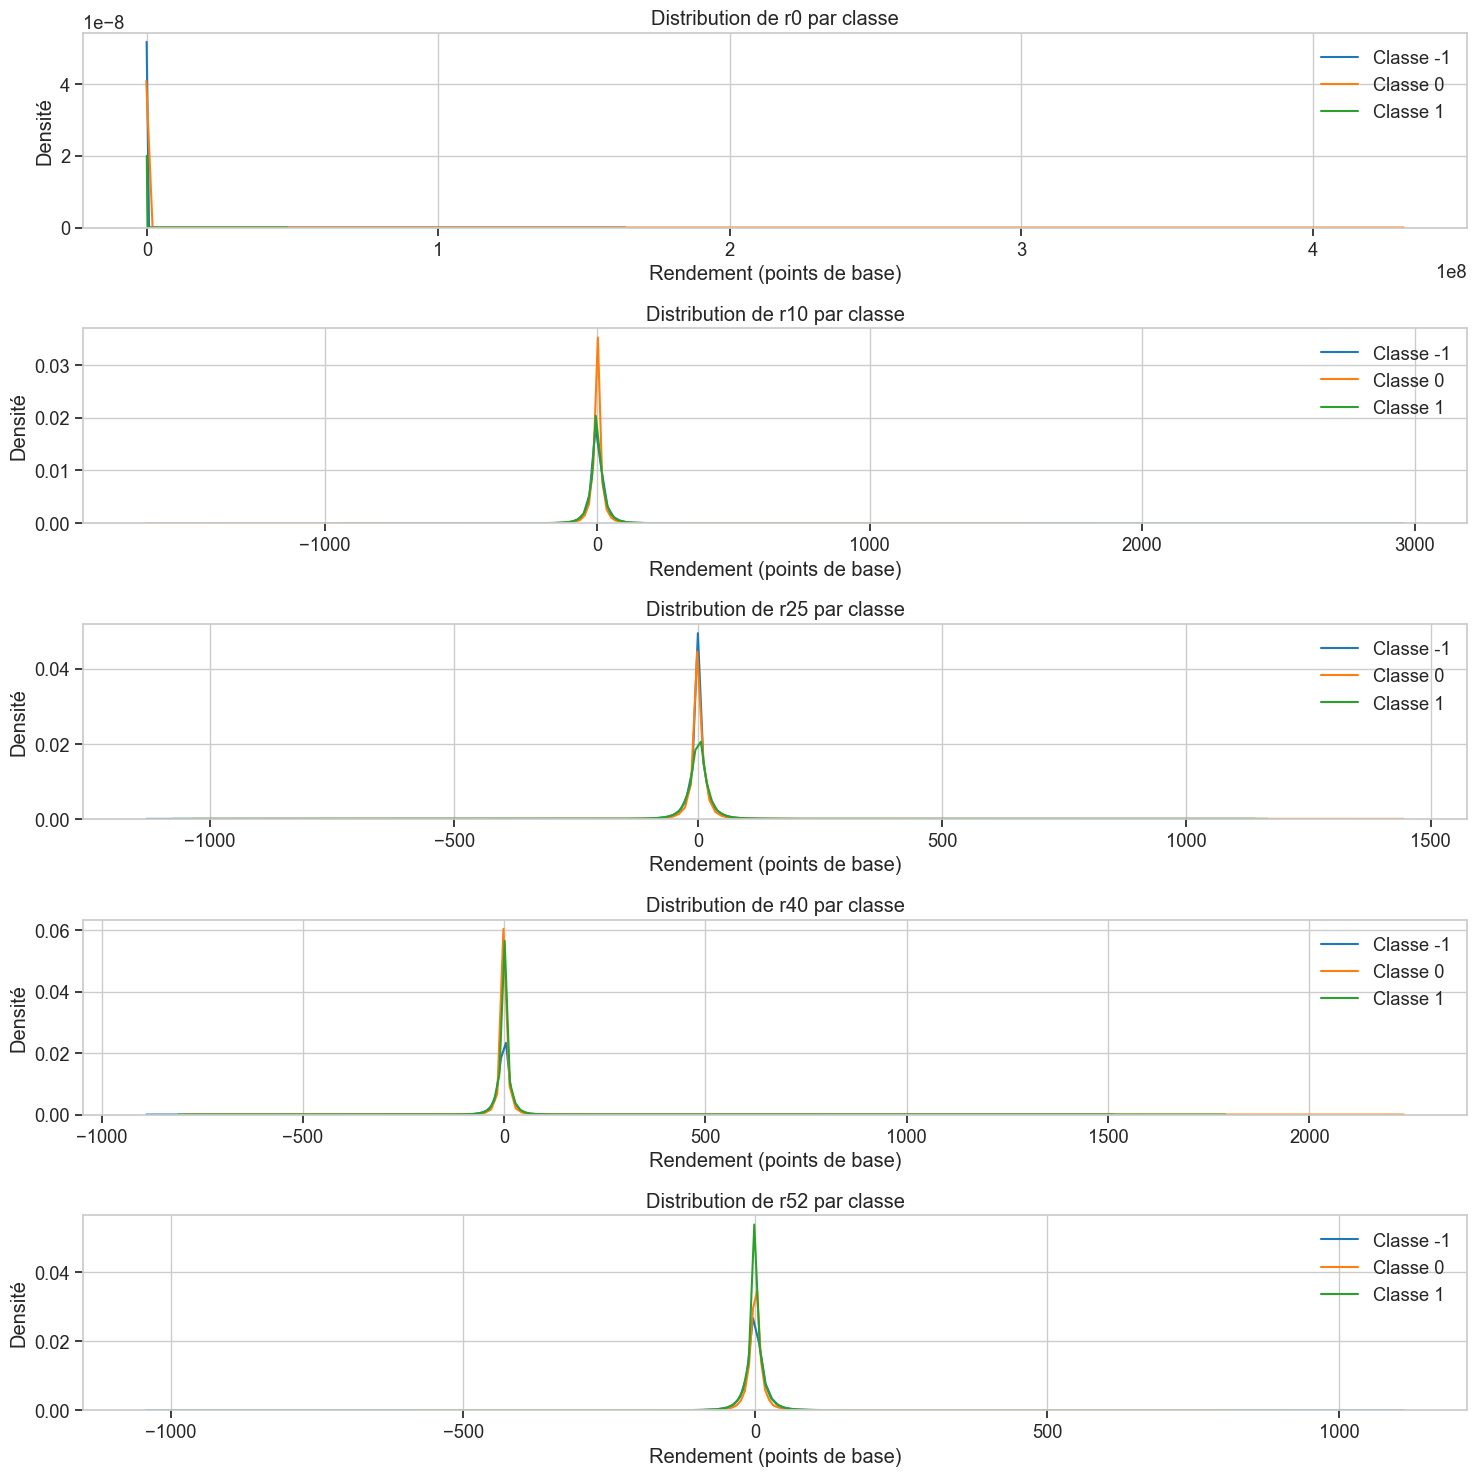

In [ ]:
# Analyse des rendements par classe pour quelques variables représentatives
plt.figure(figsize=(15, 15))

for i, col in enumerate(sample_cols):
    plt.subplot(len(sample_cols), 1, i+1)
    for cls in sorted(X_train['reod'].unique()):
        subset = X_train[X_train['reod'] == cls][col].dropna()
        sns.kdeplot(subset, label=f'Classe {cls}')
    plt.title(f'Distribution de {col} par classe')
    plt.xlabel('Rendement (points de base)')
    plt.ylabel('Densité')
    plt.legend()
    
plt.tight_layout()
plt.show()

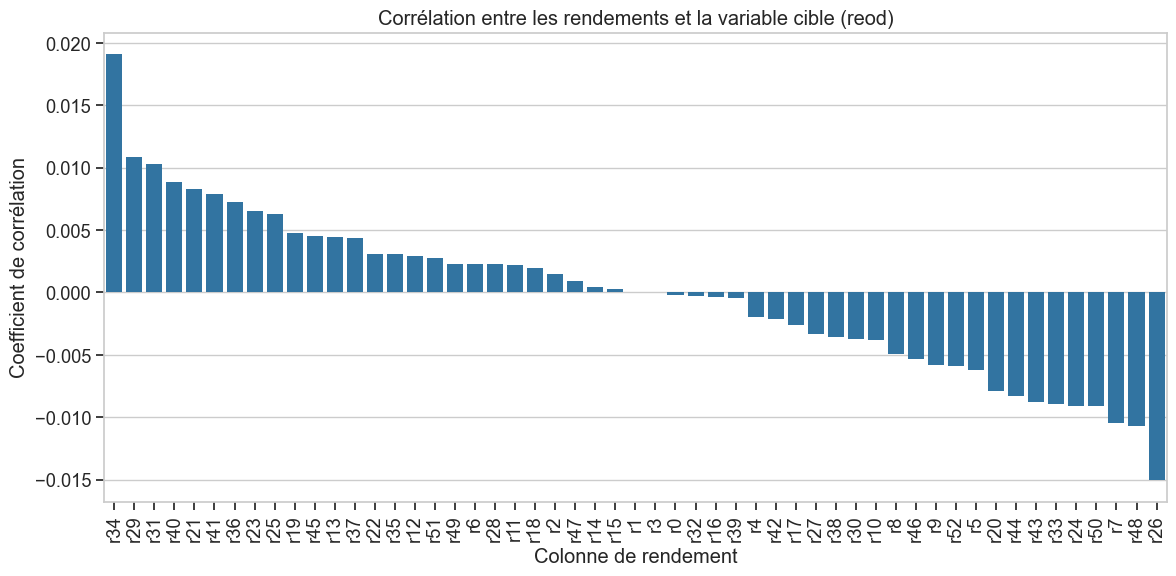

Top 5 des rendements positivement corrélés avec reod:


r34    0.019112
r29    0.010815
r31    0.010292
r40    0.008857
r21    0.008309
Name: reod, dtype: float64


Top 5 des rendements négativement corrélés avec reod:


r24   -0.009070
r50   -0.009138
r7    -0.010481
r48   -0.010694
r26   -0.015045
Name: reod, dtype: float64

In [ ]:
# Corrélation entre les rendements et la variable cible
correlations = X_train[col_rendements + ['reod']].corr()['reod'].drop('reod').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Corrélation entre les rendements et la variable cible (reod)')
plt.xticks(rotation=90)
plt.xlabel('Colonne de rendement')
plt.ylabel('Coefficient de corrélation')
plt.tight_layout()
plt.show()

print("Top 5 des rendements positivement corrélés avec reod:")
display(correlations.head())

print("\nTop 5 des rendements négativement corrélés avec reod:")
display(correlations.tail())

# 3. Stratégies d'imputation

Face au défi des valeurs manquantes, nous testons plusieurs stratégies d'imputation pour compléter les données. Ces données ont été générée en amont dans le fichier : KNN_data.ipynb pour des raisons pratiques et de présentation.

- 1 :  Forward-fill puis backward-fill (FFBF)

Cette stratégie propage d'abord les dernières valeurs connues vers l'avant, puis remplit les valeurs restantes en propageant depuis la fin. C'est supposément la méthode d'imputation classique pour ce genre de cas avec l'interpolation linéaire.

- 2 : Backward-fill puis forward-fill (BFFF)

Cette stratégie inverse commence par propager depuis la fin, puis remplit les valeurs restantes en propageant depuis le début. Cette méthode peut introduire un biais de looking forward mais dans les faits, on remarquera que la différence est très faible avec le FFBF.

- 3 : Interpolation linéaire

Cette méthode crée une ligne droite entre les valeurs connues pour estimer les valeurs manquantes.

- 4 : Imputation par K plus proches voisins (KNN)

Cette méthode utilise les K observations les plus similaires pour estimer les valeurs manquantes.

- 5 : MICE (Multiple Imputation by Chained Equations) est une méthode itérative qui modélise chaque variable contenant des valeurs manquantes en fonction des autres variables du jeu de données, en répétant ce processus plusieurs fois pour affiner les imputations et générer des estimations cohérentes et réalistes.

Chacune de ces méthodes est appliquée en première. Ensuite, pour chacune, nous appliquons un forward puis un backward fill s'il reste des NaN. L'ensemble de ces fonctions peuvent être trouvées dans data_preprocessing.py. 


Egalement, l'ensemble des données, chemin d'accès à ces données sont dans une variable globale DATASETS dans data_registry 

### 3.1 Chargement des datasets avec les différentes stratégies d'imputation. 

In [ ]:
print("\n--- Chargement des datasets avec différentes stratégies d'imputation ---")
imputed_datasets = load_datasets()


--- Chargement des datasets avec différentes stratégies d'imputation ---

Chargement du dataset raw...
Temps de chargement: 9.95 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 969666, test: 512130

Distribution des classes dans le dataset d'entraînement:
  Classe 0: 36.55%
  Classe -1: 32.42%
  Classe 1: 31.03%

Chargement du dataset ffbf...
Temps de chargement: 10.29 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 0, test: 0

Distribution des classes dans le dataset d'entraînement:
  Classe 0: 36.55%
  Classe -1: 32.42%
  Classe 1: 31.03%

Chargement du dataset bfff...
Temps de chargement: 7.21 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 0, test: 0

Distribution des classes dans le dataset d'entraînement:
  Classe 0: 36.55%
  Classe -1: 32.42%
  Classe 1: 31.03%

Chargement du dataset interp...
Temps de chargement: 7.17 secondes
Dimensions train: (730784, 57), 

In [ ]:
print("\n--- Création d'un dataset avec moins de 30% de valeurs manquantes ---")

# Charger les données brutes pour appliquer le filtrage
X_train_70 = pd.read_csv(r"processed_data\X_train_70.csv")
X_test_70 = pd.read_csv(r"processed_data\X_test_70.csv")

# Créer un dataset filtré (<30% NaN) avec imputation à zéro
X_train_low_nan, X_test_low_nan = create_low_nan_dataset(X_train_70, X_test_70, threshold=0.3)

# Enregistrer les datasets pour pouvoir les utiliser avec run_experiment
X_train_low_nan.to_csv("processed_data/X_train_low_nan.csv", index=False)
X_test_low_nan.to_csv("processed_data/X_test_low_nan.csv", index=False)

# Ajouter au registre des datasets
from utils.data_registry import add_dataset_with_features
add_dataset_with_features("low_nan", 
                        "processed_data/X_train_low_nan.csv", 
                        "processed_data/X_test_low_nan.csv", 
                        "Colonnes avec <30% de NaN, imputation à 0")


--- Création d'un dataset avec moins de 30% de valeurs manquantes ---
Nombre de colonnes de rendement conservées: 53 sur 53
Dimensions du dataset filtré: (730784, 57)


True

### 3.2  Analyse des distribution en fonction des imputations


--- Analyse des distributions après imputation ---


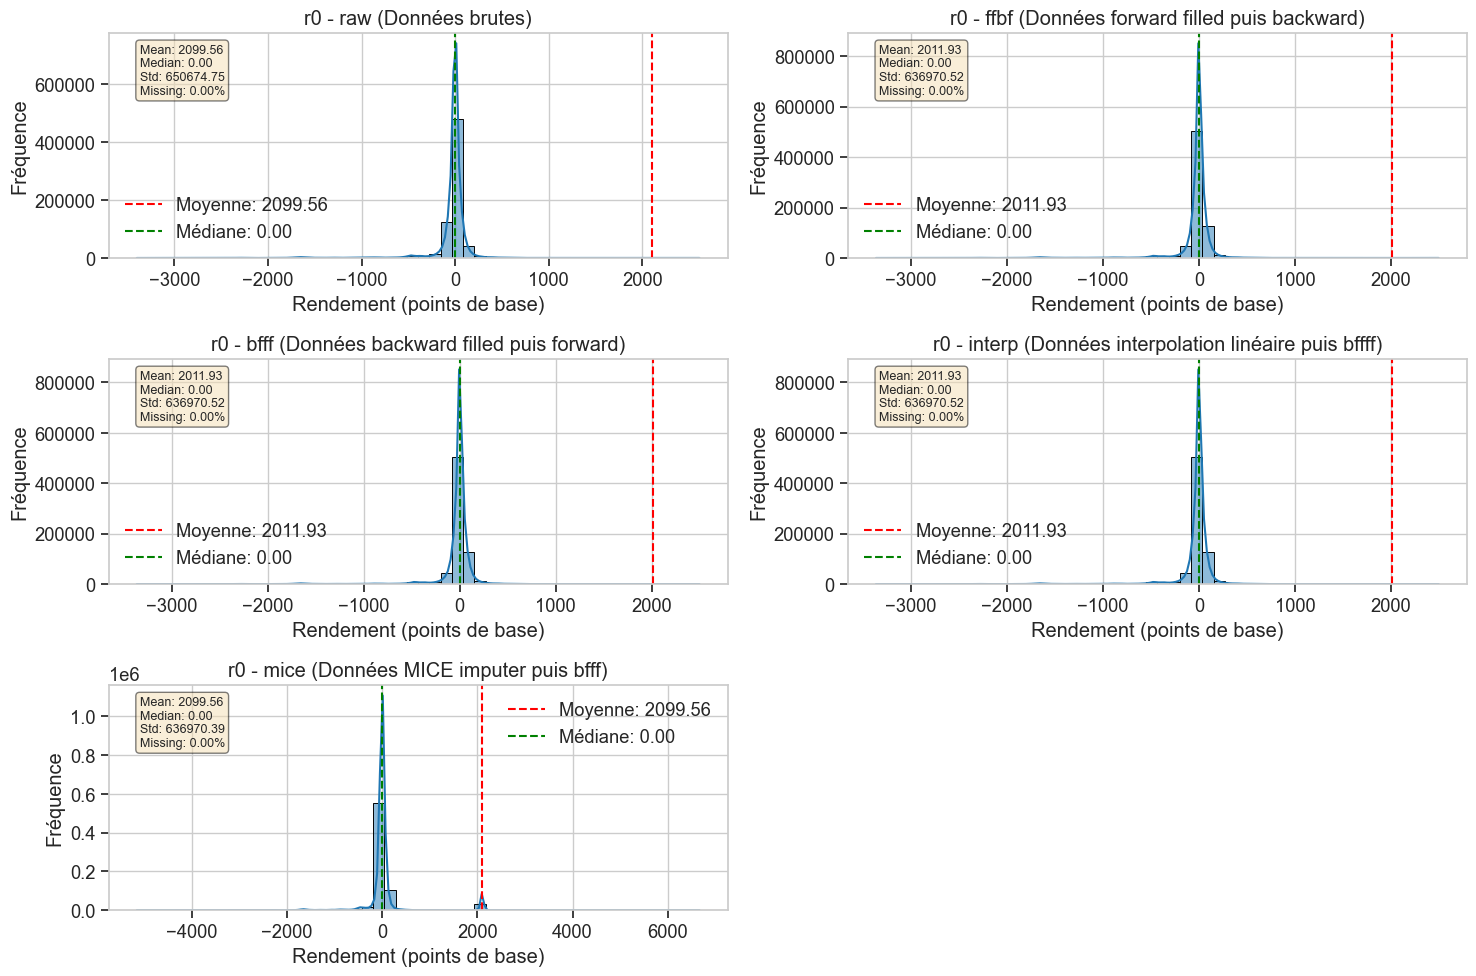

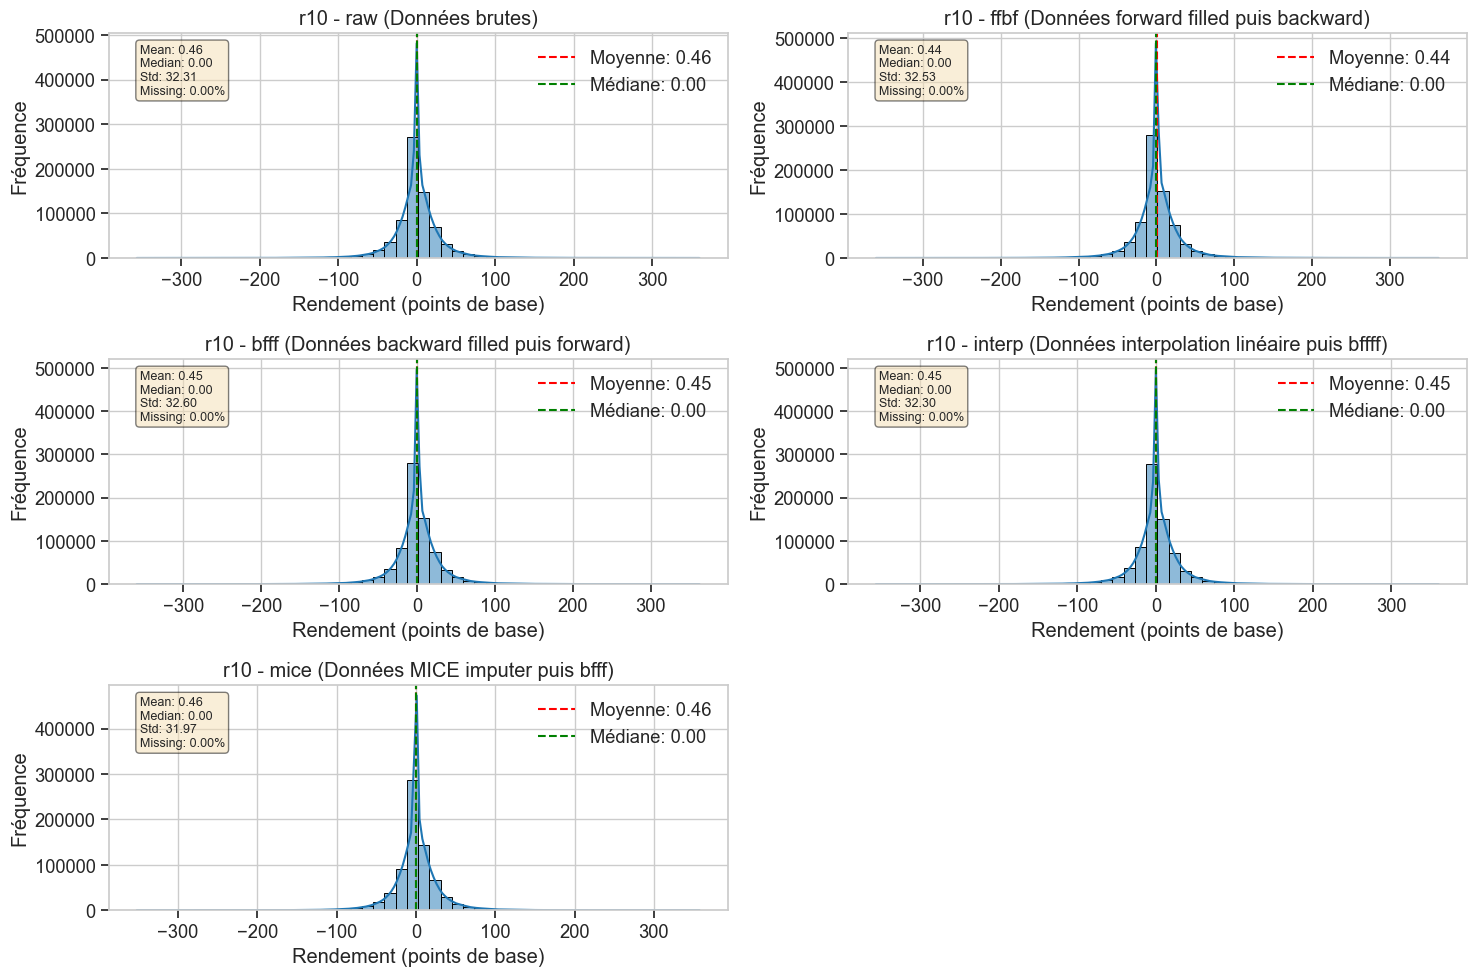

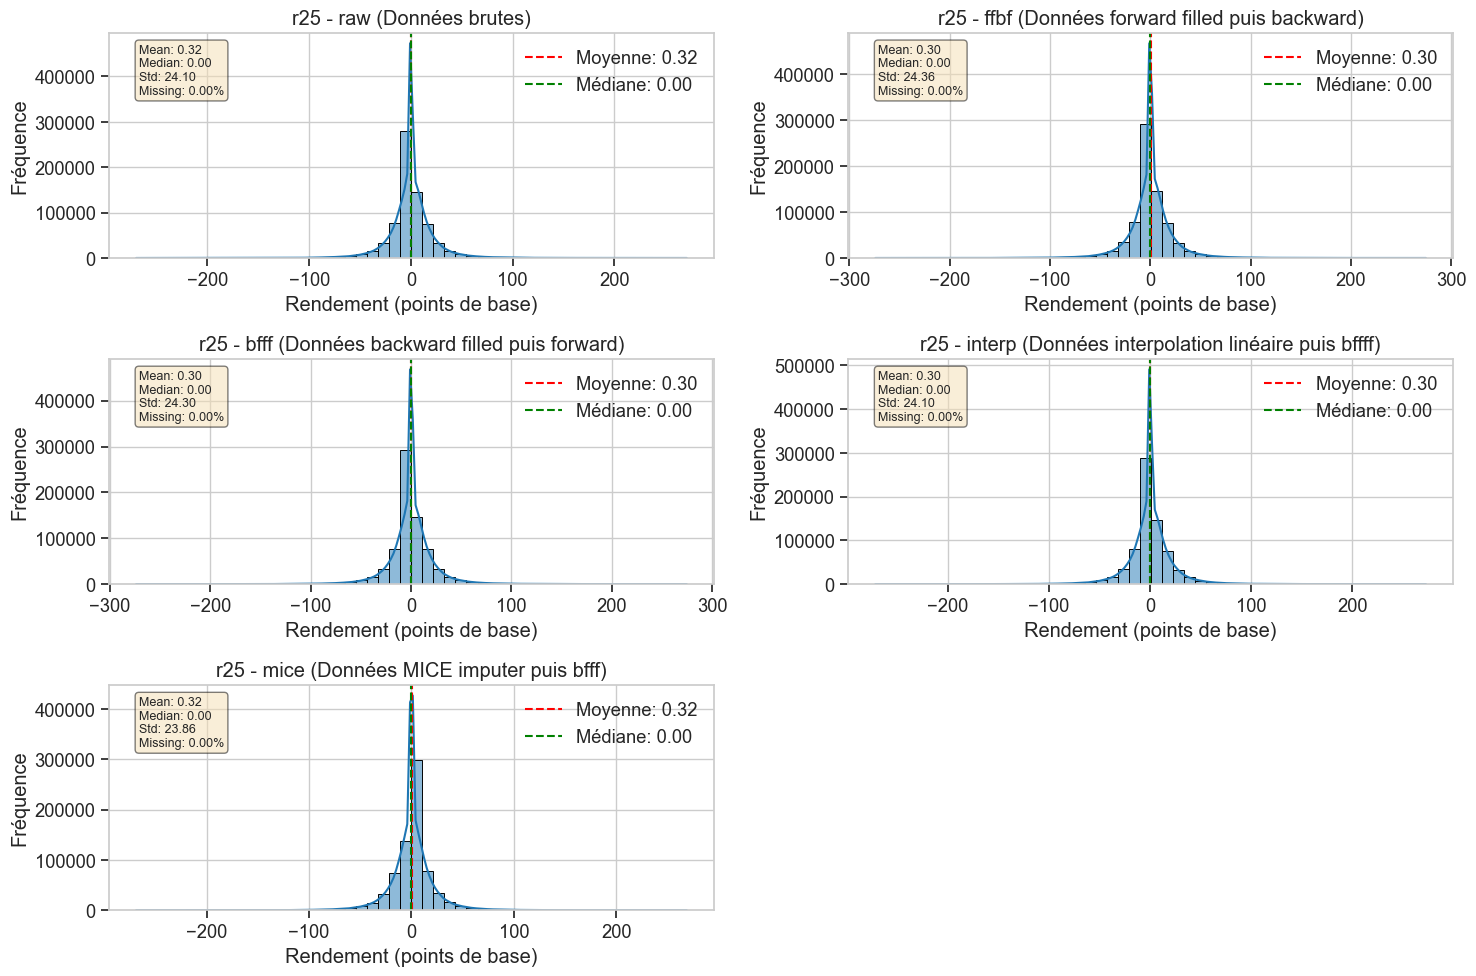

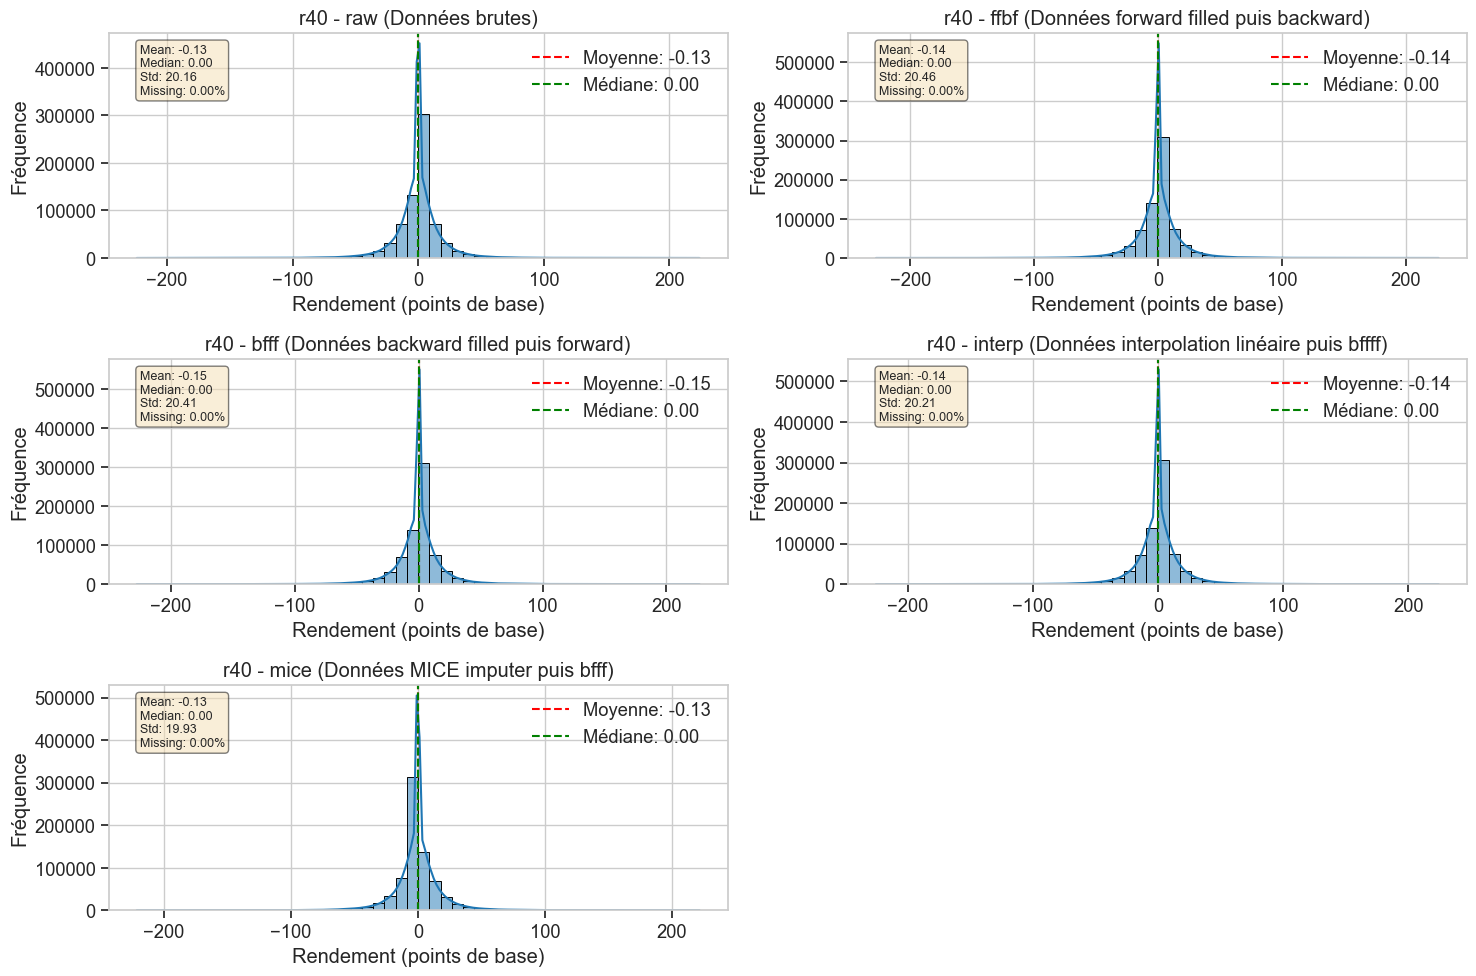

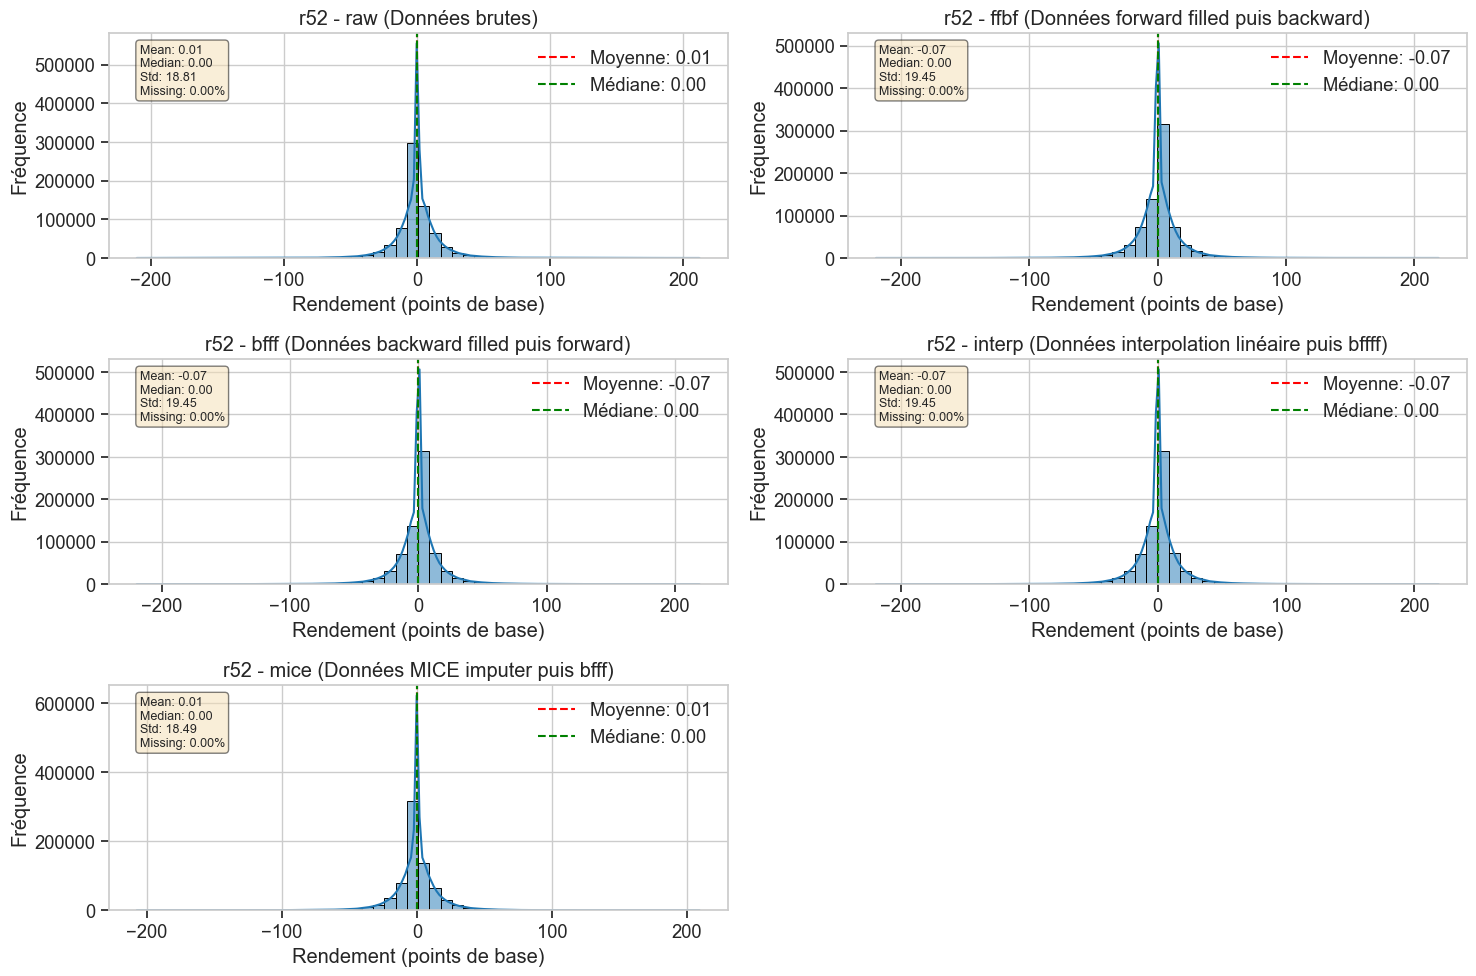

In [ ]:
print("\n--- Analyse des distributions après imputation ---")
analyze_distributions(imputed_datasets)

Les rendements suivent environ la même distribution, même les premiers rendements, cependant, on observe largement des queues de distributions plus longues impliquant des valeurs extrêmes. On essaiera de rectifier cela en essaynt plusieurs scaler par colonnes et en faisant également une normalisation par ligne. Cela permettra d'une certaine manière de modifier la distribution. Ne connaissant pas l'impact que cela puisse avoir, nous avons testés chaque cas. Les résultats étaient soient négligeables en fonction de scaler (Standard, MinMax, Quantile...) soit positifs pour la normalisation par ligne (légère amélioration pour les XGBoost) mais négligeable.

### 3.3 Comparaison des statistiques (moyenne / écart-type) par colonne et stratégie


--- Comparaison des statistiques entre les stratégies d'imputation ---


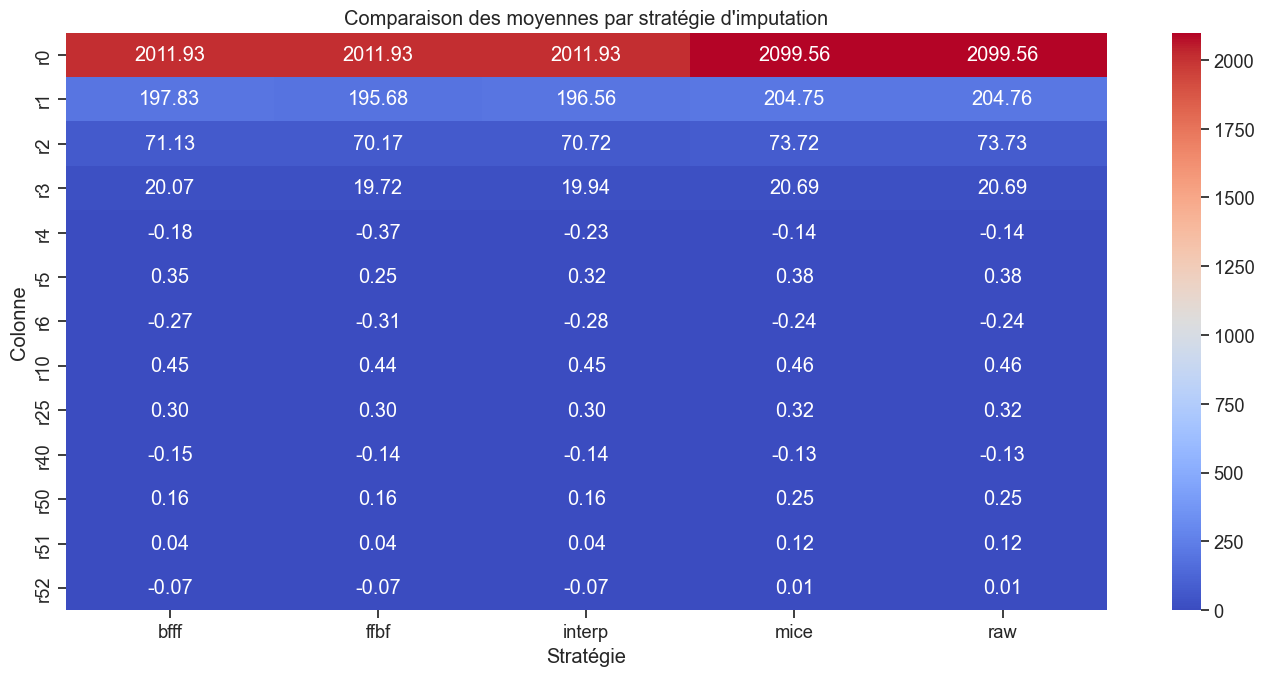

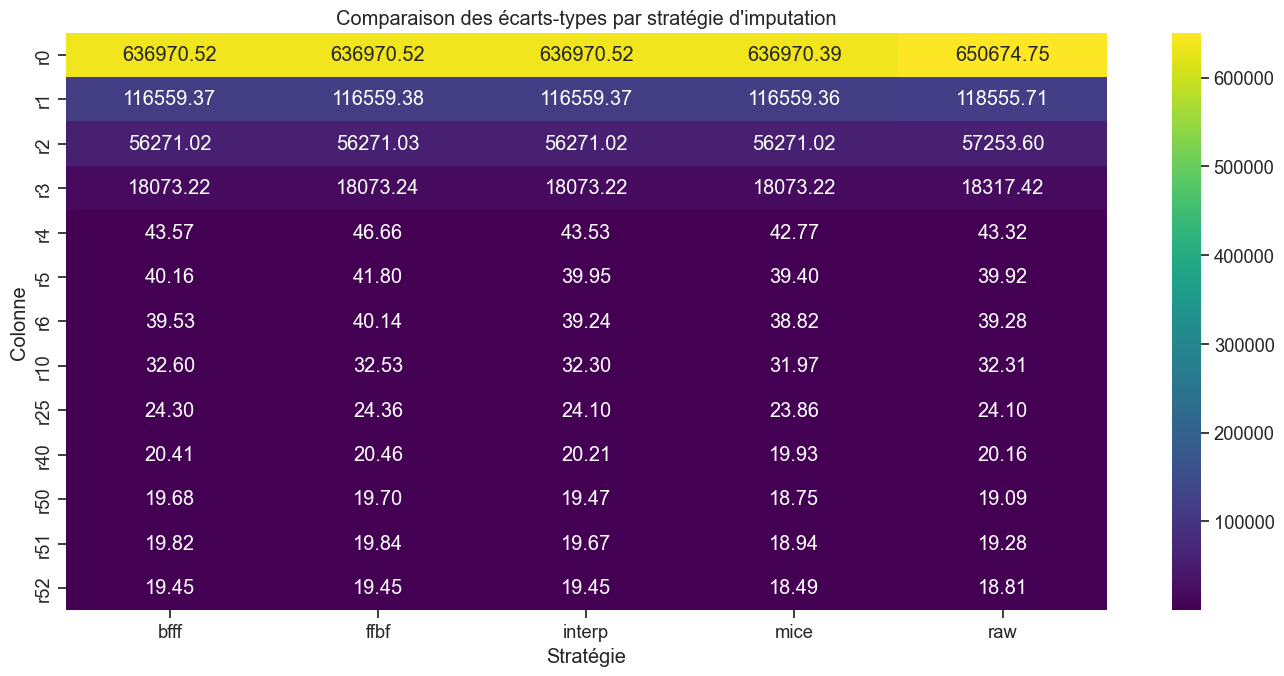

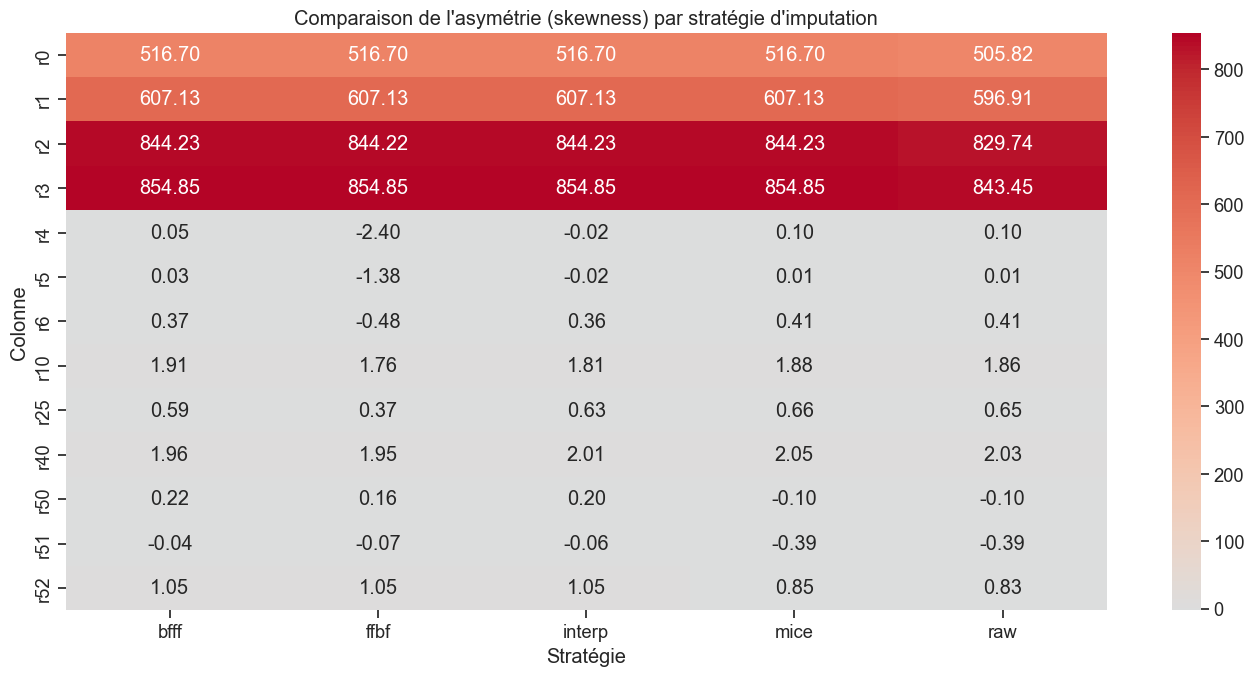

In [ ]:
print("\n--- Comparaison des statistiques entre les stratégies d'imputation ---")
stats_results = compare_column_stats(imputed_datasets)

Encore une fois, on observe que les statistiques principales pour les premiers rendements sont démesurement plus grands par rapport au reste. 

### 3.4 Impact des méthodes de normalisation


--- Impact des différentes méthodes de normalisation ---


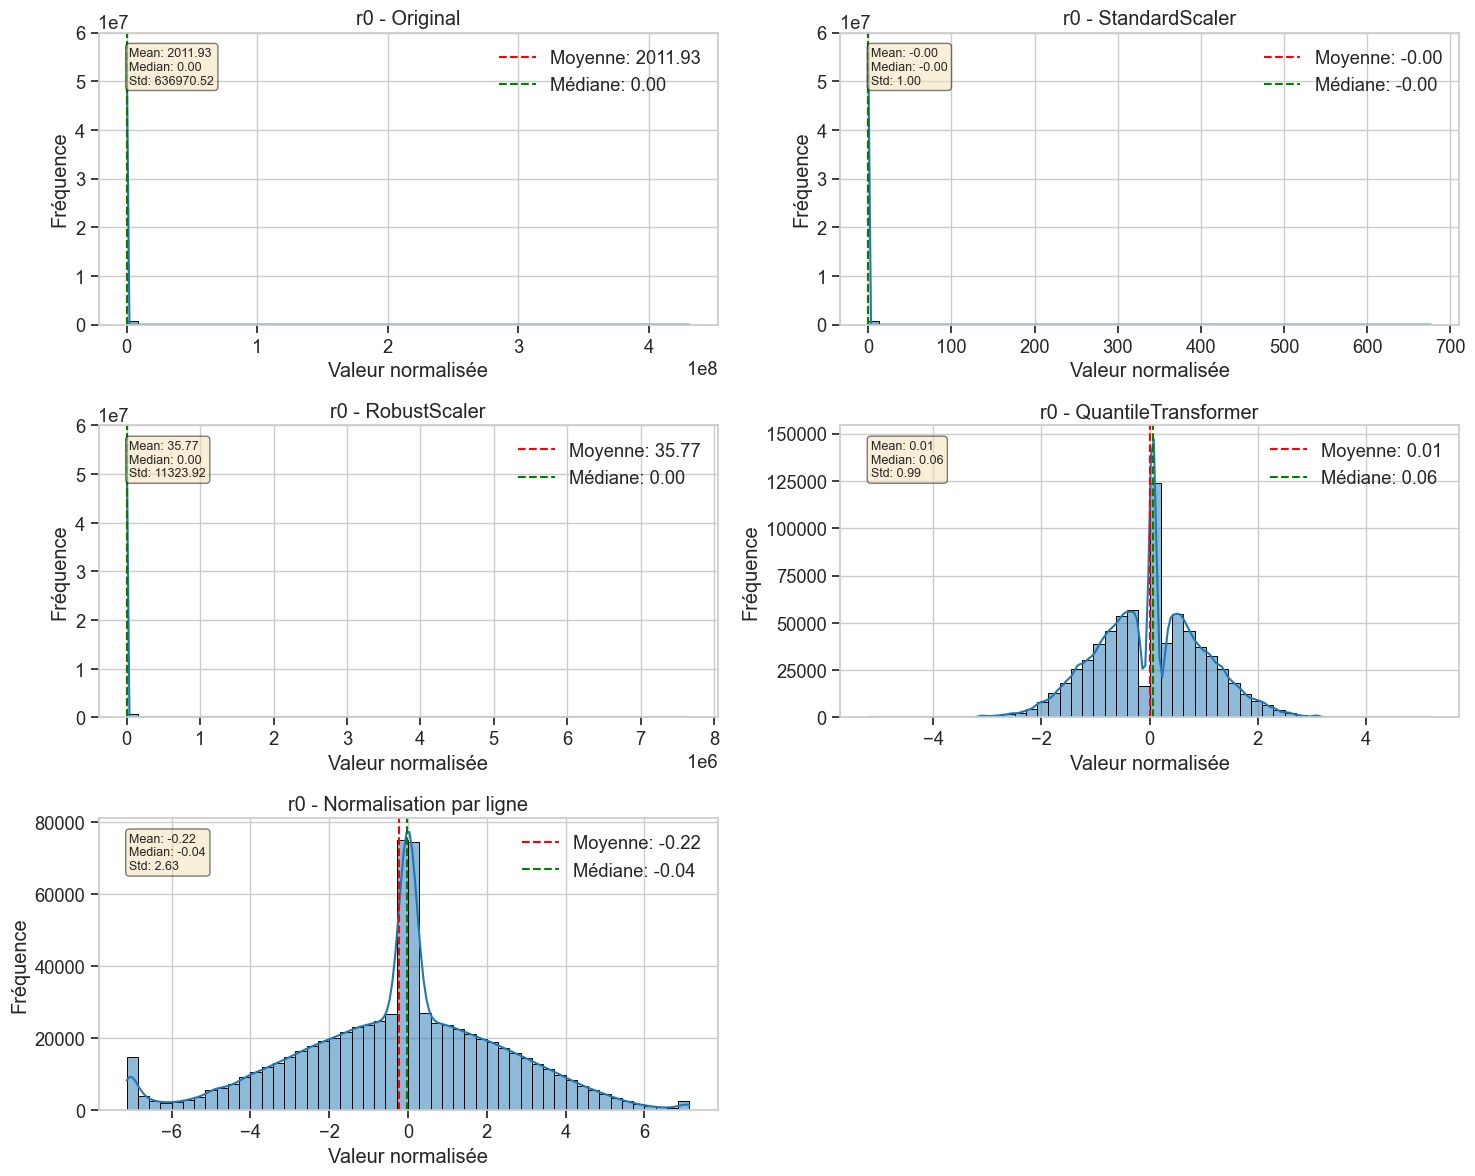

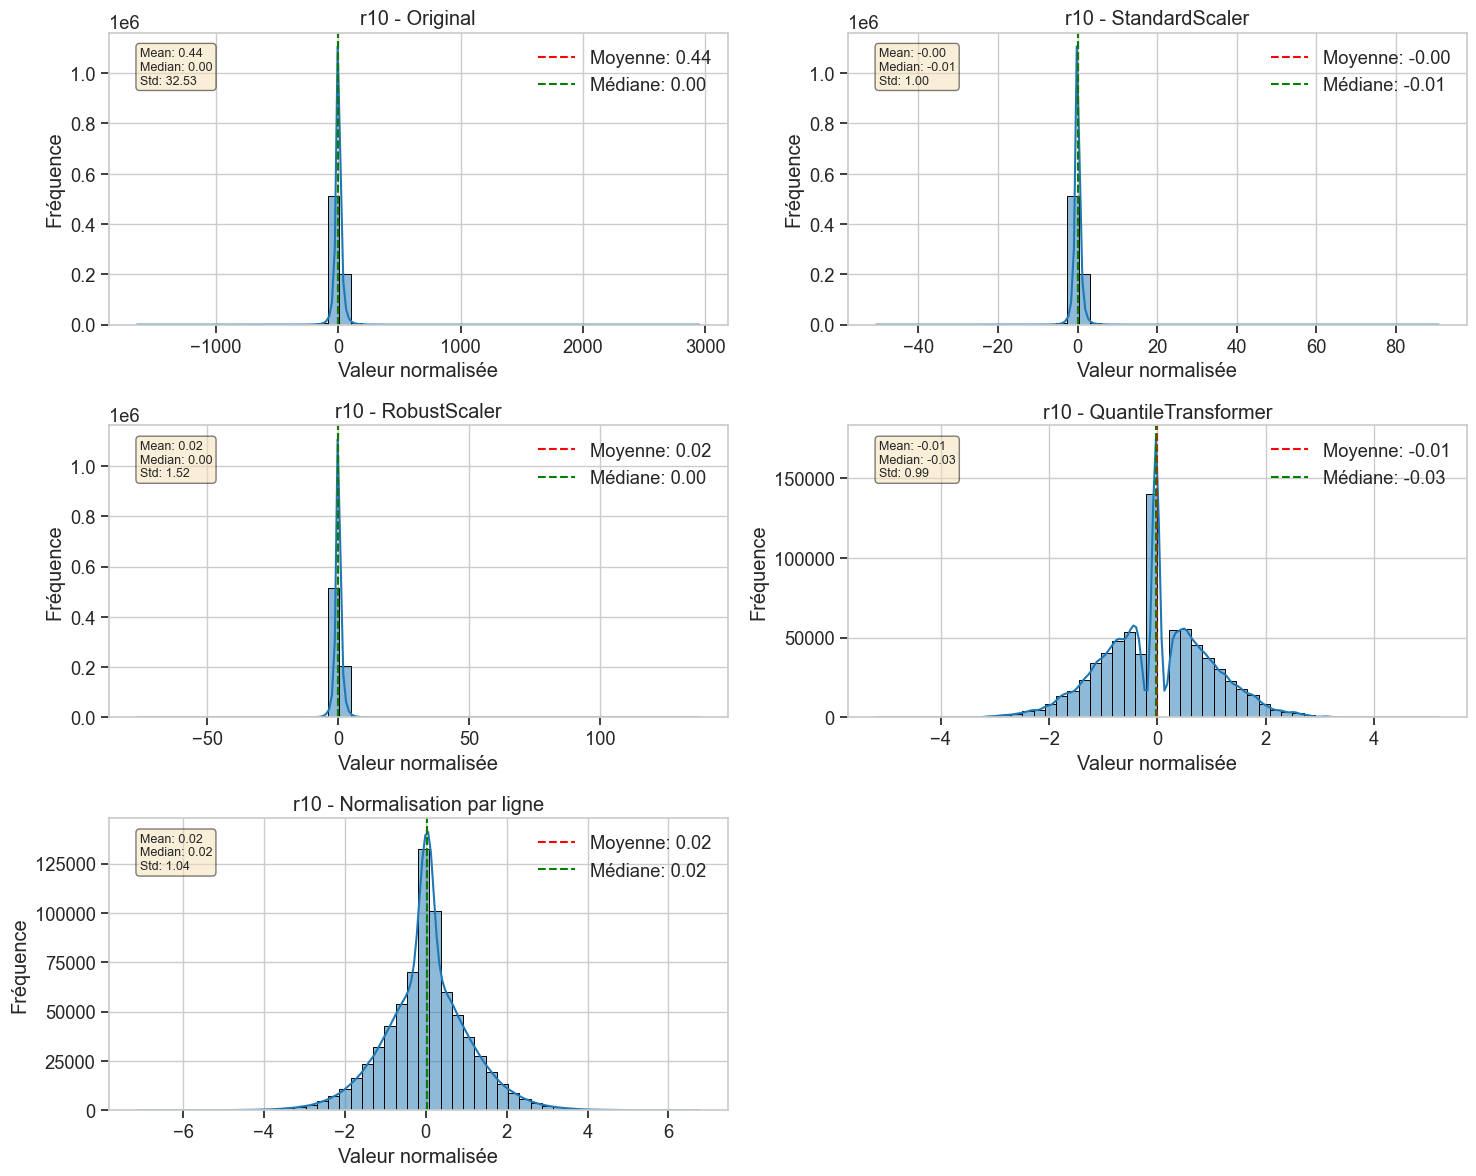

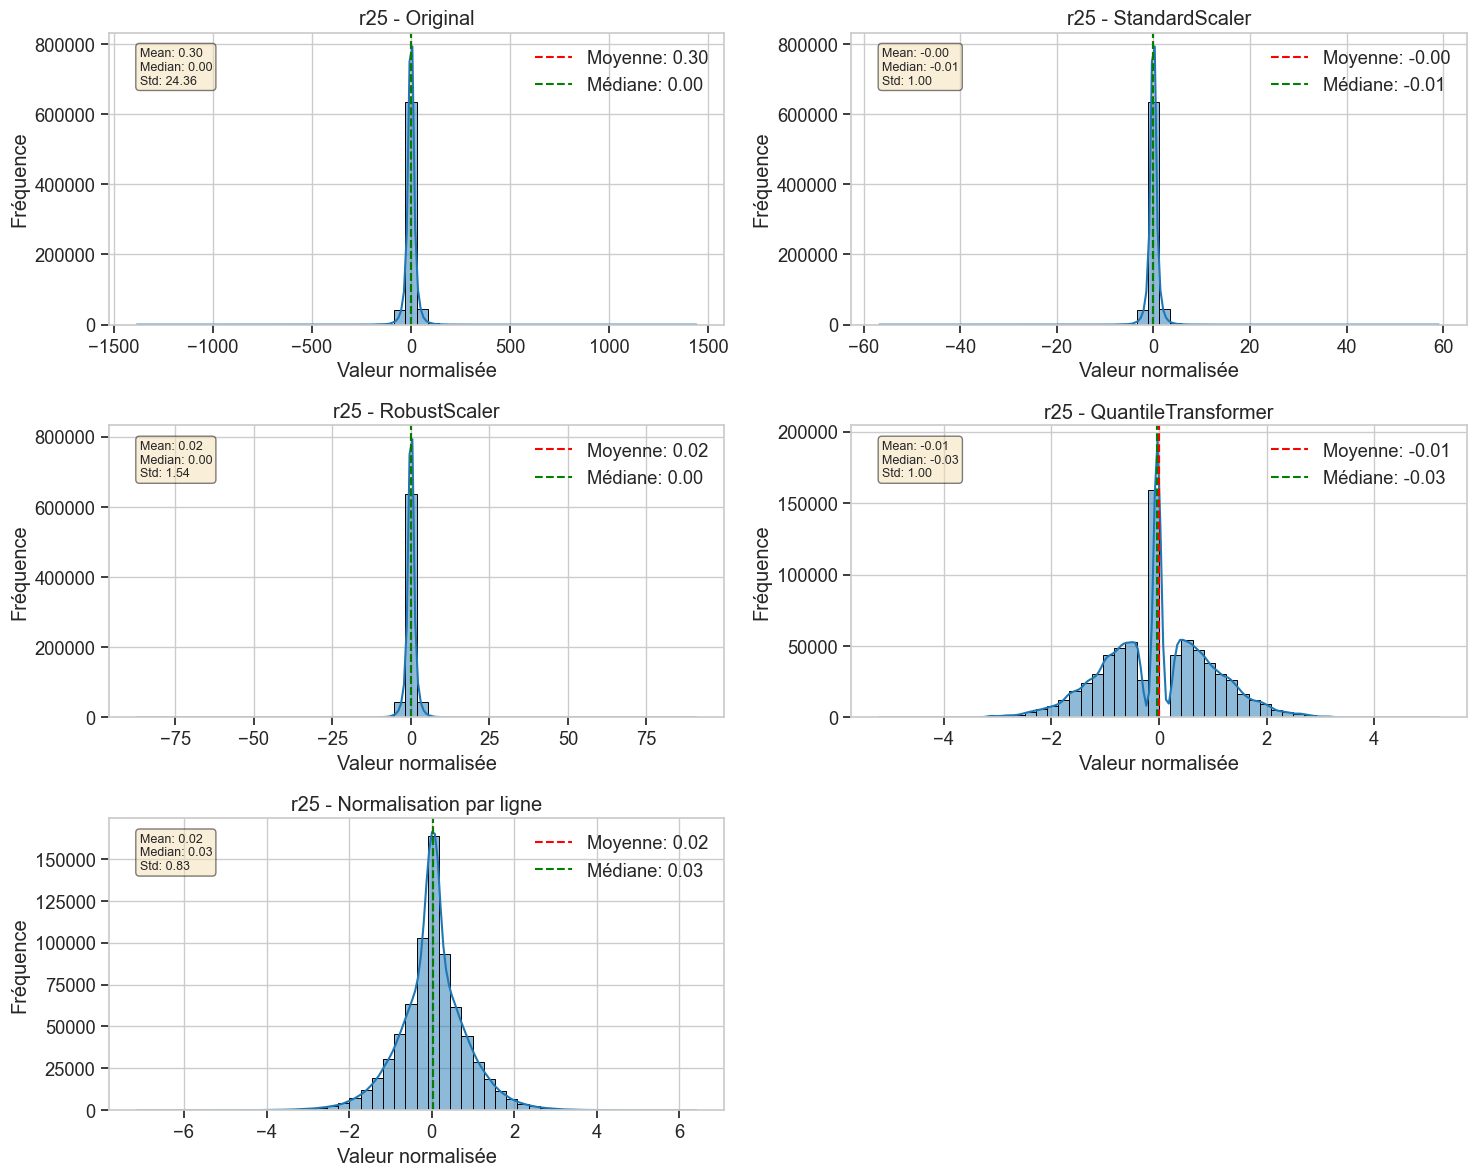

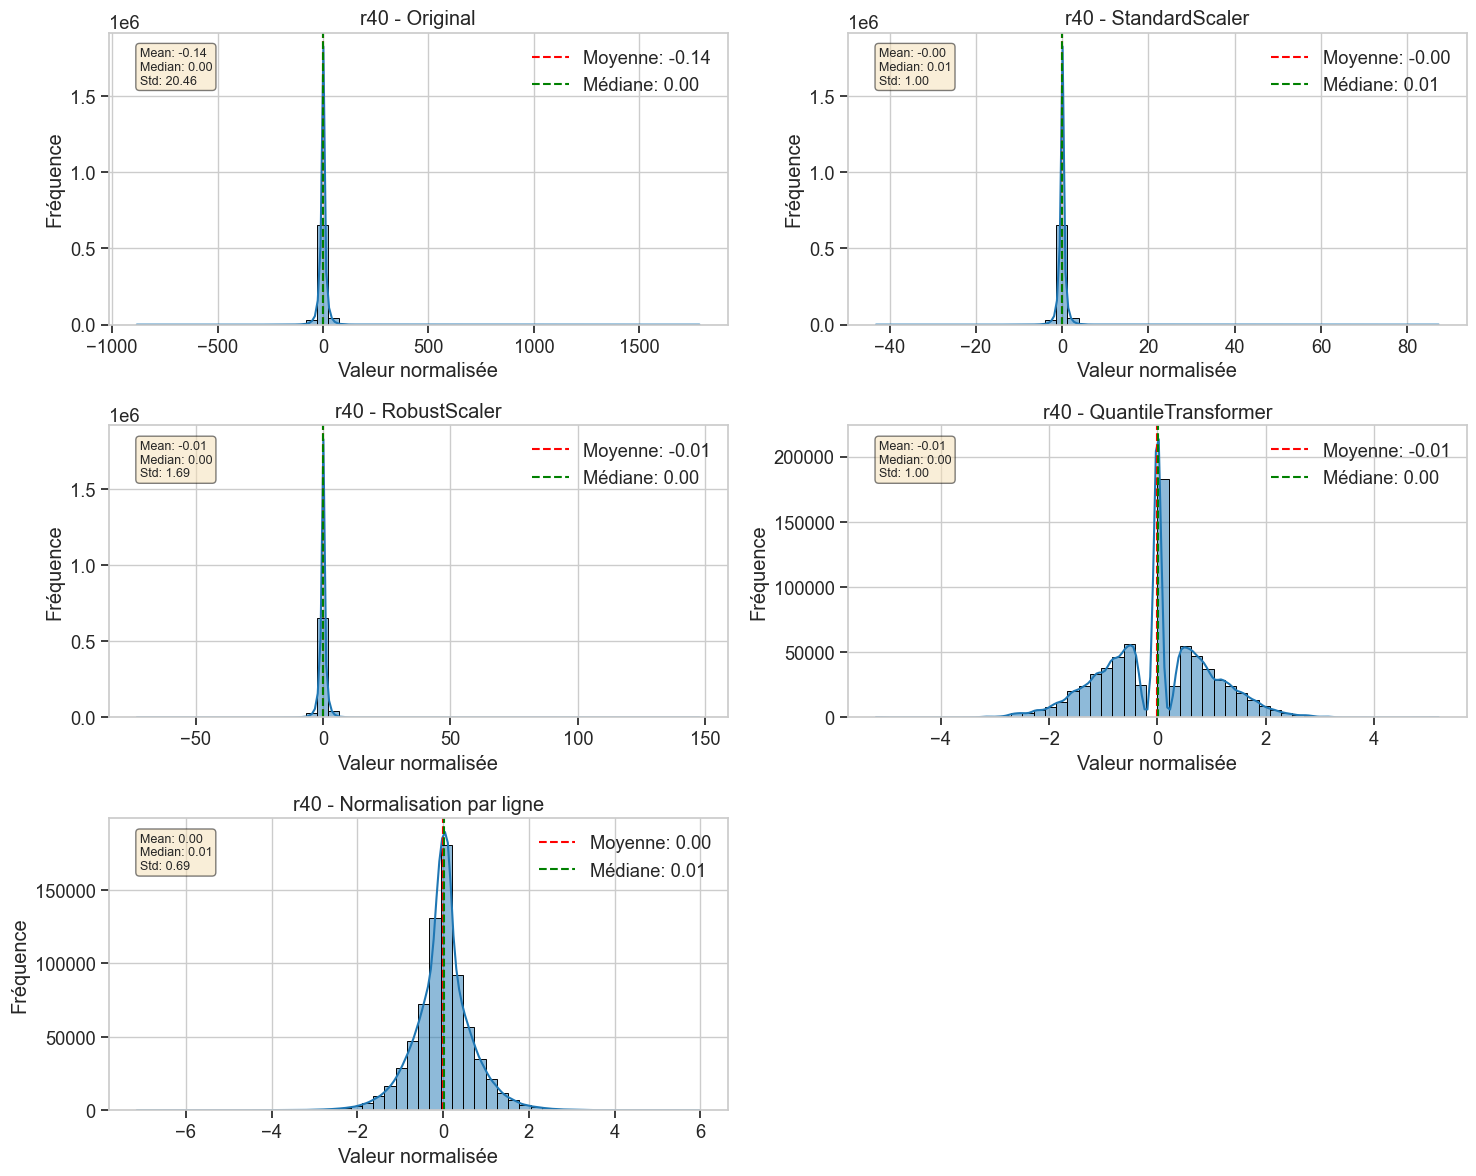

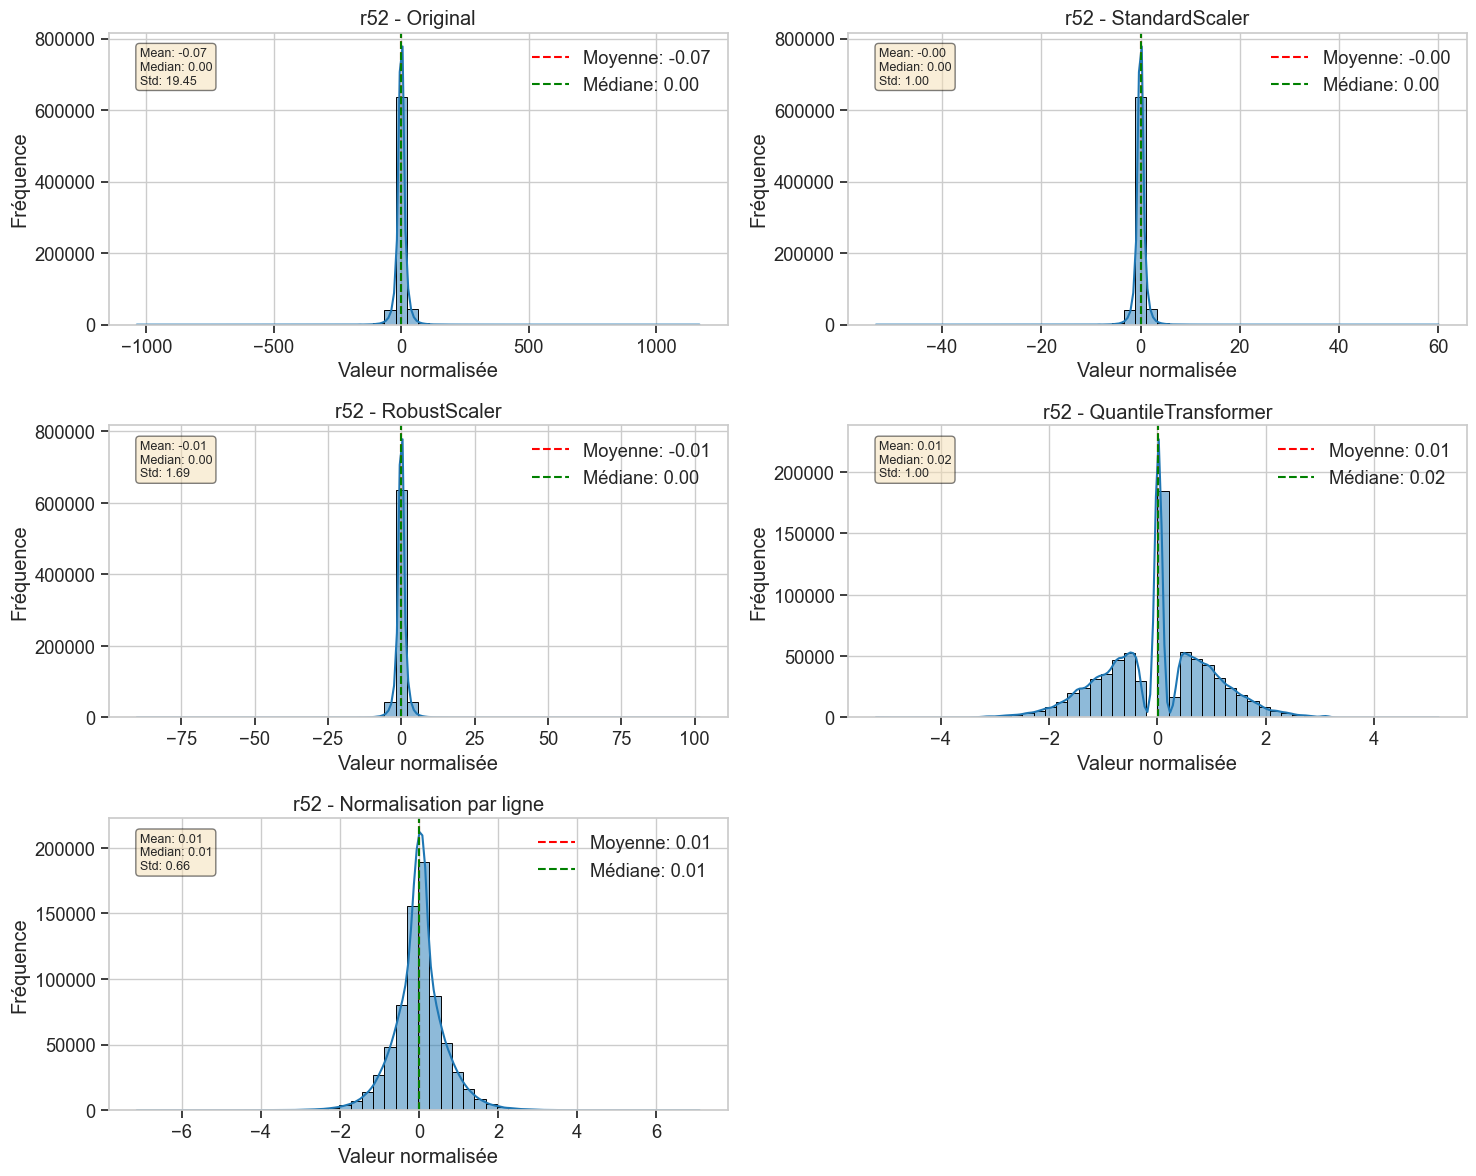


Statistiques après normalisation:


Kurtosis                                     \
Méthode Normalisation par ligne       Original QuantileTransformer   
Colonne                                                              
r0                     0.286115  314352.382928           -0.007638   
r10                    1.406272     210.650947            0.036763   
r25                    2.413538     104.170176            0.116088   
r40                    2.922470     221.466285            0.216052   
r52                    3.511795     132.957589            0.104776   

                                                      Moyenne               \
Méthode   RobustScaler StandardScaler Normalisation par ligne     Original   
Colonne                                                                      
r0       314352.382928  314352.382928               -0.218097  2011.933860   
r10         210.650947     210.650947                0.023956     0.441309   
r25         104.170176     104.170176                0.021261     0.298970   
r40         221.466285     221.466285                0.002842    -0.138532   
r52         132.957589     132.957589                0.006341    -0.065975   

                                                         \
Méthode QuantileTransformer RobustScaler StandardScaler   
Colonne                                                   
r0                 0.012147    35.767713  -7.924261e-19   
r10               -0.012576     0.020603  -5.226123e-18   
r25               -0.008268     0.018874  -3.184289e-18   
r40               -0.010305    -0.011458  -1.492240e-17   
r52                0.005871    -0.005737  -3.441949e-18   

                       Skewness                                               \
Méthode Normalisation par ligne    Original QuantileTransformer RobustScaler   
Colonne                                                                        
r0                    -0.250644  516.699019            0.002077   516.699019   
r10                    0.012088    1.762238            0.014590     1.762238   
r25                   -0.083359    0.372370            0.027116     0.372370   
r40                    0.028564    1.953211           -0.023181     1.953211   
r52                    0.069300    1.050953           -0.052902     1.050953   

                                    Écart-type                 \
Méthode StandardScaler Normalisation par ligne       Original   
Colonne                                                         
r0          516.699019                2.629368  636970.524974   
r10           1.762238                1.044093      32.525730   
r25           0.372370                0.830841      24.358171   
r40           1.953211                0.685904      20.458597   
r52           1.050953                0.660190      19.449087   

                                                          
Méthode QuantileTransformer  RobustScaler StandardScaler  
Colonne                                                   
r0                 0.991334  11323.920444       1.000001  
r10                0.992987      1.518475       1.000001  
r25                1.004868      1.537763       1.000001  
r40                1.003741      1.692192       1.000001  
r52                1.002203      1.691225       1.000001

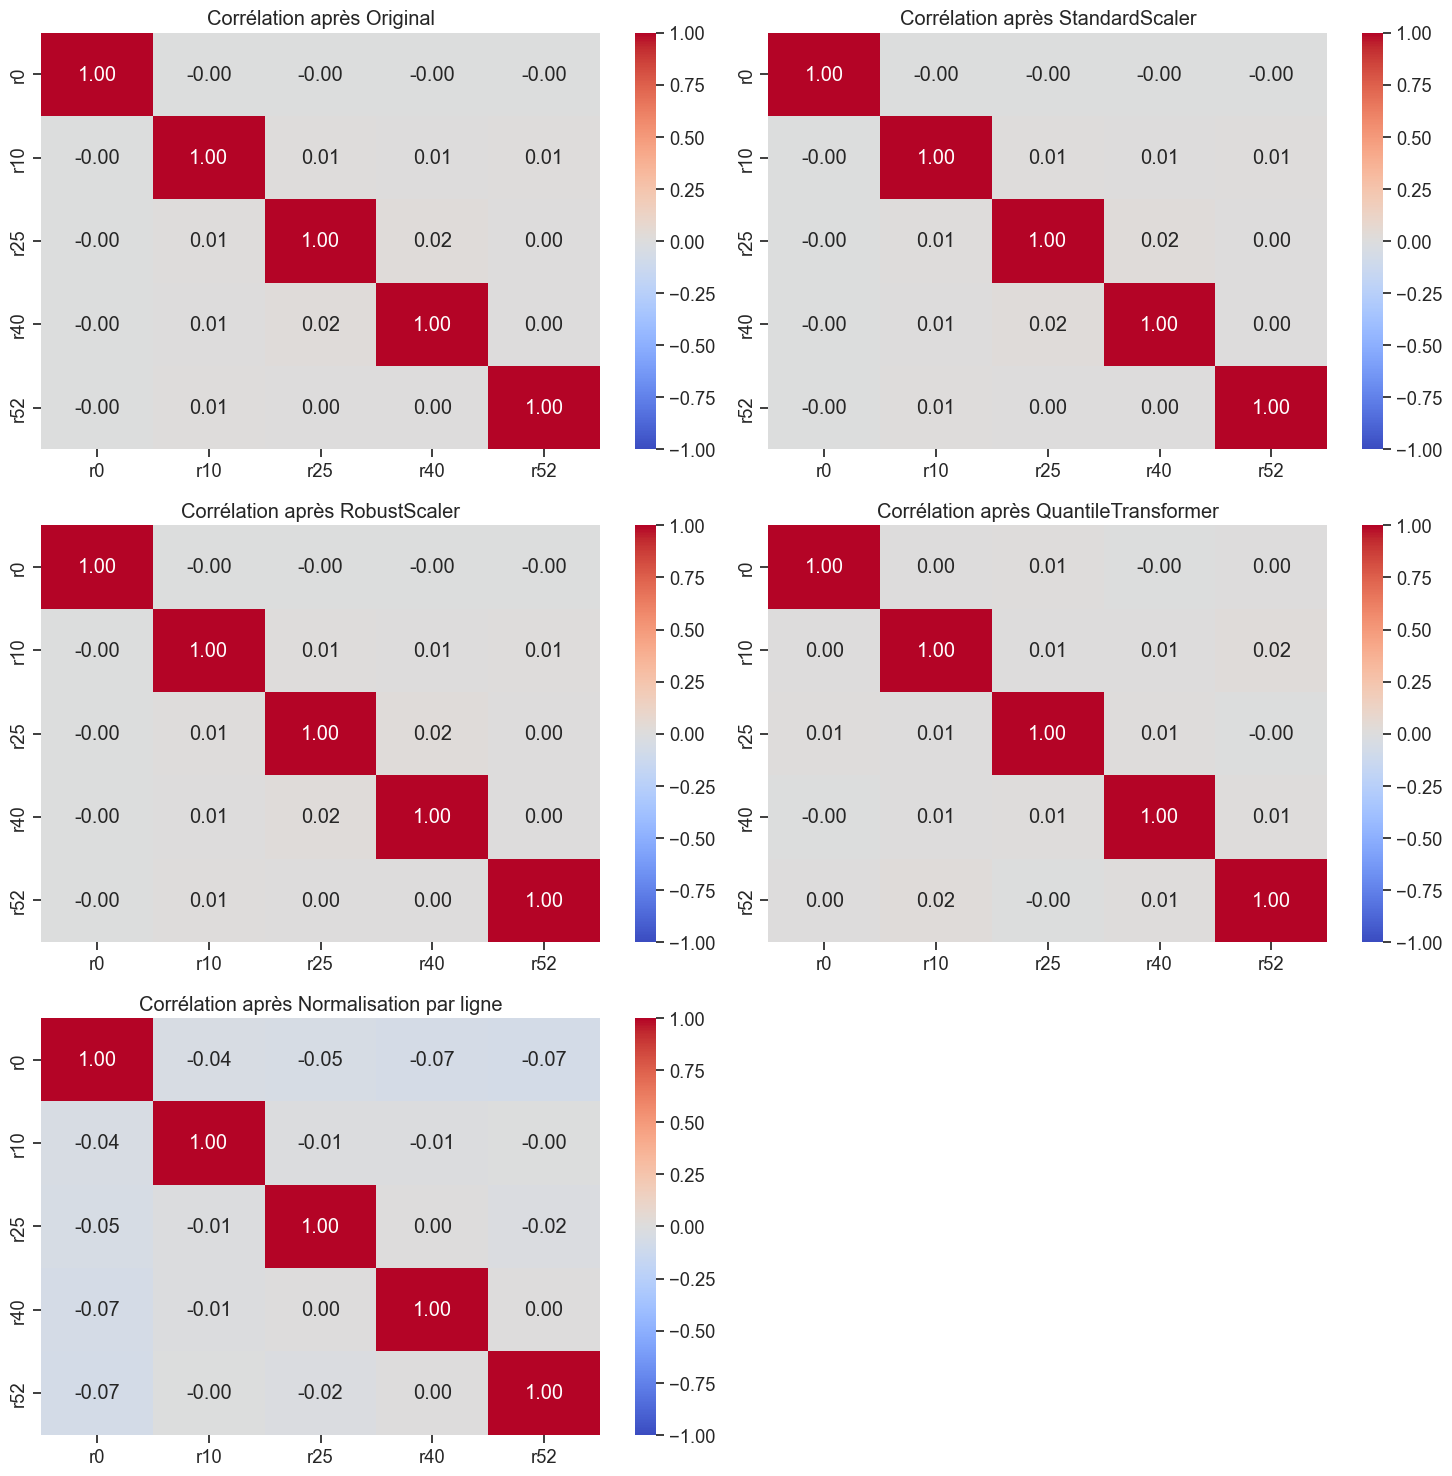

In [ ]:
normalization_results = analyze_normalization(imputed_datasets)

La normalisation par ligne et par le Quantile sont deux méthodes qui permettent de résorber le problème des longues queues de distribution qui pourraient fausser les calculs. Bien que les rendements ne suivent pas une loi normale, la distribution est légèrement meilleure et règle le soucis des extrêmes.

## 4. Modèles de référence (benchmarks)
 
Nous établissons des modèles de base pour servir de références aux futures améliorations. Et effectuons une comparaison de base qui nous servira de sélection pour le choix des jeux de données. 

#### Features d'Ingénierie pour la Prédiction des Prix d'Actions

Notre modèle utilise deux catégories principales de features dérivées des rendements bruts (r0 à r52):

##### 1. Features Statistiques de Base (`basic_stats`)

Ces features capturent les distributions et tendances générales des rendements:

| Feature | Description | Formule |
|---------|-------------|---------|
| `r_mean` | Moyenne des rendements | $\frac{1}{n}\sum_{i=0}^{n} r_i$ |
| `r_std` | Écart-type des rendements | $\sqrt{\frac{1}{n}\sum_{i=0}^{n}(r_i - \bar{r})^2}$ |
| `r_min` | Rendement minimum | $\min(r_0, r_1, ..., r_{52})$ |
| `r_max` | Rendement maximum | $\max(r_0, r_1, ..., r_{52})$ |
| `r_sum` | Somme totale des rendements | $\sum_{i=0}^{n} r_i$ |
| `r_pos_count` | Nombre de rendements positifs | $\sum_{i=0}^{n} \mathbb{1}_{r_i > 0}$ |
| `r_neg_count` | Nombre de rendements négatifs | $\sum_{i=0}^{n} \mathbb{1}_{r_i < 0}$ |
| `r_zero_count` | Nombre de rendements nuls | $\sum_{i=0}^{n} \mathbb{1}_{r_i = 0}$ |
| `r_pos_sum` | Somme des rendements positifs | $\sum_{i=0}^{n} r_i \cdot \mathbb{1}_{r_i > 0}$ |
| `r_neg_sum` | Somme des rendements négatifs | $\sum_{i=0}^{n} r_i \cdot \mathbb{1}_{r_i < 0}$ |

##### 2. Indicateurs Techniques (`technical`)

Ces features s'inspirent d'indicateurs techniques utilisés en analyse financière:

| Feature | Description | Formule |
|---------|-------------|---------|
| `r_roll_mean_X` | Moyenne mobile sur X périodes | $\frac{1}{X}\sum_{i=n-X+1}^{n} r_i$ |
| `r_roll_std_X` | Écart-type mobile sur X périodes | $\sqrt{\frac{1}{X}\sum_{i=n-X+1}^{n}(r_i - \bar{r}_X)^2}$ |
| `r_momentum_5` | Différence de prix sur 5 périodes | $r_n - r_{n-5}$ |
| `r_momentum_10` | Différence de prix sur 10 périodes | $r_n - r_{n-10}$ |

##### 3. Features Financières Avancées

En complément, nous utilisons également des indicateurs financiers plus sophistiqués:

| Feature | Description | Formule |
|---------|-------------|---------|
| `volatility_X` | Volatilité sur X périodes | $\sqrt{\frac{1}{X}\sum_{i=0}^{X-1}(r_i - \bar{r})^2}$ |
| `sharpe_ratio` | Ratio rendement/risque | $\frac{\bar{r}}{\sigma_r}$ |
| `momentum` | Différence entre rendements récents et anciens | $\bar{r}_{récent} - \bar{r}_{ancien}$ |
| `trend_slope` | Pente de la tendance linéaire | Coefficient de régression linéaire sur les rendements |
| `pos_ratio` | Ratio de rendements positifs | $\frac{\sum_{i=0}^{n} \mathbb{1}_{r_i > 0}}{n}$ |
| `neg_ratio` | Ratio de rendements négatifs | $\frac{\sum_{i=0}^{n} \mathbb{1}_{r_i < 0}}{n}$ |

**Ces dernières features ne sont utilisés que lors de la sélection des features les plus pertinentes et n'entrent pas dans le benchmark.**

### 4.1 XGBoost baseline
 
Nous commençons par évaluer les performances du modèle XGBoost sur les données brutes (70%)

In [ ]:
print("\nDatasets disponibles:")
for key, info in DATASETS.items():
    print(f"- {key}: {info['description']}")

print("\nModèles disponibles:")
models = get_models()
for key, info in models.items():
    if 'description' in info:
        print(f"- {key}: {info['description']}")
    else:
        print(f"- {key}")


Datasets disponibles:
- raw: Données brutes
- ffbf: Données forward filled puis backward
- bfff: Données backward filled puis forward
- interp: Données interpolation linéaire puis bffff
- mice: Données MICE imputer puis bfff
- knn: Données knn imputer puis bfff
- raw_with_features: Données brutes avec features
- ffbf_with_features: Données forward filled puis backward avec features
- bfff_with_features: Données backward filled puis forward avec features
- interp_with_features: Données interpolation linéaire puis bffff avec features
- mice_with_features: Données MICE imputer puis bfff avec features
- knn_with_features: Données knn imputer puis bfff avec features
- low_nan: Colonnes avec <30% de NaN, imputation à 0

Modèles disponibles:
- xgboost_baseline: XGBoost de base
- xgboost_tuned: XGBoost avec paramètres 
- rf_baseline: Baseline Random Forest model
- logistic: Multinomial Logistic Regression



--- Baseline XGBoost sur données brutes ---
Attention: Valeurs manquantes détectées - Train: 969666, Test: 512130
Application de fillna(0)...

Résultats détaillés de l'expérience baseline:
Dataset: raw (Données brutes)
Model: xgboost_baseline (XGBoost de base)
Features Added: False
Feature Sets: None
Accuracy: 0.3105
Weighted F1-Score: 0.2658
Class-wise Performance:
  Class -1: Precision = 0.3014, Recall = 0.1128
  Class  0: Precision = 0.4117, Recall = 0.1670
  Class  1: Precision = 0.2885, Recall = 0.7208
Timing Information:
  Data Loading: 9.92 seconds
  Training: 21.16 seconds
  Prediction: 1.05 seconds
  Total Time: 32.14 seconds


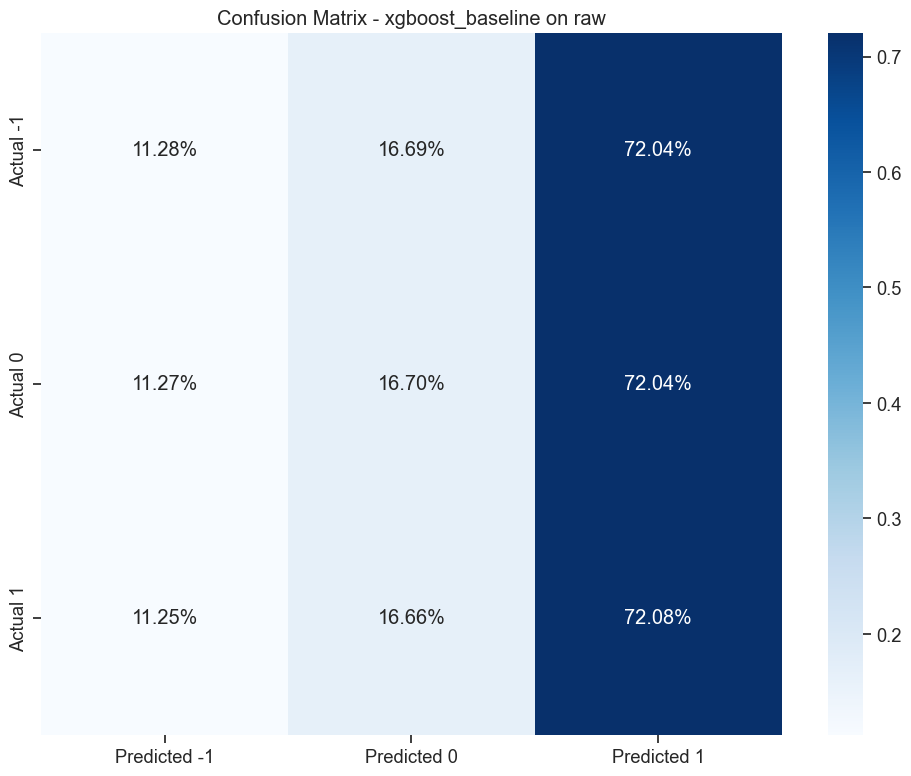

In [ ]:
print("\n--- Baseline XGBoost sur données brutes ---")
baseline_result = run_experiment(dataset_key="raw", model_key="xgboost_baseline", add_feat=False)
results_tracker = add_result(results_tracker, baseline_result)

# Ajouter la colonne normalize_by_row si elle n'existe pas
if 'normalize_by_row' not in results_tracker.columns:
    results_tracker['normalize_by_row'] = False

print("\nRésultats détaillés de l'expérience baseline:")
display_experiment_result(baseline_result)

#### Performance globale

Accuracy de 31.05%: Cela signifie que le modèle prédit correctement la direction du prix dans environ 31% des cas. Pour un problème à 3 classes où une prédiction aléatoire donnerait ~33%, cette performance est à peine inférieure au hasard.

F1-Score pondéré de 0.2658: Cette métrique combine précision et rappel. Un score bas indique un déséquilibre entre ces deux mesures.

Analyse par classe : 

**Classe -1 (baisse de prix):**

- Precision de 30.14%: Quand le modèle prédit une baisse, il a raison dans 30% des cas.

- Recall très faible de 11.28%: Le modèle ne détecte que 11% des véritables baisses.


**Classe 0 (prix stable):**

- Precision de 41.17%: Meilleure précision des trois classes.

- Recall faible de 16.70%: Le modèle manque plus de 83% des cas où le prix reste stable.


**Classe 1 (hausse de prix):**

- Precision  de 28.85%: La plus faible précision des trois classes.

- Recall très élevé de 72.08%: Le modèle détecte bien les hausses, mais le résultat est biaisé. 


#### Biais du modèle

Le modèle montre un fort biais vers la classe 1 (hausse). Le modèle prédit "hausse" par défaut et la bonne performance du recall sur la classe 1 est due à sa tendance à prédire systématiquement cette classe
Il est particulièrement mauvais pour détecter les baisses (-1)

### 4.2 Benchmark XGBoost sur les différentes stratégies d'imputation

**experiment_runner()** exécute une expérience  : charge les données, prépare les variables (avec ajout ou normalisation facultative de caractéristiques), entraîne un modèle choisi, puis évalue ses performances à l’aide de métriques détaillées. On peut choisir de calculer les features ou non, de normaliser ou non, et map et remap les catégories pour s'adapter au XGBoost

In [ ]:
print("\n--- Comparaison des stratégies d'imputation avec XGBoost ---")

# Liste des stratégies d'imputation à tester
imputation_strategies = ["raw", "ffbf", "bfff", "interp", "knn", "mice", "low_nan"]
imputation_results = []

# Tester les datasets standards (sans features ni normalisation)
for strategy in imputation_strategies:
    print(f"\nTest de {strategy} sans features ni normalisation...")
    try:
        # Sans feature engineering
        result_without_features = run_experiment(
            dataset_key=strategy, 
            model_key="xgboost_baseline", 
            add_feat=False,
            normalize_by_row=False
        )
        results_tracker = add_result(results_tracker, result_without_features)
        imputation_results.append(result_without_features)
        print(f"Accuracy: {result_without_features['accuracy']:.4f}")
    except Exception as e:
        print(f"Erreur lors du traitement de {strategy}: {e}")

# Tester avec normalisation par ligne
for strategy in imputation_strategies:
    print(f"\nTest de {strategy} avec normalisation par ligne...")
    try:

        result_normalized = run_experiment(
            dataset_key=strategy, 
            model_key="xgboost_baseline", 
            add_feat=False,
            normalize_by_row=True         # Avec normalisation par ligne
        )
        results_tracker = add_result(results_tracker, result_normalized)
        imputation_results.append(result_normalized)
        print(f"Accuracy: {result_normalized['accuracy']:.4f}")
        
        # Calculer l'amélioration due à la normalisation
        standard_result = next((r for r in imputation_results 
                               if r['dataset'] == strategy and not r.get('normalize_by_row', False)), None)
        if standard_result:
            improvement = result_normalized['accuracy'] - standard_result['accuracy']
            print(f"Amélioration due à la normalisation: {improvement:.4f} ({improvement*100:.2f}%)")
    except Exception as e:
        print(f"Erreur lors de la normalisation de {strategy}: {e}")

#Tester les datasets avec features prétraitées
for strategy in imputation_strategies:
    if strategy == "low_nan":
        continue  # Pas de version avec features pour low_nan
        
    print(f"\nTest de {strategy} avec features prétraitées...")
    try:
        preprocessed_key = f"{strategy}_with_features"
        
        if preprocessed_key in DATASETS:
            # Sans normalisation
            result_with_features = run_experiment(
                dataset_key=preprocessed_key, 
                model_key="xgboost_baseline", 
                add_feat=False,         #On n'utilise pas la fonction de features puisqu'elles sont déjà calculées ici 
                normalize_by_row=False
            )
            results_tracker = add_result(results_tracker, result_with_features)
            imputation_results.append(result_with_features)
            print(f"Accuracy avec features prétraitées: {result_with_features['accuracy']:.4f}")
            
            # Avec normalisation par ligne
            result_features_normalized = run_experiment(
                dataset_key=preprocessed_key, 
                model_key="xgboost_baseline", 
                add_feat=False,
                normalize_by_row=True
            )
            results_tracker = add_result(results_tracker, result_features_normalized)
            imputation_results.append(result_features_normalized)
            print(f"Accuracy avec features et normalisation: {result_features_normalized['accuracy']:.4f}")
            
            # Comparer avec le dataset standard
            standard_result = next((r for r in imputation_results 
                                   if r['dataset'] == strategy and not r.get('normalize_by_row', False)), None)
            if standard_result:
                improvement_features = result_with_features['accuracy'] - standard_result['accuracy']
                print(f"Amélioration due aux features: {improvement_features:.4f} ({improvement_features*100:.2f}%)")
            
            # Comparer normalisation avec/sans features
            improvement_norm = result_features_normalized['accuracy'] - result_with_features['accuracy']
            print(f"Amélioration due à la normalisation: {improvement_norm:.4f} ({improvement_norm*100:.2f}%)")
        else:
            print(f"Le dataset prétraité '{preprocessed_key}' n'existe pas dans le registre.")
    except Exception as e:
        print(f"Erreur lors du traitement de {strategy} avec features: {e}")


--- Comparaison des stratégies d'imputation avec XGBoost ---

Test de raw sans features ni normalisation...
Attention: Valeurs manquantes détectées - Train: 969666, Test: 512130
Application de fillna(0)...
Accuracy: 0.3105

Test de ffbf sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3136

Test de bfff sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3132

Test de interp sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3118

Test de knn sans features ni normalisation...
Attention: Valeurs manquantes détectées - Train: 5362225, Test: 8004811
Application de fillna(0)...
Erreur lors du traitement de knn: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got [ 0.  1.  2. nan]

Test de mice sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3112

Test de low_nan sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3105

### 4.3 Visualisation des résultats des benchmarks


--- Visualisation des résultats des benchmarks ---
Top 10 des meilleures configurations:


dataset                                dataset_description  \
10                interp          Données interpolation linéaire puis bffff   
12               low_nan          Colonnes avec <30% de NaN, imputation à 0   
2                   ffbf               Données forward filled puis backward   
3                   bfff               Données backward filled puis forward   
7                    raw                                     Données brutes   
9                   bfff               Données backward filled puis forward   
17    bfff_with_features  Données backward filled puis forward avec feat...   
8                   ffbf               Données forward filled puis backward   
4                 interp          Données interpolation linéaire puis bffff   
19  interp_with_features  Données interpolation linéaire puis bffff avec...   

               model normalize_by_row features_added  accuracy  f1_weighted  \
10  xgboost_baseline             True          False  0.318455     0.275464   
12  xgboost_baseline             True          False  0.316347     0.264087   
2   xgboost_baseline            False          False  0.313561     0.275949   
3   xgboost_baseline            False          False  0.313178     0.278233   
7   xgboost_baseline             True          False  0.312979     0.262334   
9   xgboost_baseline             True          False  0.312760     0.260070   
17  xgboost_baseline            False          False  0.312224     0.269205   
8   xgboost_baseline             True          False  0.312087     0.257210   
4   xgboost_baseline            False          False  0.311830     0.275198   
19  xgboost_baseline            False          False  0.311811     0.266444   

    total_time  
10   26.681862  
12   26.472266  
2    23.970196  
3    24.582174  
7    27.132666  
9    29.832149  
17   36.342103  
8    25.556113  
4    26.894272  
19   34.676225

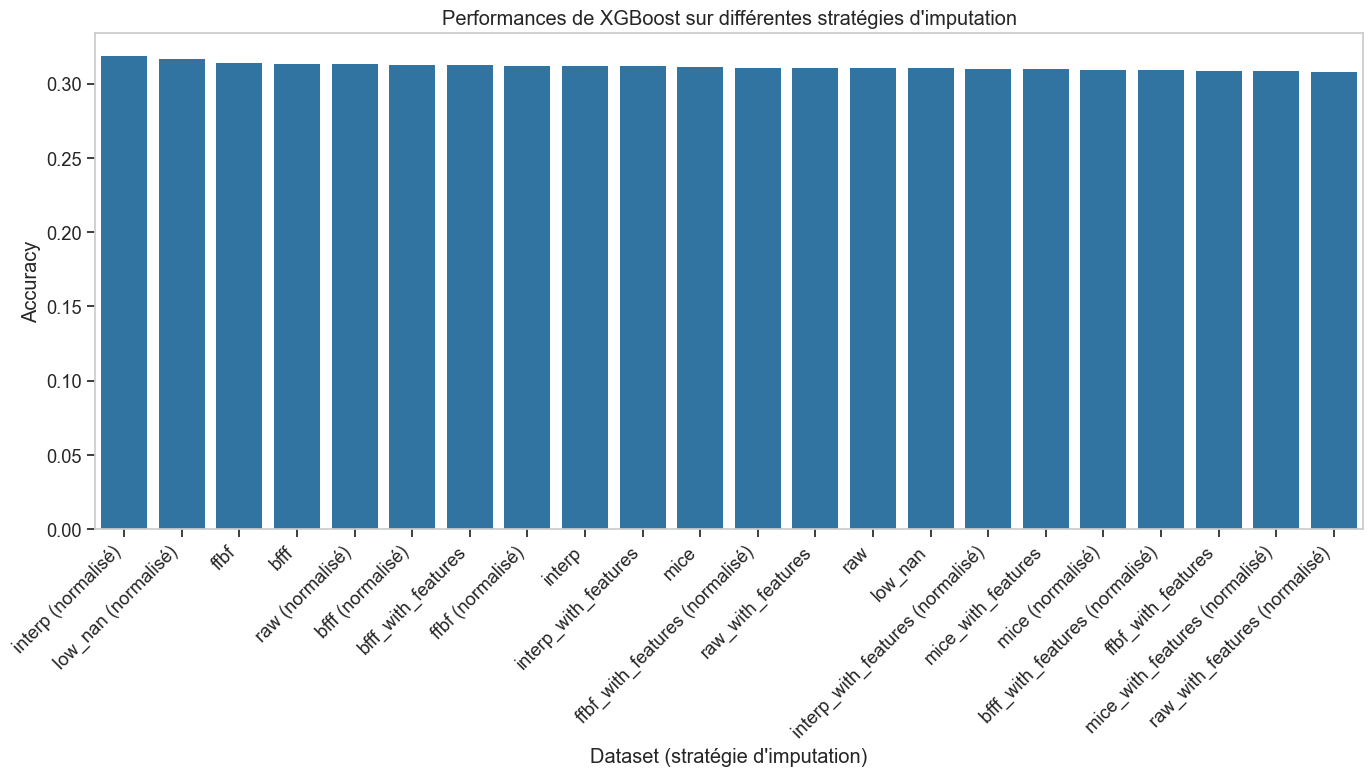

In [ ]:
print("\n--- Visualisation des résultats des benchmarks ---")

# Créer un DataFrame pour la visualisation
summary_df = results_tracker[["dataset", "dataset_description", "model", "normalize_by_row", 
                             "features_added", "accuracy", "f1_weighted", "total_time"]]
summary_df = summary_df.sort_values(by="accuracy", ascending=False)

# Afficher un tableau des résultats
print("Top 10 des meilleures configurations:")
display(summary_df.head(10))

# Visualiser les résultats par dataset et normalisation
plt.figure(figsize=(14, 8))
summary_plot_data = summary_df.copy()
summary_plot_data["dataset_norm"] = summary_plot_data["dataset"] + \
                                    summary_plot_data["normalize_by_row"].apply(lambda x: " (normalisé)" if x else "")

# Filtrer pour n'inclure que XGBoost
xgb_data = summary_plot_data[summary_plot_data["model"] == "xgboost_baseline"]

# Barplot des résultats
sns.barplot(x="dataset_norm", y="accuracy", data=xgb_data)
plt.title('Performances de XGBoost sur différentes stratégies d\'imputation')
plt.xlabel('Dataset (stratégie d\'imputation)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Un résultat un peu surprenant, qu'importe la transformation qu'on applique aux données, la différence est minime malgré. On remarque que les modèles avec les lignes normalisées sont quand même premier, suivi de très près par le dataset de base sans transformation. Les features initiales rajoutées n'ont pas l'air d'imapcter de amnière significative non plus. 

## 4.4 Régression Logistique : 

In [ ]:
print("\n--- Test avec régression logistique sur ffbf, bfff, interp ---")

# Sélectionner quelques datasets pour la comparaison
selected_datasets = ["ffbf", "bfff", "interp"]

for dataset_key in selected_datasets:
    try:
        # Test avec régression logistique
        result = run_experiment(
            dataset_key=dataset_key,
            model_key="logistic",
            add_feat=True,
            normalize_by_row=False
        )
        results_tracker = add_result(results_tracker, result)
        print(f"Régression logistique sur {dataset_key}: Accuracy = {result['accuracy']:.4f}")
        
        # Comparer avec XGBoost
        xgb_result = next((r for r in imputation_results 
                           if r['dataset'] == dataset_key and not r.get('normalize_by_row', False)), None)
        if xgb_result:
            diff = result['accuracy'] - xgb_result['accuracy']
            print(f"Différence par rapport à XGBoost: {diff:.4f} ({diff*100:.2f}%)")
    except Exception as e:
        print(f"Erreur avec logistique sur {dataset_key}: {e}")


--- Test avec régression logistique sur quelques datasets ---
Aucune valeur manquante détectée.
Régression logistique sur ffbf: Accuracy = 0.4108
Différence par rapport à XGBoost: 0.0972 (9.72%)
Aucune valeur manquante détectée.
Régression logistique sur bfff: Accuracy = 0.4108
Différence par rapport à XGBoost: 0.0976 (9.76%)
Aucune valeur manquante détectée.
Régression logistique sur interp: Accuracy = 0.4108
Différence par rapport à XGBoost: 0.0989 (9.89%)


#### Test supplémentaire avec low_nan 

Après les résultats suprenants de la régression logisitque, nous décidons de tester cette dernière sur le dataset classique légèrement retouché.

In [ ]:
selected_datasets = ["low_nan"]

for dataset_key in selected_datasets:
    try:
        # Test avec régression logistique
        result = run_experiment(
            dataset_key=dataset_key,
            model_key="logistic",
            add_feat=True,
            normalize_by_row=False
        )
        results_tracker = add_result(results_tracker, result)
        print(f"Régression logistique sur {dataset_key}: Accuracy = {result['accuracy']:.4f}")
        
        # Comparer avec XGBoost
        xgb_result = next((r for r in imputation_results 
                           if r['dataset'] == dataset_key and not r.get('normalize_by_row', False)), None)
        if xgb_result:
            diff = result['accuracy'] - xgb_result['accuracy']
            print(f"Différence par rapport à XGBoost: {diff:.4f} ({diff*100:.2f}%)")
    except Exception as e:
        print(f"Erreur avec logistique sur {dataset_key}: {e}")

Aucune valeur manquante détectée.
Régression logistique sur low_nan: Accuracy = 0.4108
Différence par rapport à XGBoost: 0.1003 (10.03%)


Remarques : Le résultat de la régression est assez surprenant pour au moins trois raisons. 

- 1 : L'accuracy du modèle est meilleure que celle du XGBoost
- 2 : Nous retrouvons l'accuracy du challenge avec un modèle différent et nous ne le retrouvons pas avec le XGBoost même, bien qu'il ne soit pas optimisé. 
- 3 : C'est la seconde fois que nous effectuons ce test, notre second notebook. Le second notebook "redaction.ipynb" est disponible sur le GitHub, et malgré un code structuré différemment, le fonds est exactement le même. Nous effectuons une régression logistique via experiment_runner() qui a par défaut row_normalisation à False et add_features à True. Les paramètres sont les mêmes et pourtant nous observons une accuracy à 41,08% sur le ffbf pour 34,60% sur l'autre notebook. 

Enfin, il est important de noter que ce chiffre 41,08% n'est pas anodin. Déjà, que 3 modèles entrainés sur 4 datasets différents aient la même accuracy au centième près est étonnant, mais également, on retrouve ce chiffre dans le notebook MLP.ipynb (GitHub) pour le MLP et Encodeur. Nous n'avons pas trouvé d'explication à ce résultat, sachant que les données utilisées dans MLP.ipynb sont les données brutes (celles directement fournies par le challenge). C'est peut être un hasard, mais un hasard très précis. 

#### 4.5 Résumé des performances des modèles de référence


--- Résumé des performances des modèles de référence ---


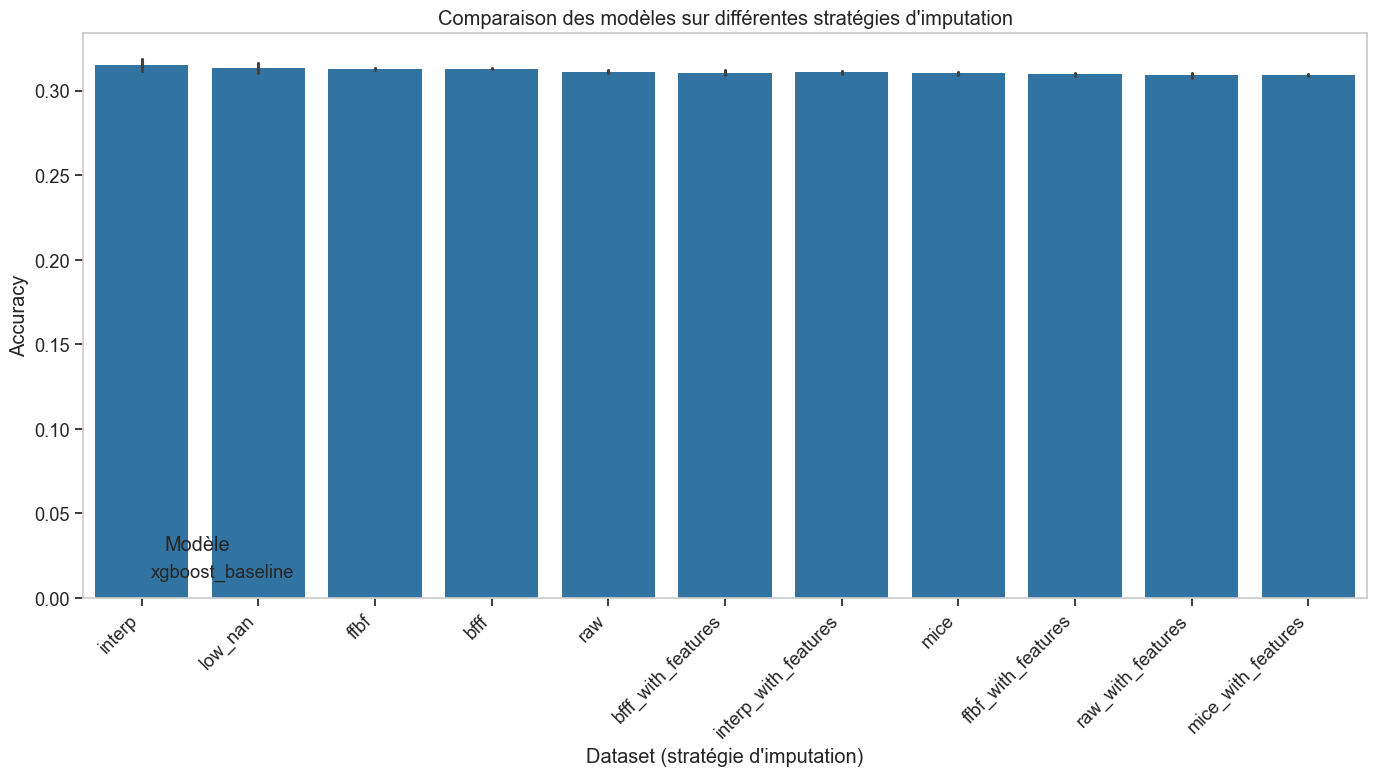


Meilleur résultat:
Dataset: interp - Données interpolation linéaire puis bffff
Modèle: xgboost_baseline
Normalisation: True
Features ajoutées: False
Accuracy: 0.3185
F1 score pondéré: 0.2755
Temps total: 26.68s


In [ ]:
print("\n--- Résumé des performances des modèles de référence ---")

# Créer un DataFrame pour comparer les modèles
model_comparison = summary_df[["model", "dataset", "normalize_by_row", "accuracy", "f1_weighted"]]
model_comparison = model_comparison.sort_values(by="accuracy", ascending=False)

# Visualiser la comparaison entre XGBoost et régression logistique
plt.figure(figsize=(14, 8))
sns.barplot(x="dataset", y="accuracy", hue="model", data=model_comparison)
plt.title('Comparaison des modèles sur différentes stratégies d\'imputation')
plt.xlabel('Dataset (stratégie d\'imputation)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.legend(title="Modèle")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Meilleur résultat
best_result = summary_df.iloc[0]
print(f"\nMeilleur résultat:")
print(f"Dataset: {best_result['dataset']} - {best_result['dataset_description']}")
print(f"Modèle: {best_result['model']}")
print(f"Normalisation: {best_result['normalize_by_row']}")
print(f"Features ajoutées: {best_result['features_added']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"F1 score pondéré: {best_result['f1_weighted']:.4f}")
print(f"Temps total: {best_result['total_time']:.2f}s")

## 5. Analyse approfondie et optimisation des modèles
 
 Après avoir établi des benchmarks, nous cherchons à améliorer les performances en analysant et optimisant les modèles.

In [ ]:
# 5.1 Sélection des datasets pour analyse approfondie
print("\n--- Sélection des meilleurs datasets pour analyse approfondie ---")

# Identifier les 3 meilleurs datasets d'après les résultats précédents
xgb_summary = summary_df[summary_df['model'] == 'xgboost_baseline']
top_datasets = xgb_summary.head(3)

print("Top 3 des meilleures configurations:")
display(top_datasets)

# Récupérer les informations des meilleurs datasets
best_configs = []
for _, row in top_datasets.iterrows():
    config = {
        "dataset": row["dataset"],
        "normalize": row["normalize_by_row"],
        "description": row["dataset_description"]
    }
    best_configs.append(config)


--- Sélection des meilleurs datasets pour analyse approfondie ---
Top 3 des meilleures configurations:


dataset                        dataset_description             model  \
10   interp  Données interpolation linéaire puis bffff  xgboost_baseline   
12  low_nan  Colonnes avec <30% de NaN, imputation à 0  xgboost_baseline   
2      ffbf       Données forward filled puis backward  xgboost_baseline   

   normalize_by_row features_added  accuracy  f1_weighted  total_time  
10             True          False  0.318455     0.275464   26.681862  
12             True          False  0.316347     0.264087   26.472266  
2             False          False  0.313561     0.275949   23.970196

In [ ]:
# 5.2 Chargement et préparation des données pour l'analyse des features
print("\n--- Préparation des données pour l'analyse des features ---")

# Fonction pour charger un dataset spécifique
from utils.data_loading import load_dataset_for_analysis

# Utiliser le meilleur dataset pour l'analyse
best_dataset = best_configs[0]["dataset"]
best_normalize = best_configs[0]["normalize"]

# Charger les données
X_train, y_train, X_test, y_test = load_dataset_for_analysis(best_dataset, best_normalize)

print(f"Dataset sélectionné: {best_dataset} (normalize={best_normalize})")
print(f"Dimensions: {X_train.shape}")


--- Préparation des données pour l'analyse des features ---
Dataset sélectionné: interp (normalize=True)
Dimensions: (730784, 55)



--- Analyse en composantes principales (PCA) ---

Analyse PCA sur le dataset interp...
Temps de chargement: 3.26 secondes
Temps d'exécution PCA: 0.02 secondes
Composantes nécessaires pour 70.0% de variance expliquée: 33
Composantes nécessaires pour 80.0% de variance expliquée: 39
Composantes nécessaires pour 90.0% de variance expliquée: 46
Composantes nécessaires pour 95.0% de variance expliquée: 49
Composantes nécessaires pour 99.0% de variance expliquée: 53


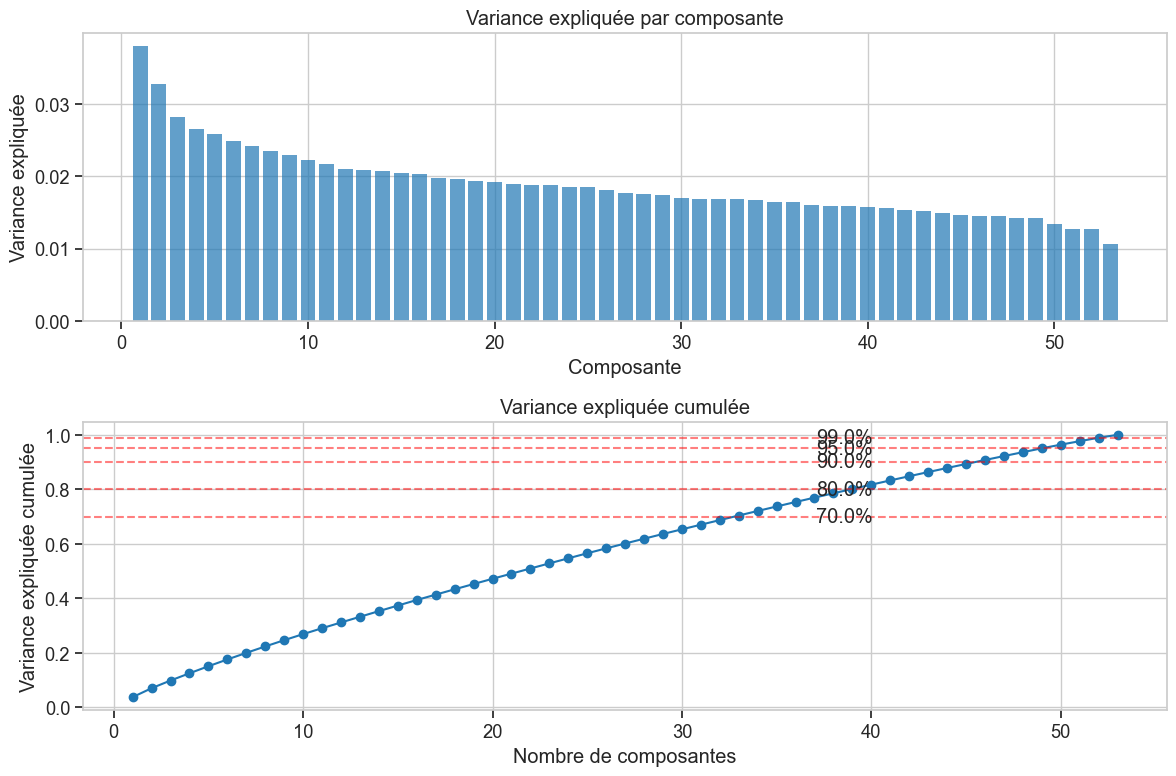

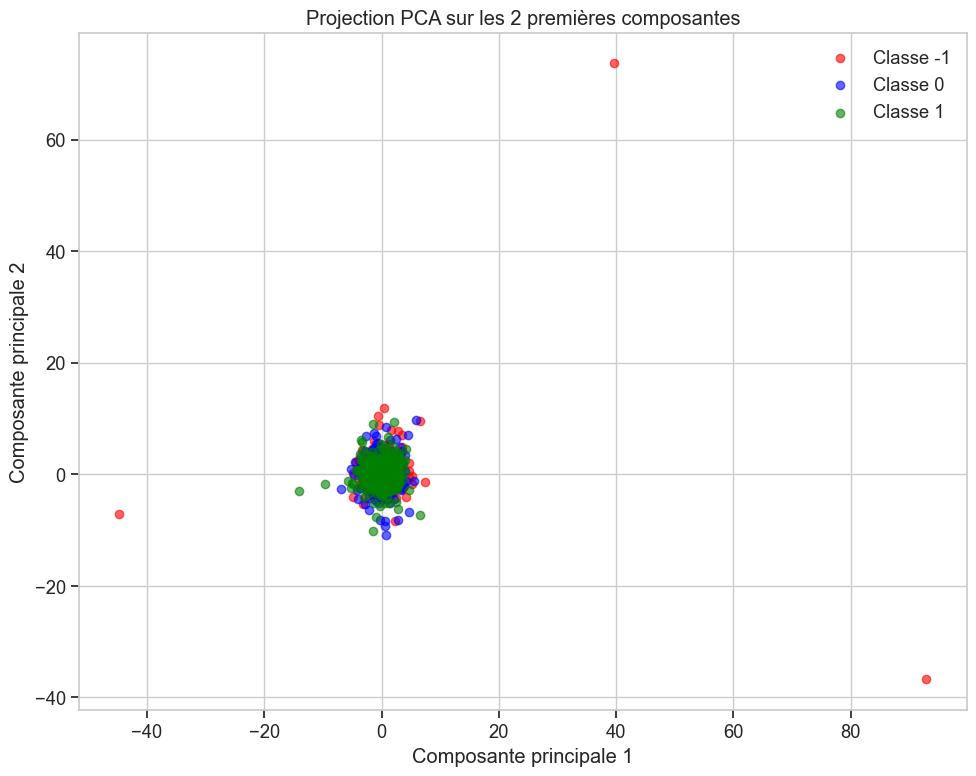

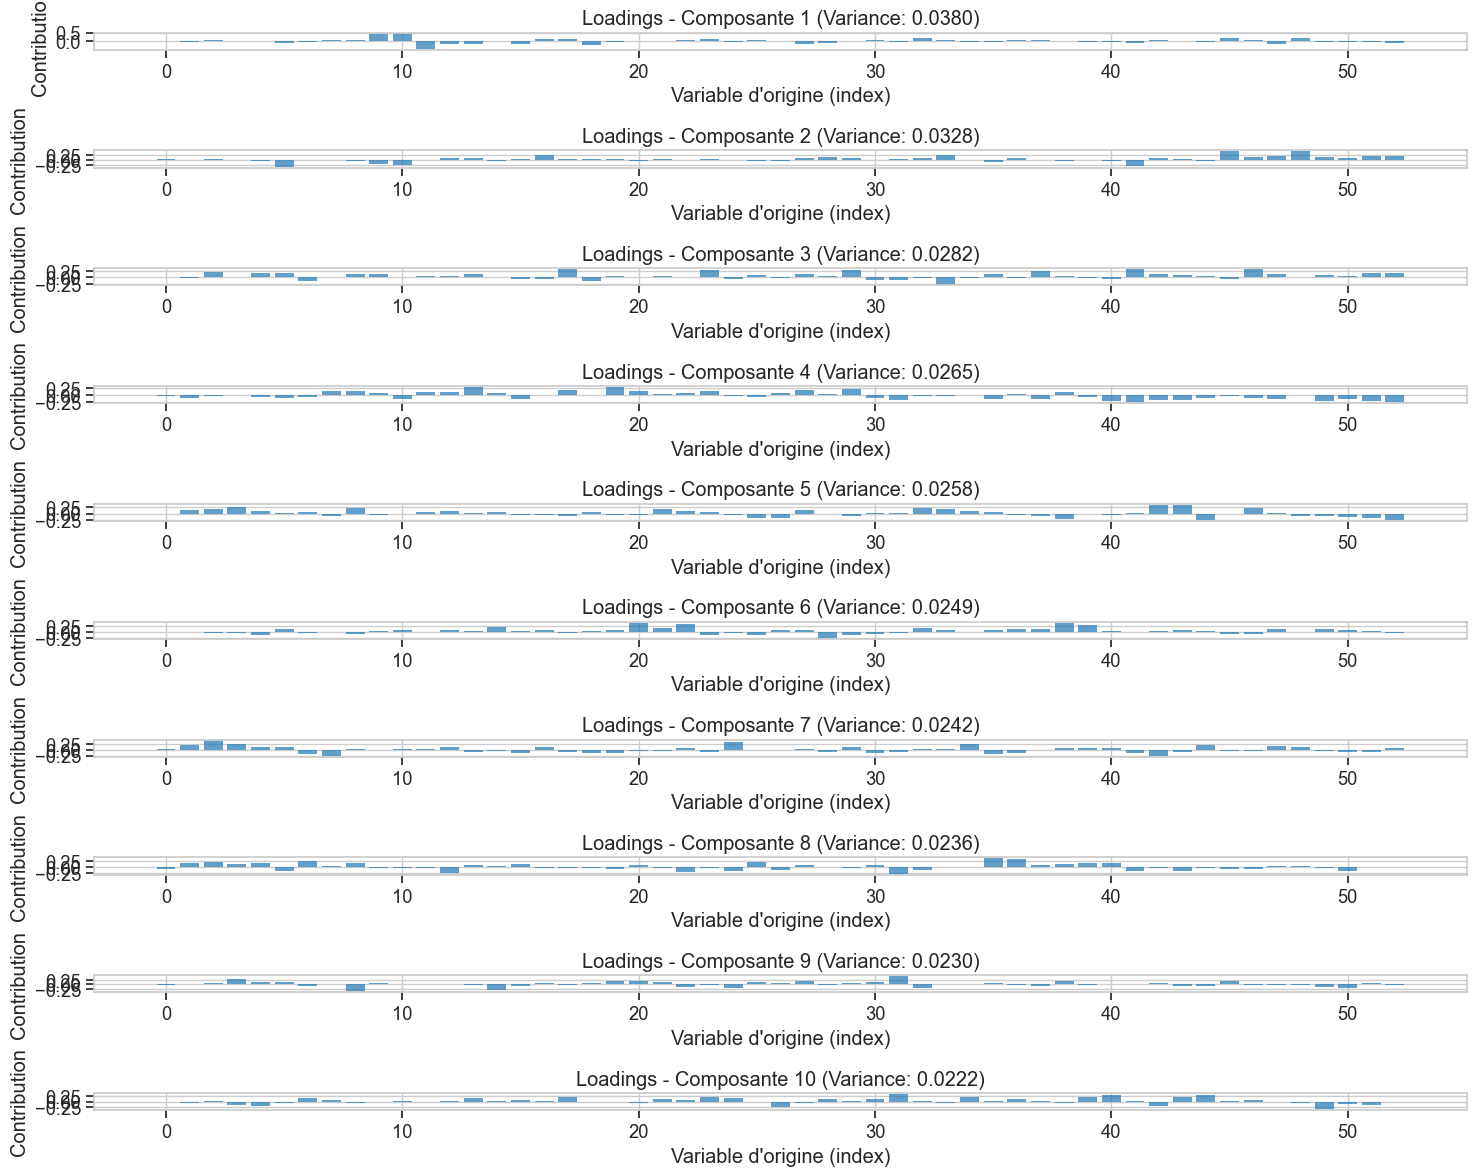


Variables les plus contributives par composante:

Composante 1:
  r10: 0.4589
  r11: -0.4507
  r9: 0.3953
  r18: -0.2124
  r32: 0.1906

Composante 2:
  r48: 0.4199
  r45: 0.4160
  r5: -0.3111
  r41: -0.2659
  r16: 0.2509

Composante 3:
  r46: 0.3223
  r17: 0.3188
  r41: 0.3170
  r23: 0.2972
  r29: 0.2809

Composante 4:
  r13: 0.3078
  r19: 0.2879
  r41: -0.2647
  r52: -0.2395
  r49: -0.2265

Composante 5:
  r42: 0.3516
  r43: 0.3217
  r44: -0.2661
  r3: 0.2641
  r52: -0.2484

Composante 6:
  r20: 0.4200
  r38: 0.3884
  r22: 0.3380
  r39: 0.3053
  r28: -0.2561

Composante 7:
  r2: 0.3996
  r24: 0.3089
  r7: -0.2643
  r42: -0.2639
  r3: 0.2446

Composante 8:
  r35: 0.3689
  r36: 0.3272
  r31: -0.2734
  r6: 0.2623
  r25: 0.2292

Composante 9:
  r31: 0.4444
  r8: -0.3797
  r3: 0.2887
  r14: -0.2697
  r50: -0.2084

Composante 10:
  r31: 0.3381
  r49: -0.3374
  r44: 0.3025
  r40: 0.3008
  r26: -0.2416


In [ ]:
# 5.3 Analyse en composantes principales (PCA)
print("\n--- Analyse en composantes principales (PCA) ---")

# Effectuer l'analyse PCA sur le dataset sélectionné
pca_results = perform_pca_analysis(dataset_key=best_dataset, sample_size=10000)


--- Analyse des corrélations entre features ---

Analyse des corrélations sur le dataset interp...
Temps de chargement: 3.23 secondes
Temps de calcul des corrélations: 0.23 secondes


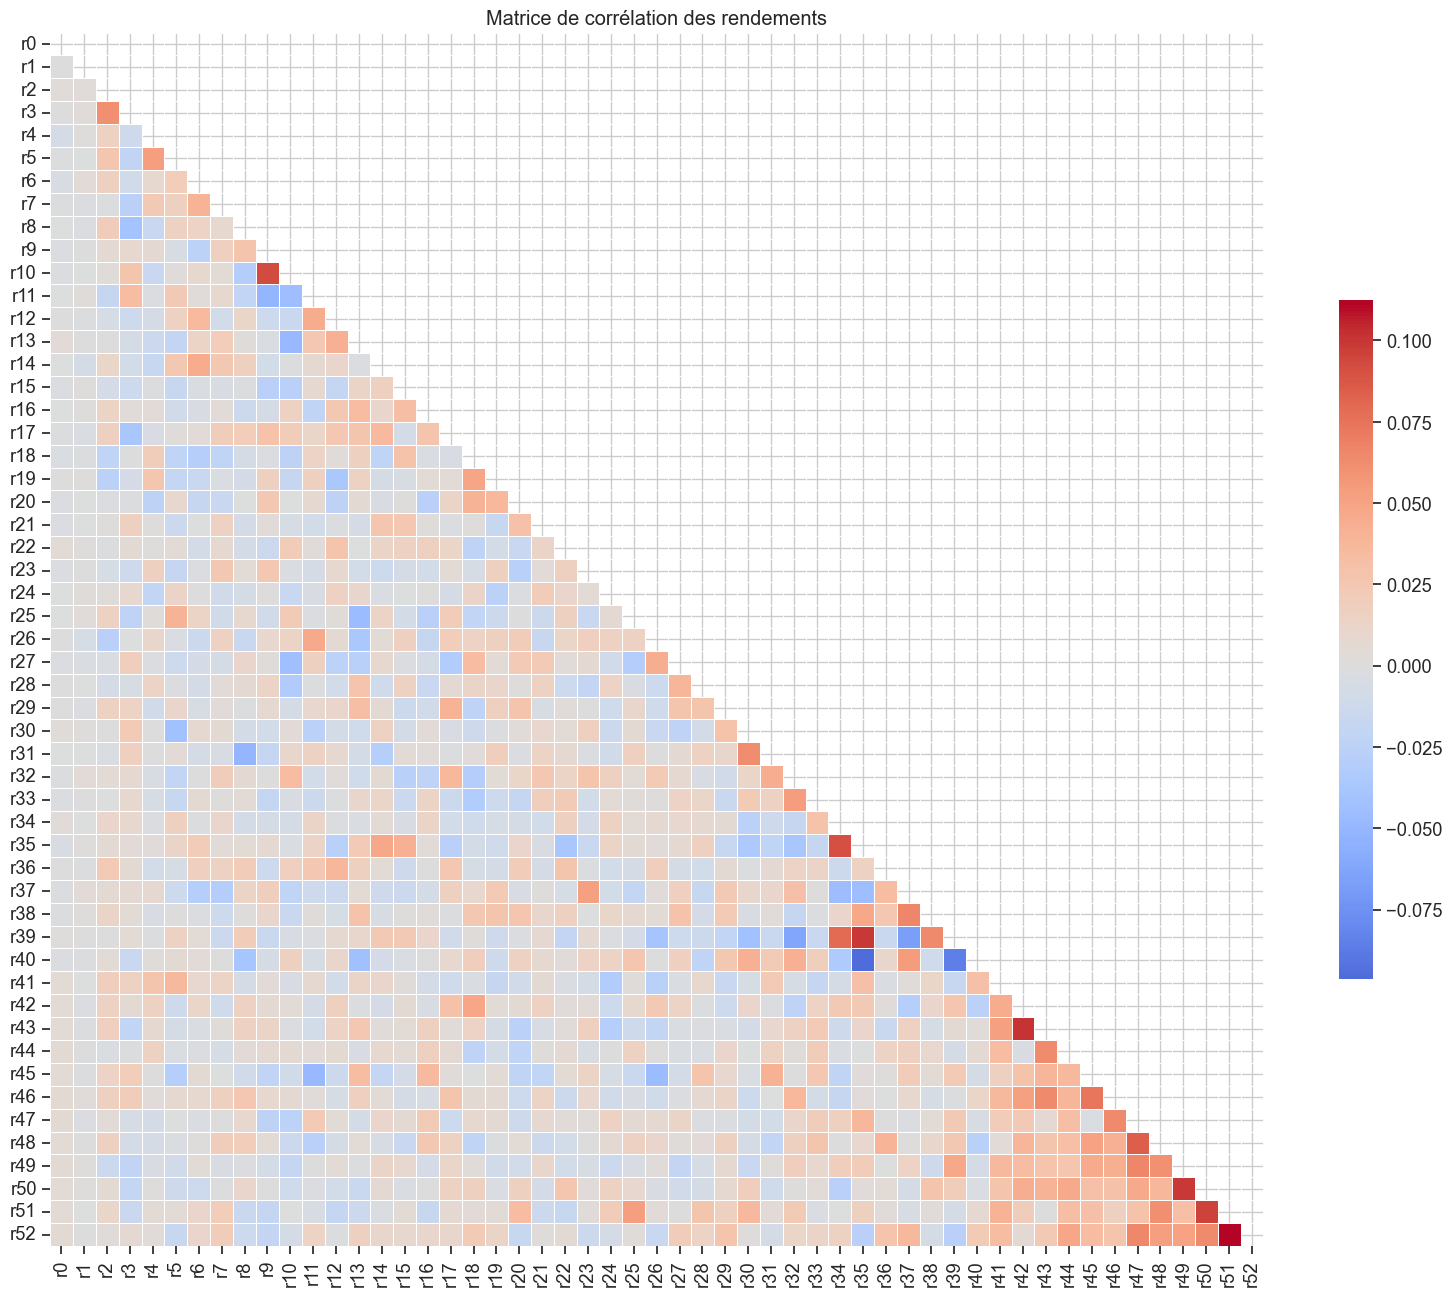


Paires de variables avec corrélation > 0.8:


Empty DataFrame
Columns: [Variable 1, Variable 2, Corrélation]
Index: []

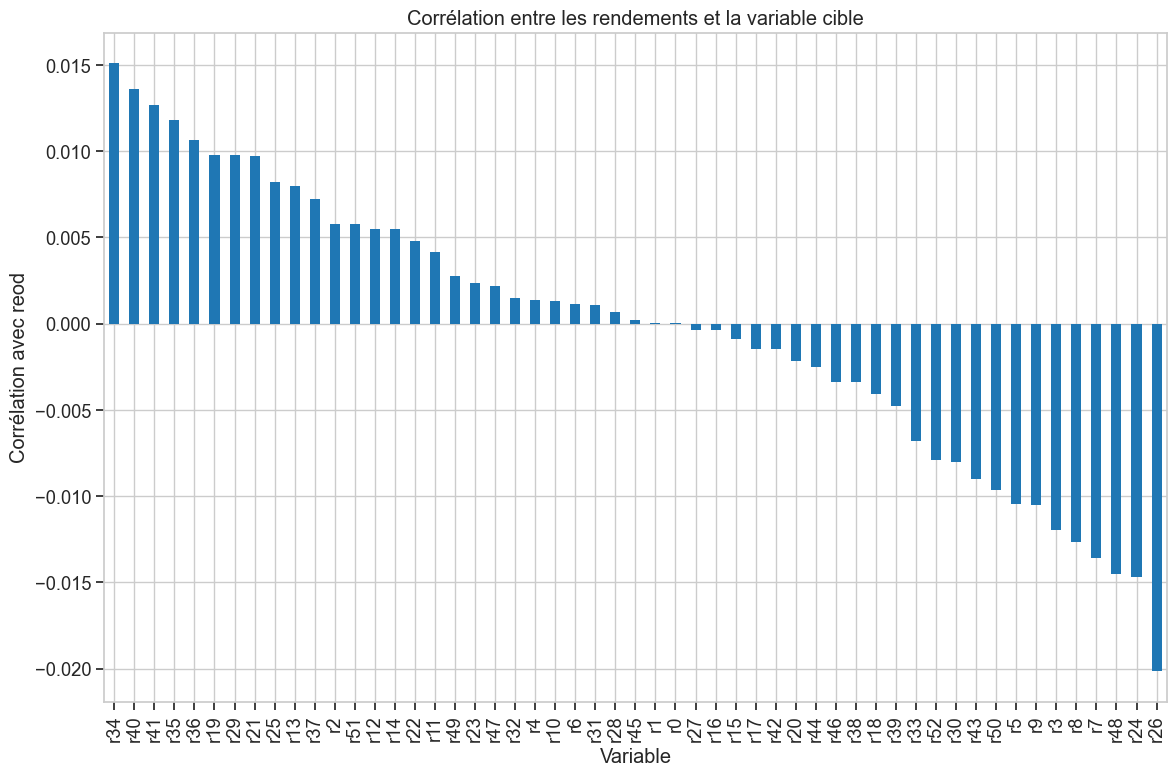


Variables les plus corrélées positivement avec la cible:


r34    0.015107
r40    0.013624
r41    0.012688
r35    0.011788
r36    0.010612
r19    0.009776
r29    0.009757
r21    0.009733
r25    0.008212
r13    0.007969
dtype: float64


Variables les plus corrélées négativement avec la cible:


r43   -0.008995
r50   -0.009670
r5    -0.010473
r9    -0.010490
r3    -0.011966
r8    -0.012662
r7    -0.013605
r48   -0.014489
r24   -0.014668
r26   -0.020143
dtype: float64

In [ ]:
# 5.4 Analyse des corrélations
print("\n--- Analyse des corrélations entre features ---")

# Analyser les corrélations
correlation_results = analyze_correlations(dataset_key=best_dataset)

In [ ]:
# 5.5 Ajout des features financières
print("\n--- Ajout de features financières avancées ---")

# Appliquer les features financières
X_train_with_financial = add_financial_features(X_train)
X_test_with_financial = add_financial_features(X_test)

# Afficher les nouvelles features
new_financial_features = [col for col in X_train_with_financial.columns if col not in X_train.columns]
print(f"Features financières ajoutées: {len(new_financial_features)}")
print("Top 10 nouvelles features:", ', '.join(new_financial_features[:10]))


--- Ajout de features financières avancées ---
Ajout de 8 nouvelles features financières
Ajout de 8 nouvelles features financières
Features financières ajoutées: 8
Top 10 nouvelles features: volatility_10, volatility_20, volatility_30, sharpe_ratio, momentum, trend_slope, pos_ratio, neg_ratio


In [ ]:
# 5.6 Sélection des features - Approche 1: Garder tous les rendements
print("\n--- Sélection des features - Approche 1: Conserver tous les rendements ---")

# Identifier les features de rendement
rendement_cols = [col for col in X_train.columns if col.startswith('r') and col[1:].isdigit()]
derived_cols = [col for col in X_train_with_financial.columns if col not in rendement_cols]

print(f"Nombre de features de rendement: {len(rendement_cols)}")
print(f"Nombre de features dérivées (y compris financières): {len(derived_cols)}")

# Utiliser l'information mutuelle pour sélectionner les features dérivées
X_derived = X_train_with_financial[derived_cols]
mi_results_derived = select_by_mutual_info(X_derived, y_train, top_n=20, plot=False)
selected_derived_features = mi_results_derived['selected_features'][:15]  # Top 15

# Afficher les features dérivées sélectionnées
print(f"\nTop 15 features dérivées sélectionnées:")
for i, feature in enumerate(selected_derived_features):
    print(f"{i+1}. {feature}")

# Combiner les rendements avec les features dérivées sélectionnées
approach1_features = rendement_cols + selected_derived_features
print(f"\nApproche 1: Total de {len(approach1_features)} features ({len(rendement_cols)} rendements + {len(selected_derived_features)} dérivées)")


--- Sélection des features - Approche 1: Conserver tous les rendements ---
Nombre de features de rendement: 53
Nombre de features dérivées (y compris financières): 10

Top 15 features dérivées sélectionnées:
1. day
2. equity
3. neg_ratio
4. pos_ratio
5. momentum
6. sharpe_ratio
7. volatility_20
8. trend_slope
9. volatility_30
10. volatility_10

Approche 1: Total de 63 features (53 rendements + 10 dérivées)



--- Sélection des features - Approche 2: Sélectionner parmi toutes les features ---


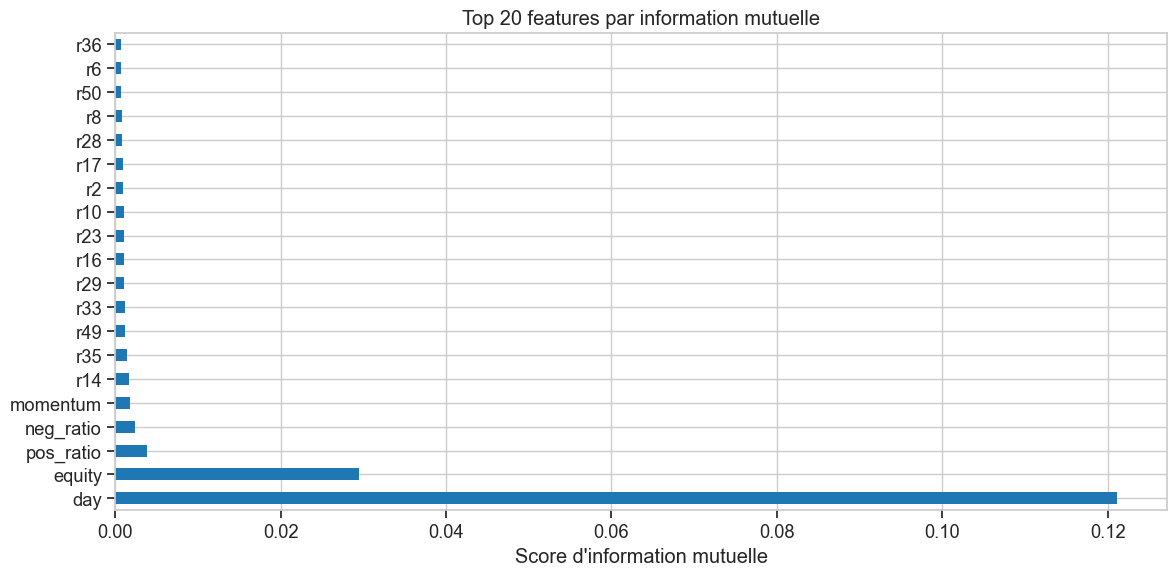

Top features par information mutuelle:
day          0.121095
equity       0.029436
pos_ratio    0.003825
neg_ratio    0.002380
momentum     0.001773
r14          0.001638
r35          0.001395
r49          0.001127
r33          0.001114
r29          0.001094
dtype: float64

Approche 2: Total de 30 features sélectionnées
Top 15 features:
1. day
2. equity
3. pos_ratio
4. neg_ratio
5. momentum
6. r14
7. r35
8. r49
9. r33
10. r29
11. r16
12. r23
13. r10
14. r2
15. r17


In [ ]:
# 5.7 Sélection des features - Approche 2: Sélectionner parmi toutes les features
print("\n--- Sélection des features - Approche 2: Sélectionner parmi toutes les features ---")

# Utiliser l'information mutuelle sur toutes les features
mi_results_all = select_by_mutual_info(X_train_with_financial, y_train, top_n=30, plot=True)
approach2_features = mi_results_all['selected_features'][:30]  # Top 30

print(f"\nApproche 2: Total de {len(approach2_features)} features sélectionnées")
print("Top 15 features:")
for i, feature in enumerate(approach2_features[:15]):
    print(f"{i+1}. {feature}")


--- Détermination du nombre optimal de features ---

Optimisation du nombre de features pour l'approche 2...


100%|██████████| 5/5 [02:39<00:00, 31.89s/it]


Nombre optimal de features: 20
Score de validation croisée: 0.4736 ± 0.0017


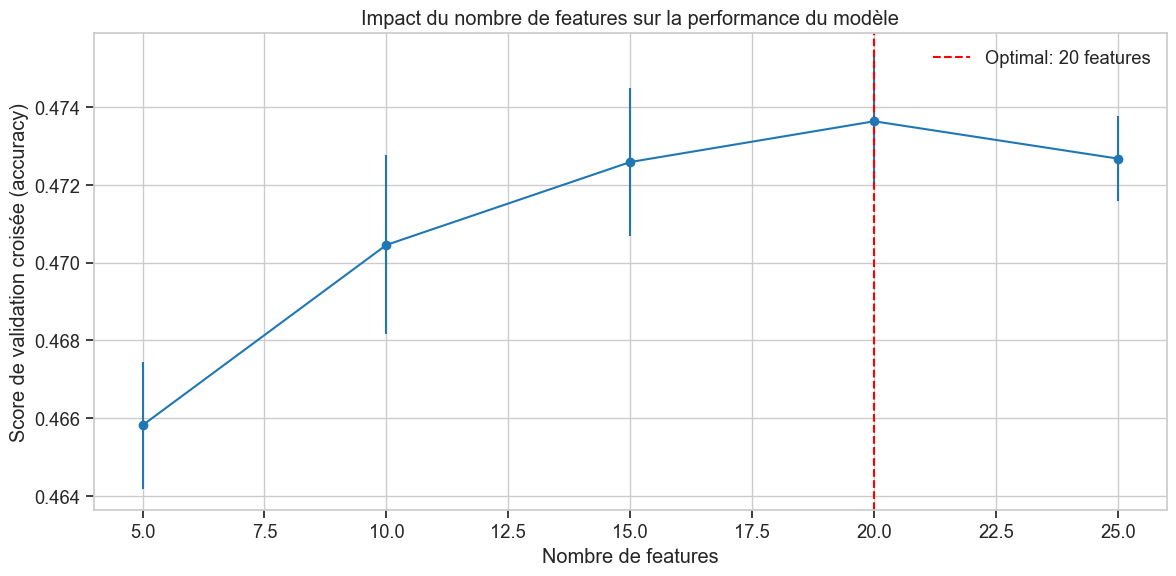


Nombre optimal de features: 20
Top 10 des features optimales:
1. day
2. equity
3. pos_ratio
4. neg_ratio
5. momentum
6. r14
7. r35
8. r49
9. r33
10. r29


In [ ]:
# 5.8 Détermination du nombre optimal de features
print("\n--- Détermination du nombre optimal de features ---")

# Définir une factory function pour XGBoost
def xgboost_factory():
    """Renvoie une nouvelle instance de XGBoost"""
    return XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        random_state=42
    )

# Mapping pour les étiquettes de classe
mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = y_train.map(mapping)

# Optimisation pour l'approche 2 (généralement plus performante)
feature_ranking = mi_results_all['selected_features']
print("\nOptimisation du nombre de features pour l'approche 2...")

# Pour éviter d'exécuter une optimisation coûteuse, on limite le nombre d'essais
optimization_result = optimize_feature_count(
    X_train_with_financial, y_train_mapped,  # Utiliser les classes mappées
    model_factory=xgboost_factory,
    feature_ranking=feature_ranking,
    n_features_range=range(5, min(101, len(feature_ranking)), 5)
)

# Récupérer le nombre optimal de features et les features correspondantes
optimal_n_features = optimization_result['optimal_n_features']
optimal_features = optimization_result['optimal_features']

print(f"\nNombre optimal de features: {optimal_n_features}")
print(f"Top 10 des features optimales:")
for i, feature in enumerate(optimal_features[:10]):
    print(f"{i+1}. {feature}")


In [ ]:
# 5.9 Optimisation des hyperparamètres de XGBoost
print("\n--- Optimisation des hyperparamètres de XGBoost ---")

# Définir la grille de paramètres pour XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Utiliser les features optimales pour l'optimisation des hyperparamètres
X_optimal = X_train_with_financial[optimal_features]
X_test_optimal = X_test_with_financial[optimal_features]

# Optimiser XGBoost avec les classes mappées
optimization_result = optimize_hyperparameters(
    xgboost_factory(),
    xgb_param_grid,
    X_optimal,
    y_train_mapped,  # Utiliser les classes mappées
    n_iter=10,  # Réduit pour des raisons de temps
    use_random=True
)

# Récupérer le meilleur modèle et ses paramètres
best_params = optimization_result["best_params"]
best_score = optimization_result["best_score"]

print(f"Meilleur score de validation croisée: {best_score:.4f}")
print("Meilleurs paramètres:")
for param, value in best_params.items():
    print(f"- {param}: {value}")



--- Optimisation des hyperparamètres de XGBoost ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Meilleur score de validation croisée: 0.4756
Temps d'optimisation: 515.06 secondes
Meilleur score de validation croisée: 0.4756
Meilleurs paramètres:
- subsample: 0.8
- n_estimators: 300
- max_depth: 7
- learning_rate: 0.1
- gamma: 0.1
- colsample_bytree: 0.5


In [ ]:
# 5.10 Évaluation du modèle XGBoost optimisé
print("\n--- Évaluation du modèle XGBoost optimisé ---")

# Créer le modèle XGBoost optimisé
optimized_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    random_state=42,
    **best_params
)

# Entraîner le modèle
start_train_time = time.time()
optimized_model.fit(X_optimal, y_train)
train_time = time.time() - start_train_time

# Faire des prédictions
start_pred_time = time.time()
y_pred = optimized_model.predict(X_test_optimal)
pred_time = time.time() - start_pred_time

# Évaluer les performances
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print(f"Accuracy sur l'ensemble de test: {accuracy:.4f}")
print(f"F1 score pondéré: {report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {train_time:.2f}s, Prédiction: {pred_time:.2f}s")

# Ajouter au tracker de résultats
result = {
    "dataset": best_dataset,
    "dataset_description": f"{best_configs[0]['description']} avec features optimisées",
    "model": "xgboost_optimized",
    "model_description": f"XGBoost optimisé avec {len(optimal_features)} features",
    "features_added": True,
    "feature_sets": ["Optimisées"],
    "normalize_by_row": best_normalize,
    "accuracy": accuracy,
    "precision_weighted": report["weighted avg"]["precision"],
    "recall_weighted": report["weighted avg"]["recall"],
    "f1_weighted": report["weighted avg"]["f1-score"],
    "training_time": train_time,
    "prediction_time": pred_time,
    "total_time": train_time + pred_time,
    "notes": f"Optimisé avec {optimal_n_features} features et hyperparamètres"
}

results_tracker = add_result(results_tracker, result)

# Matrice de confusion
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.title('Matrice de Confusion - XGBoost Optimisé')
plt.xlabel('Prédiction')
plt.ylabel('Valeur Réelle')
plt.tight_layout()
plt.show()

In [ ]:
# 5.11 Analyse SHAP pour interpréter le modèle
print("\n--- Analyse SHAP pour l'interprétation du modèle ---")

try:
    # Import shap if available
    import shap
    
    # Réduire l'échantillon pour l'analyse SHAP
    sample_size = min(500, len(X_optimal))
    X_train_sample = X_optimal.sample(sample_size, random_state=42)
    
    # Analyser le modèle avec SHAP
    shap_values, explainer = analyze_with_shap(optimized_model, X_train_sample)
    
    if shap_values is not None:
        # Visualiser le résumé des valeurs SHAP (Bar Plot)
        plot_shap_summary(shap_values, X_train_sample, plot_type="bar")
        
        # Visualiser l'impact détaillé des features (Dot Plot)
        plot_shap_summary(shap_values, X_train_sample, plot_type="dot")
        
        print("Analyse SHAP complétée avec succès")
    else:
        print("Impossible de calculer les valeurs SHAP")
        
except ImportError:
    print("La bibliothèque SHAP n'est pas installée. Utilisez 'pip install shap' pour l'installer.")
except Exception as e:
    print(f"Erreur lors de l'analyse SHAP: {e}")

In [ ]:
# 5.12 Comparaison avec le modèle de référence
print("\n--- Comparaison avec le modèle de référence ---")

# Récupérer les performances du meilleur modèle de référence
benchmark_model = next((r for r in results_tracker.to_dict('records') 
                        if r['dataset'] == best_dataset and 
                        r['model'] == 'xgboost_baseline' and 
                        r['normalize_by_row'] == best_normalize), None)

if benchmark_model:
    benchmark_accuracy = benchmark_model["accuracy"]
    improvement = accuracy - benchmark_accuracy
    
    print(f"Modèle de référence (XGBoost baseline): Accuracy = {benchmark_accuracy:.4f}")
    print(f"Modèle optimisé (XGBoost optimisé): Accuracy = {accuracy:.4f}")
    print(f"Amélioration: {improvement:.4f} ({improvement*100:.2f}%)")
    
    # Visualiser la comparaison
    plt.figure(figsize=(10, 6))
    comparison_data = pd.DataFrame([
        {"Modèle": "XGBoost baseline", "Accuracy": benchmark_accuracy},
        {"Modèle": "XGBoost optimisé", "Accuracy": accuracy}
    ])
    sns.barplot(x="Modèle", y="Accuracy", data=comparison_data)
    plt.title('Comparaison des performances XGBoost baseline vs optimisé')
    plt.ylim(0.4, 0.5)  # Ajuster selon les valeurs réelles
    plt.grid(axis='y')
    
    # Ajouter les valeurs sur les barres
    for i, row in comparison_data.iterrows():
        plt.text(i, row["Accuracy"] + 0.005, f"{row['Accuracy']:.4f}", 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Impossible de trouver un modèle de référence comparable pour la comparaison.")

## 6. Modèles non supervisés
# 
# Explorons maintenant des approches non supervisées pour améliorer la classification.

In [ ]:
# 6.1 Préparation des données
print("\n--- Préparation des données pour les modèles non supervisés ---")

# Utiliser le meilleur dataset et les features optimales identifiées précédemment
print(f"Utilisation du dataset {best_dataset} avec {optimal_n_features} features optimales")

# Normaliser les données pour les méthodes de clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_optimal)
X_test_scaled = scaler.transform(X_test_optimal)

In [ ]:
# 6.2 Réduction de dimensionnalité avec PCA
print("\n--- Réduction de dimensionnalité avec PCA ---")

# Appliquer PCA
n_components = min(15, X_scaled.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Analyser la variance expliquée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Visualiser la variance expliquée
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8)
plt.title('Variance expliquée par composante')
plt.xlabel('Composante principale')
plt.ylabel('Ratio de variance expliquée')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', markersize=8)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% de variance')
plt.title('Variance expliquée cumulée')
plt.xlabel('Nombre de composantes')
plt.ylabel('Ratio de variance expliquée cumulée')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Déterminer le nombre optimal de composantes pour expliquer 90% de la variance
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Nombre de composantes pour expliquer 90% de la variance: {n_components_90}")

In [ ]:
# 6.3 Modèle non supervisé 1: K-Means
print("\n--- Modèle non supervisé 1: K-Means ---")

# Déterminer le nombre optimal de clusters avec la méthode du coude
inertia_values = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)
    
    # Calculer le score silhouette
    from sklearn.metrics import silhouette_score
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))
    
# Visualiser la méthode du coude et les scores silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values, 'o-', markersize=8)
plt.title('Méthode du coude pour K-Means')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-', markersize=8)
plt.title('Score silhouette pour K-Means')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score silhouette')
plt.grid(True)
plt.tight_layout()
plt.show()

# Choisir le nombre optimal de clusters
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Nombre optimal de clusters selon le score silhouette: {optimal_k}")

# Entraîner K-Means avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

In [ ]:
# 6.4 Visualisation des clusters et relation avec les classes
print("\n--- Visualisation des clusters K-Means ---")

# Visualiser les clusters dans l'espace des 2 premières composantes
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
for cluster in range(optimal_k):
    plt.scatter(X_pca[cluster_labels == cluster, 0], X_pca[cluster_labels == cluster, 1], 
                label=f'Cluster {cluster}', alpha=0.7)
plt.title('Clustering K-Means dans l\'espace PCA')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.grid(True)

# Visualiser les classes réelles dans l'espace PCA
plt.subplot(2, 1, 2)
for cls in sorted(np.unique(y_train)):
    plt.scatter(X_pca[y_train == cls, 0], X_pca[y_train == cls, 1], 
                label=f'Classe {cls}', alpha=0.7)
plt.title('Classes réelles dans l\'espace PCA')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyser la correspondance entre clusters et classes
print("\n--- Correspondance entre clusters et classes ---")

# Créer une table de contingence
contingency_table = pd.DataFrame(
    confusion_matrix(y_train, cluster_labels),
    index=[f'Classe {cls}' for cls in sorted(np.unique(y_train))],
    columns=[f'Cluster {i}' for i in range(optimal_k)]
)

print("Table de contingence (lignes: classes réelles, colonnes: clusters):")
display(contingency_table)

# Visualiser la table de contingence
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Correspondance entre clusters et classes')
plt.tight_layout()
plt.show()

In [ ]:
# 6.5 Utilisation des clusters comme features pour la classification
print("\n--- Utilisation des clusters comme features pour la classification ---")

# Ajouter les clusters comme features aux données d'origine
X_with_clusters = np.column_stack((X_optimal, cluster_labels))
X_test_clusters = np.column_stack((X_test_optimal, kmeans.predict(X_test_pca)))

# Créer des noms pour les nouvelles features
all_feature_names = list(X_optimal.columns) + ['cluster_assignment']

# Entraîner un modèle XGBoost avec les clusters comme features supplémentaires
kmeans_xgb = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42, **best_params)
start_time = time.time()
kmeans_xgb.fit(X_with_clusters, y_train)
train_time = time.time() - start_time

# Évaluation
start_time = time.time()
y_pred_kmeans = kmeans_xgb.predict(X_test_clusters)
pred_time = time.time() - start_time

accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)
report_kmeans = classification_report(y_test, y_pred_kmeans, output_dict=True)

print(f"Accuracy avec clusters comme features: {accuracy_kmeans:.4f}")
print(f"F1 score pondéré: {report_kmeans['weighted avg']['f1-score']:.4f}")

# Ajouter au tracker de résultats
result_kmeans = {
    "dataset": best_dataset,
    "dataset_description": f"{best_configs[0]['description']} avec features optimisées + K-Means",
    "model": "xgboost_kmeans",
    "model_description": "XGBoost avec clusters K-Means comme features",
    "features_added": True,
    "feature_sets": ["Optimisées + K-Means"],
    "normalize_by_row": best_normalize,
    "accuracy": accuracy_kmeans,
    "precision_weighted": report_kmeans["weighted avg"]["precision"],
    "recall_weighted": report_kmeans["weighted avg"]["recall"],
    "f1_weighted": report_kmeans["weighted avg"]["f1-score"],
    "training_time": train_time,
    "prediction_time": pred_time,
    "total_time": train_time + pred_time,
    "notes": f"K-Means avec {optimal_k} clusters sur {n_components_90} composantes PCA"
}

results_tracker = add_result(results_tracker, result_kmeans)

In [ ]:
# 6.6 Modèle non supervisé 2: DBSCAN
print("\n--- Modèle non supervisé 2: DBSCAN ---")

from sklearn.neighbors import NearestNeighbors

# Déterminer le eps optimal avec la méthode du coude pour les k plus proches voisins
k = min(15, len(X_pca) - 1)
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_pca)
distances, indices = neigh.kneighbors(X_pca)

# Trier les distances au kème voisin
sorted_distances = np.sort(distances[:, k-1])

# Visualiser la courbe pour déterminer eps
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_distances)), sorted_distances, 'o-', markersize=3)
plt.title('Méthode du coude pour déterminer eps dans DBSCAN')
plt.xlabel('Points triés par distance')
plt.ylabel(f'Distance au {k}ème voisin')
plt.grid(True)
plt.tight_layout()
plt.show()

# Choisir eps et min_samples
eps = np.percentile(sorted_distances, 90)  # Valeur où il y a un "coude"
min_samples = 5  # Valeur typique

print(f"Paramètres DBSCAN choisis: eps={eps:.4f}, min_samples={min_samples}")

# Appliquer DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_pca)

# Nombre de clusters trouvés (excluant le bruit)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Nombre de clusters trouvés: {n_clusters_dbscan}")
print(f"Nombre de points de bruit: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")

In [ ]:
# 6.7 Visualisation des clusters DBSCAN
print("\n--- Visualisation des clusters DBSCAN ---")

# Visualiser les clusters dans l'espace des 2 premières composantes
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters_dbscan + 1))

# Points de bruit en noir
plt.scatter(X_pca[dbscan_labels == -1, 0], X_pca[dbscan_labels == -1, 1], 
            c='black', marker='x', label='Bruit', alpha=0.7)

# Clusters
for i, color in zip(range(n_clusters_dbscan), colors):
    plt.scatter(X_pca[dbscan_labels == i, 0], X_pca[dbscan_labels == i, 1], 
                c=color.reshape(1, -1), label=f'Cluster {i}', alpha=0.7)

plt.title('Clustering DBSCAN dans l\'espace PCA')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 6.8 DBSCAN comme feature pour la classification
print("\n--- Utilisation de DBSCAN comme feature pour la classification ---")

# Ajouter DBSCAN comme feature
X_with_dbscan = np.column_stack((X_optimal, dbscan_labels))

# Prédire les clusters pour les données de test
# Note: DBSCAN n'a pas de méthode predict()
from sklearn.neighbors import KNeighborsClassifier

# Entraîner un KNN sur les labels DBSCAN pour "simuler" une prédiction
knn_for_dbscan = KNeighborsClassifier(n_neighbors=5)
# Exclure les points de bruit pour l'entraînement
non_noise_idx = (dbscan_labels != -1)
if sum(non_noise_idx) > 0:  # S'il y a des points non-bruit
    knn_for_dbscan.fit(X_pca[non_noise_idx], dbscan_labels[non_noise_idx])
    dbscan_pred = knn_for_dbscan.predict(X_test_pca)
else:
    # Si tous les points sont considérés comme du bruit, considérer que tout est du bruit
    dbscan_pred = np.full(X_test_pca.shape[0], -1)

X_test_dbscan = np.column_stack((X_test_optimal, dbscan_pred))

# Entraîner un modèle XGBoost avec DBSCAN comme feature
dbscan_xgb = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42, **best_params)
start_time = time.time()
dbscan_xgb.fit(X_with_dbscan, y_train)
train_time = time.time() - start_time

# Évaluation
start_time = time.time()
y_pred_dbscan = dbscan_xgb.predict(X_test_dbscan)
pred_time = time.time() - start_time

accuracy_dbscan = accuracy_score(y_test, y_pred_dbscan)
report_dbscan = classification_report(y_test, y_pred_dbscan, output_dict=True)

print(f"Accuracy avec DBSCAN comme feature: {accuracy_dbscan:.4f}")
print(f"F1 score pondéré: {report_dbscan['weighted avg']['f1-score']:.4f}")

# Ajouter au tracker de résultats
result_dbscan = {
    "dataset": best_dataset,
    "dataset_description": f"{best_configs[0]['description']} avec features optimisées + DBSCAN",
    "model": "xgboost_dbscan",
    "model_description": "XGBoost avec clusters DBSCAN comme features",
    "features_added": True,
    "feature_sets": ["Optimisées + DBSCAN"],
    "normalize_by_row": best_normalize,
    "accuracy": accuracy_dbscan,
    "precision_weighted": report_dbscan["weighted avg"]["precision"],
    "recall_weighted": report_dbscan["weighted avg"]["recall"],
    "f1_weighted": report_dbscan["weighted avg"]["f1-score"],
    "training_time": train_time,
    "prediction_time": pred_time,
    "total_time": train_time + pred_time,
    "notes": f"DBSCAN avec eps={eps:.4f}, min_samples={min_samples}, {n_clusters_dbscan} clusters"
}

results_tracker = add_result(results_tracker, result_dbscan)

In [ ]:
# 6.9 Comparaison des modèles non supervisés
print("\n--- Comparaison des modèles non supervisés ---")

# Créer un DataFrame pour la comparaison
comparison_df = pd.DataFrame([
    {"Modèle": "XGBoost optimisé", "Accuracy": accuracy, "F1 score": report['weighted avg']['f1-score']},
    {"Modèle": "XGBoost + K-Means", "Accuracy": accuracy_kmeans, "F1 score": report_kmeans['weighted avg']['f1-score']},
    {"Modèle": "XGBoost + DBSCAN", "Accuracy": accuracy_dbscan, "F1 score": report_dbscan['weighted avg']['f1-score']}
])

# Afficher le tableau de comparaison
print("Comparaison des performances:")
display(comparison_df)

# Visualiser la comparaison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x="Modèle", y="Accuracy", data=comparison_df)
plt.title('Comparaison des Accuracy')
plt.ylim(0.4, 0.5)  # Ajuster selon les valeurs réelles
plt.grid(axis='y')

plt.subplot(1, 2, 2)
sns.barplot(x="Modèle", y="F1 score", data=comparison_df)
plt.title('Comparaison des F1 scores')
plt.ylim(0.4, 0.5)  # Ajuster selon les valeurs réelles
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## 7. Modèles supervisés avancés
# 
# Explorons maintenant des modèles supervisés plus avancés pour améliorer la classification.

In [ ]:
# 7.1 Modèle supervisé 1: Random Forest
print("\n--- Modèle supervisé 1: Random Forest ---")

# Définir la grille de paramètres pour Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Optimiser les hyperparamètres de Random Forest
print("\nOptimisation des hyperparamètres pour Random Forest...")
rf_opt_result = optimize_hyperparameters(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    X_optimal,
    y_train,
    n_iter=10,  # Réduit pour des raisons de temps
    use_random=True
)

# Extraire le meilleur modèle et ses paramètres
rf_best_params = rf_opt_result["best_params"]
rf_best_score = rf_opt_result["best_score"]

print(f"Meilleur score de validation croisée: {rf_best_score:.4f}")
print("Meilleurs paramètres pour Random Forest:")
for param, value in rf_best_params.items():
    print(f"- {param}: {value}")

# Créer le modèle optimisé
rf_model = RandomForestClassifier(random_state=42, **rf_best_params)

# Entraîner le modèle
start_time = time.time()
rf_model.fit(X_optimal, y_train)
rf_train_time = time.time() - start_time

# Faire des prédictions
start_time = time.time()
rf_pred = rf_model.predict(X_test_optimal)
rf_pred_time = time.time() - start_time

# Évaluer les performances
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred, output_dict=True)

print(f"\nPerformances du modèle Random Forest:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 score pondéré: {rf_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {rf_train_time:.2f}s, Prédiction: {rf_pred_time:.2f}s")

# Ajouter au tracker de résultats
result_rf = {
    "dataset": best_dataset,
    "dataset_description": f"{best_configs[0]['description']} avec features optimisées",
    "model": "random_forest_optimized",
    "model_description": "Random Forest optimisé",
    "features_added": True,
    "feature_sets": ["Optimisées"],
    "normalize_by_row": best_normalize,
    "accuracy": rf_accuracy,
    "precision_weighted": rf_report["weighted avg"]["precision"],
    "recall_weighted": rf_report["weighted avg"]["recall"],
    "f1_weighted": rf_report["weighted avg"]["f1-score"],
    "training_time": rf_train_time,
    "prediction_time": rf_pred_time,
    "total_time": rf_train_time + rf_pred_time,
    "notes": f"Random Forest optimisé avec {optimal_n_features} features"
}

results_tracker = add_result(results_tracker, result_rf)

In [ ]:
# 7.2 Modèle supervisé 2: Gradient Boosting
print("\n--- Modèle supervisé 2: Gradient Boosting ---")

# Définir la grille de paramètres pour Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Optimiser les hyperparamètres de Gradient Boosting
print("\nOptimisation des hyperparamètres pour Gradient Boosting...")
gb_opt_result = optimize_hyperparameters(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    X_optimal,
    y_train,
    n_iter=10,  # Réduit pour des raisons de temps
    use_random=True
)

# Extraire le meilleur modèle et ses paramètres
gb_best_params = gb_opt_result["best_params"]
gb_best_score = gb_opt_result["best_score"]

print(f"Meilleur score de validation croisée: {gb_best_score:.4f}")
print("Meilleurs paramètres pour Gradient Boosting:")
for param, value in gb_best_params.items():
    print(f"- {param}: {value}")

# Créer le modèle optimisé
gb_model = GradientBoostingClassifier(random_state=42, **gb_best_params)

# Entraîner le modèle
start_time = time.time()
gb_model.fit(X_optimal, y_train)
gb_train_time = time.time() - start_time

# Faire des prédictions
start_time = time.time()
gb_pred = gb_model.predict(X_test_optimal)
gb_pred_time = time.time() - start_time

# Évaluer les performances
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_report = classification_report(y_test, gb_pred, output_dict=True)

print(f"\nPerformances du modèle Gradient Boosting:")
print(f"Accuracy: {gb_accuracy:.4f}")
print(f"F1 score pondéré: {gb_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {gb_train_time:.2f}s, Prédiction: {gb_pred_time:.2f}s")

# Ajouter au tracker de résultats
result_gb = {
    "dataset": best_dataset,
    "dataset_description": f"{best_configs[0]['description']} avec features optimisées",
    "model": "gradient_boosting_optimized",
    "model_description": "Gradient Boosting optimisé",
    "features_added": True,
    "feature_sets": ["Optimisées"],
    "normalize_by_row": best_normalize,
    "accuracy": gb_accuracy,
    "precision_weighted": gb_report["weighted avg"]["precision"],
    "recall_weighted": gb_report["weighted avg"]["recall"],
    "f1_weighted": gb_report["weighted avg"]["f1-score"],
    "training_time": gb_train_time,
    "prediction_time": gb_pred_time,
    "total_time": gb_train_time + gb_pred_time,
    "notes": f"Gradient Boosting optimisé avec {optimal_n_features} features"
}

results_tracker = add_result(results_tracker, result_gb)

In [ ]:
# 7.3 Modèle supervisé 3: SVM
print("\n--- Modèle supervisé 3: SVM ---")

# Définir la grille de paramètres pour SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None]
}

# Optimiser les hyperparamètres de SVM sur un échantillon réduit
sample_size = min(5000, len(X_optimal))
X_sample = X_optimal.iloc[:sample_size]
y_sample = y_train.iloc[:sample_size]

print("\nOptimisation des hyperparamètres pour SVM (sur échantillon réduit)...")
svm_opt_result = optimize_hyperparameters(
    SVC(random_state=42, probability=True),
    svm_param_grid,
    X_sample,
    y_sample,
    n_iter=10,  # Réduit pour des raisons de temps
    use_random=True
)

# Extraire le meilleur modèle et ses paramètres
svm_best_params = svm_opt_result["best_params"]
svm_best_score = svm_opt_result["best_score"]

print(f"Meilleur score de validation croisée: {svm_best_score:.4f}")
print("Meilleurs paramètres pour SVM:")
for param, value in svm_best_params.items():
    print(f"- {param}: {value}")

# Créer le modèle optimisé
svm_model = SVC(random_state=42, probability=True, **svm_best_params)

# Entraîner le modèle
start_time = time.time()
svm_model.fit(X_optimal, y_train)
svm_train_time = time.time() - start_time

# Faire des prédictions
start_time = time.time()
svm_pred = svm_model.predict(X_test_optimal)
svm_pred_time = time.time() - start_time

# Évaluer les performances
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_report = classification_report(y_test, svm_pred, output_dict=True)

print(f"\nPerformances du modèle SVM:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"F1 score pondéré: {svm_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {svm_train_time:.2f}s, Prédiction: {svm_pred_time:.2f}s")

# Ajouter au tracker de résultats
result_svm = {
    "dataset": best_dataset,
    "dataset_description": f"{best_configs[0]['description']} avec features optimisées",
    "model": "svm_optimized",
    "model_description": "SVM optimisé",
    "features_added": True,
    "feature_sets": ["Optimisées"],
    "normalize_by_row": best_normalize,
    "accuracy": svm_accuracy,
    "precision_weighted": svm_report["weighted avg"]["precision"],
    "recall_weighted": svm_report["weighted avg"]["recall"],
    "f1_weighted": svm_report["weighted avg"]["f1-score"],
    "training_time": svm_train_time,
    "prediction_time": svm_pred_time,
    "total_time": svm_train_time + svm_pred_time,
    "notes": f"SVM optimisé avec {optimal_n_features} features"
}

results_tracker = add_result(results_tracker, result_svm)

In [ ]:
# 7.4 Modèle ensembliste: Stacking
print("\n--- Modèle ensembliste: Stacking ---")

# Utiliser LogisticRegression comme meta-classifier
meta_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Créer les estimateurs de base
base_estimators = [
    ('xgb', XGBClassifier(objective="multi:softmax", num_class=3, random_state=42, **best_params)),
    ('rf', RandomForestClassifier(random_state=42, **rf_best_params)),
    ('gb', GradientBoostingClassifier(random_state=42, **gb_best_params))
]

# Créer le modèle de stacking
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_classifier,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

# Entraîner le modèle
start_time = time.time()
stacking_model.fit(X_optimal, y_train)
stacking_train_time = time.time() - start_time

# Faire des prédictions
start_time = time.time()
stacking_pred = stacking_model.predict(X_test_optimal)
stacking_pred_time = time.time() - start_time

# Évaluer les performances
stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_report = classification_report(y_test, stacking_pred, output_dict=True)

print(f"\nPerformances du modèle Stacking:")
print(f"Accuracy: {stacking_accuracy:.4f}")
print(f"F1 score pondéré: {stacking_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {stacking_train_time:.2f}s, Prédiction: {stacking_pred_time:.2f}s")

# Ajouter au tracker de résultats
result_stacking = {
    "dataset": best_dataset,
    "dataset_description": f"{best_configs[0]['description']} avec features optimisées",
    "model": "stacking_ensemble",
    "model_description": "Stacking (XGBoost, RF, GB)",
    "features_added": True,
    "feature_sets": ["Optimisées"],
    "normalize_by_row": best_normalize,
    "accuracy": stacking_accuracy,
    "precision_weighted": stacking_report["weighted avg"]["precision"],
    "recall_weighted": stacking_report["weighted avg"]["recall"],
    "f1_weighted": stacking_report["weighted avg"]["f1-score"],
    "training_time": stacking_train_time,
    "prediction_time": stacking_pred_time,
    "total_time": stacking_train_time + stacking_pred_time,
    "notes": f"Stacking de XGBoost, Random Forest et Gradient Boosting"
}

results_tracker = add_result(results_tracker, result_stacking)

In [ ]:
# 7.5 Modèle ensembliste: Voting
print("\n--- Modèle ensembliste: Voting ---")

# Créer les estimateurs de base
estimators = [
    ('xgb', XGBClassifier(objective="multi:softmax", num_class=3, random_state=42, **best_params)),
    ('rf', RandomForestClassifier(random_state=42, **rf_best_params)),
    ('gb', GradientBoostingClassifier(random_state=42, **gb_best_params))
]

# Créer le modèle de vote
voting_model = VotingClassifier(
    estimators=estimators,
    voting='soft',  # Utiliser les probabilités pour le vote
    n_jobs=-1
)

# Entraîner le modèle
start_time = time.time()
voting_model.fit(X_optimal, y_train)
voting_train_time = time.time() - start_time

# Faire des prédictions
start_time = time.time()
voting_pred = voting_model.predict(X_test_optimal)
voting_pred_time = time.time() - start_time

# Évaluer les performances
voting_accuracy = accuracy_score(y_test, voting_pred)
voting_report = classification_report(y_test, voting_pred, output_dict=True)

print(f"\nPerformances du modèle Voting:")
print(f"Accuracy: {voting_accuracy:.4f}")
print(f"F1 score pondéré: {voting_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {voting_train_time:.2f}s, Prédiction: {voting_pred_time:.2f}s")

# Ajouter au tracker de résultats
result_voting = {
    "dataset": best_dataset,
    "dataset_description": f"{best_configs[0]['description']} avec features optimisées",
    "model": "voting_ensemble",
    "model_description": "Voting (XGBoost, RF, GB)",
    "features_added": True,
    "feature_sets": ["Optimisées"],
    "normalize_by_row": best_normalize,
    "accuracy": voting_accuracy,
    "precision_weighted": voting_report["weighted avg"]["precision"],
    "recall_weighted": voting_report["weighted avg"]["recall"],
    "f1_weighted": voting_report["weighted avg"]["f1-score"],
    "training_time": voting_train_time,
    "prediction_time": voting_pred_time,
    "total_time": voting_train_time + voting_pred_time,
    "notes": f"Voting de XGBoost, Random Forest et Gradient Boosting"
}

results_tracker = add_result(results_tracker, result_voting)

In [ ]:
# 7.6 Comparaison des modèles supervisés
print("\n--- Comparaison des modèles supervisés ---")

# Créer un DataFrame pour la comparaison
comparison_sup_df = pd.DataFrame([
    {"Modèle": "XGBoost optimisé", "Accuracy": accuracy, "F1 score": report['weighted avg']['f1-score'], 
     "Temps d'entraînement": train_time, "Temps total": train_time + pred_time},
    {"Modèle": "Random Forest", "Accuracy": rf_accuracy, "F1 score": rf_report['weighted avg']['f1-score'], 
     "Temps d'entraînement": rf_train_time, "Temps total": rf_train_time + rf_pred_time},
    {"Modèle": "Gradient Boosting", "Accuracy": gb_accuracy, "F1 score": gb_report['weighted avg']['f1-score'], 
     "Temps d'entraînement": gb_train_time, "Temps total": gb_train_time + gb_pred_time},
    {"Modèle": "SVM", "Accuracy": svm_accuracy, "F1 score": svm_report['weighted avg']['f1-score'], 
     "Temps d'entraînement": svm_train_time, "Temps total": svm_train_time + svm_pred_time},
    {"Modèle": "Stacking", "Accuracy": stacking_accuracy, "F1 score": stacking_report['weighted avg']['f1-score'], 
     "Temps d'entraînement": stacking_train_time, "Temps total": stacking_train_time + stacking_pred_time},
    {"Modèle": "Voting", "Accuracy": voting_accuracy, "F1 score": voting_report['weighted avg']['f1-score'], 
     "Temps d'entraînement": voting_train_time, "Temps total": voting_train_time + voting_pred_time}
])

# Trier par accuracy décroissante
comparison_sup_df = comparison_sup_df.sort_values("Accuracy", ascending=False)

# Afficher le tableau de comparaison
print("Comparaison des performances:")
display(comparison_sup_df)

# Visualiser la comparaison
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x="Modèle", y="Accuracy", data=comparison_sup_df)
plt.title('Comparaison des Accuracy')
plt.ylim(0.4, 0.5)  # Ajuster selon les valeurs réelles
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')

plt.subplot(2, 1, 2)
sns.barplot(x="Modèle", y="Temps total", data=comparison_sup_df)
plt.title('Comparaison des temps d\'exécution (secondes)')
plt.xticks(rotation=45, ha="right")
plt.yscale('log')  # Échelle logarithmique pour mieux visualiser les différences
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## 8. Deep Learning
# 
# Explorons maintenant des approches de Deep Learning pour la classification.

In [ ]:
# Importation des librairies nécessaires pour le Deep Learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.utils import to_categorical
    
    tf_available = True
    print("TensorFlow est disponible, version:", tf.__version__)
except ImportError:
    tf_available = False
    print("TensorFlow n'est pas installé. Utilisez 'pip install tensorflow' pour l'installer.")

In [ ]:
if tf_available:
    # 8.1 Préparation des données pour le Deep Learning
    print("\n--- Préparation des données pour le Deep Learning ---")
    
    # Normaliser les données
    scaler = StandardScaler()
    X_train_dl = scaler.fit_transform(X_optimal)
    X_test_dl = scaler.transform(X_test_optimal)
    
    # Conversion des labels pour le format one-hot encoding
    # Mapping des classes pour tensorflow
    mapping_dl = {-1: 0, 0: 1, 1: 2}
    y_train_mapped = np.array([mapping_dl.get(label, label) for label in y_train])
    y_test_mapped = np.array([mapping_dl.get(label, label) for label in y_test])
    
    # Convertir en one-hot encoding
    y_train_cat = to_categorical(y_train_mapped)
    y_test_cat = to_categorical(y_test_mapped)
    
    print(f"Dimensions des données d'entraînement: {X_train_dl.shape}")
    print(f"Dimensions des labels d'entraînement (one-hot): {y_train_cat.shape}")
    
    # 8.2 Définition du modèle MLP
    print("\n--- Définition du modèle de réseau de neurones MLP ---")
    
    # Pour reproductibilité
    tf.random.set_seed(42)
    
    # Définir le modèle MLP
    def create_mlp_model(input_dim, dropout_rate=0.3):
        model = Sequential([
            # Première couche cachée
            Dense(128, input_dim=input_dim, activation='relu'),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            # Deuxième couche cachée
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            # Troisième couche cachée
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            # Couche de sortie (3 classes)
            Dense(3, activation='softmax')
        ])
        
        # Compiler le modèle
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    # Créer le modèle
    mlp_model = create_mlp_model(input_dim=X_train_dl.shape[1])
    
    # Résumé du modèle
    mlp_model.summary()
    
    # 8.3 Entraînement du modèle
    print("\n--- Entraînement du modèle MLP ---")
    
    # Définir les callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    
    # Entraîner le modèle
    start_time = time.time()
    history = mlp_model.fit(
        X_train_dl,
        y_train_cat,
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    mlp_train_time = time.time() - start_time
    
    # 8.4 Évaluation du modèle
    print("\n--- Évaluation du modèle MLP ---")
    
    # Évaluer le modèle sur les données de test
    start_time = time.time()
    mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test_dl, y_test_cat, verbose=0)
    mlp_pred_time = time.time() - start_time
    
    print(f"Accuracy du modèle MLP: {mlp_accuracy:.4f}")
    print(f"Temps d'entraînement: {mlp_train_time:.2f} secondes")
    print(f"Temps de prédiction: {mlp_pred_time:.2f} secondes")
    
    # Obtenir les prédictions
    mlp_pred_proba = mlp_model.predict(X_test_dl)
    mlp_pred_classes = np.argmax(mlp_pred_proba, axis=1)
    
    # Reconvertir les classes prédites au format original (-1, 0, 1)
    inverse_mapping = {0: -1, 1: 0, 2: 1}
    mlp_predictions = np.array([inverse_mapping.get(label, label) for label in mlp_pred_classes])
# Calculer les métriques
    mlp_eval_accuracy = accuracy_score(y_test, mlp_predictions)
    mlp_report = classification_report(y_test, mlp_predictions, output_dict=True)
    
    print(f"\nPerformances détaillées:")
    print(f"Accuracy: {mlp_eval_accuracy:.4f}")
    print(f"F1 score pondéré: {mlp_report['weighted avg']['f1-score']:.4f}")
    
    # Afficher la matrice de confusion
    plt.figure(figsize=(8, 6))
    mlp_conf_matrix = confusion_matrix(y_test, mlp_predictions)
    sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues', 
               xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.title('Matrice de Confusion - MLP')
    plt.xlabel('Prédiction')
    plt.ylabel('Valeur Réelle')
    plt.tight_layout()
    plt.show()
    
    # Ajouter au tracker de résultats
    result_mlp = {
        "dataset": best_dataset,
        "dataset_description": f"{best_configs[0]['description']} avec features optimisées",
        "model": "mlp_deep_learning",
        "model_description": "Réseau de neurones MLP",
        "features_added": True,
        "feature_sets": ["Optimisées"],
        "normalize_by_row": best_normalize,
        "accuracy": mlp_eval_accuracy,
        "precision_weighted": mlp_report["weighted avg"]["precision"],
        "recall_weighted": mlp_report["weighted avg"]["recall"],
        "f1_weighted": mlp_report["weighted avg"]["f1-score"],
        "training_time": mlp_train_time,
        "prediction_time": mlp_pred_time,
        "total_time": mlp_train_time + mlp_pred_time,
        "notes": f"MLP avec 3 couches cachées (128, 64, 32)"
    }
    
    results_tracker = add_result(results_tracker, result_mlp)
    
    # 8.5 Visualisation des courbes d'apprentissage
    print("\n--- Visualisation des courbes d'apprentissage ---")
    
    # Visualiser l'évolution de l'accuracy et de la loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Évolution de l\'accuracy')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Évolution de la loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 8.6 Modèle Deep Learning avec autoencoder
    print("\n--- Modèle Deep Learning avec autoencoder ---")
    
    # Définir le modèle autoencoder
    def create_autoencoder(input_dim, encoding_dim=15):
        # Encoder
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(64, activation='relu')(input_layer)
        encoded = Dense(32, activation='relu')(encoded)
        encoded = Dense(encoding_dim, activation='relu')(encoded)
        
        # Decoder
        decoded = Dense(32, activation='relu')(encoded)
        decoded = Dense(64, activation='relu')(decoded)
        decoded = Dense(input_dim, activation='linear')(decoded)
        
        # Autoencoder complet
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        
        # Encoder seul (pour extraire les features)
        encoder = Model(inputs=input_layer, outputs=encoded)
        
        return autoencoder, encoder
    
    # Créer l'autoencoder
    autoencoder, encoder = create_autoencoder(input_dim=X_train_dl.shape[1])
    
    # Entraîner l'autoencoder
    start_time = time.time()
    autoencoder.fit(
        X_train_dl, 
        X_train_dl,
        epochs=30,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    autoencoder_train_time = time.time() - start_time
    
    # Extraire les features encodées
    X_train_encoded = encoder.predict(X_train_dl)
    X_test_encoded = encoder.predict(X_test_dl)
    
    print(f"Dimensions des features encodées: {X_train_encoded.shape}")
    
    # 8.7 Classification avec les features encodées
    print("\n--- Classification avec les features encodées de l'autoencoder ---")
    
    # Créer un modèle de classification
    ae_classifier = Sequential([
        Dense(32, input_dim=X_train_encoded.shape[1], activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    
    # Compiler le modèle
    ae_classifier.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Entraîner le modèle
    start_time = time.time()
    ae_history = ae_classifier.fit(
        X_train_encoded,
        y_train_cat,
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    ae_train_time = time.time() - start_time + autoencoder_train_time  # Inclure le temps d'entraînement de l'autoencoder
    
    # Évaluer le modèle
    start_time = time.time()
    ae_loss, ae_accuracy = ae_classifier.evaluate(X_test_encoded, y_test_cat, verbose=0)
    ae_pred_time = time.time() - start_time
    
    print(f"Accuracy du modèle avec autoencoder: {ae_accuracy:.4f}")
    print(f"Temps d'entraînement total (autoencoder + classifier): {ae_train_time:.2f} secondes")
    print(f"Temps de prédiction: {ae_pred_time:.2f} secondes")
    
    # Obtenir les prédictions
    ae_pred_proba = ae_classifier.predict(X_test_encoded)
    ae_pred_classes = np.argmax(ae_pred_proba, axis=1)
    
    # Reconvertir les classes prédites au format original (-1, 0, 1)
    ae_predictions = np.array([inverse_mapping.get(label, label) for label in ae_pred_classes])
    
    # Calculer les métriques
    ae_eval_accuracy = accuracy_score(y_test, ae_predictions)
    ae_report = classification_report(y_test, ae_predictions, output_dict=True)
    
    print(f"\nPerformances détaillées:")
    print(f"Accuracy: {ae_eval_accuracy:.4f}")
    print(f"F1 score pondéré: {ae_report['weighted avg']['f1-score']:.4f}")
    
    # Ajouter au tracker de résultats
    result_ae = {
        "dataset": best_dataset,
        "dataset_description": f"{best_configs[0]['description']} avec features optimisées",
        "model": "autoencoder_deep_learning",
        "model_description": "Autoencoder + MLP",
        "features_added": True,
        "feature_sets": ["Optimisées + Autoencoder"],
        "normalize_by_row": best_normalize,
        "accuracy": ae_eval_accuracy,
        "precision_weighted": ae_report["weighted avg"]["precision"],
        "recall_weighted": ae_report["weighted avg"]["recall"],
        "f1_weighted": ae_report["weighted avg"]["f1-score"],
        "training_time": ae_train_time,
        "prediction_time": ae_pred_time,
        "total_time": ae_train_time + ae_pred_time,
        "notes": f"Autoencoder (encoding_dim={X_train_encoded.shape[1]}) + classifier"
    }
    
    results_tracker = add_result(results_tracker, result_ae)
    
    # 8.8 Comparaison des modèles Deep Learning avec les autres modèles
    print("\n--- Comparaison des modèles Deep Learning avec les autres approches ---")
    
    # Créer un DataFrame pour la comparaison
    dl_comparison_df = pd.DataFrame([
        {"Modèle": "XGBoost optimisé", "Accuracy": accuracy, "F1 score": report['weighted avg']['f1-score'],
         "Catégorie": "Supervisé"},
        {"Modèle": "Random Forest", "Accuracy": rf_accuracy, "F1 score": rf_report['weighted avg']['f1-score'],
         "Catégorie": "Supervisé"},
        {"Modèle": "Stacking Ensemble", "Accuracy": stacking_accuracy, "F1 score": stacking_report['weighted avg']['f1-score'],
         "Catégorie": "Supervisé"},
        {"Modèle": "K-Means + XGBoost", "Accuracy": accuracy_kmeans, "F1 score": report_kmeans['weighted avg']['f1-score'],
         "Catégorie": "Non supervisé"},
        {"Modèle": "MLP", "Accuracy": mlp_eval_accuracy, "F1 score": mlp_report['weighted avg']['f1-score'],
         "Catégorie": "Deep Learning"},
        {"Modèle": "Autoencoder + MLP", "Accuracy": ae_eval_accuracy, "F1 score": ae_report['weighted avg']['f1-score'],
         "Catégorie": "Deep Learning"}
    ])
    
    # Trier par accuracy décroissante
    dl_comparison_df = dl_comparison_df.sort_values("Accuracy", ascending=False)
    
    # Afficher le tableau de comparaison
    print("Comparaison des performances:")
    display(dl_comparison_df)
    
    # Visualiser la comparaison
    plt.figure(figsize=(14, 8))
    sns.barplot(x="Modèle", y="Accuracy", hue="Catégorie", data=dl_comparison_df)
    plt.title('Comparaison des performances des différentes approches')
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0.4, 0.5)  # Ajuster selon les valeurs réelles
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    # 8.9 Bilan des modèles Deep Learning
    print("\n--- Bilan des modèles Deep Learning ---")
    
    # Comparer spécifiquement les deux approches Deep Learning
    dl_specific_comparison = dl_comparison_df[dl_comparison_df["Catégorie"] == "Deep Learning"]
    display(dl_specific_comparison)
    
    print("\nAvantages et inconvénients des modèles Deep Learning:")
    print("Avantages:")
    print("- Capacité à capturer des relations complexes et non linéaires")
    print("- Performances compétitives avec les autres approches")
    print("- Flexibilité dans l'architecture et la représentation des données")
    
    print("\nInconvénients:")
    print("- Temps d'entraînement plus long")
    print("- Nécessite plus de paramétrage et d'optimisation")
    print("- Risque de surapprentissage plus élevé")
    
    # Meilleur modèle global
    best_model_overall = dl_comparison_df.iloc[0]
    print(f"\nMeilleur modèle global: {best_model_overall['Modèle']}")
    print(f"Accuracy: {best_model_overall['Accuracy']:.4f}")
    print(f"F1 score: {best_model_overall['F1 score']:.4f}")
    print(f"Catégorie: {best_model_overall['Catégorie']}")
else:
    print("\nLa partie Deep Learning n'a pas été exécutée car TensorFlow n'est pas installé.")

## 9. Résumé et conclusion
# 
# Dans cette étude, nous avons exploré différentes approches pour prédire la direction des prix des actions sur le marché américain pendant les deux dernières heures de trading.

In [ ]:
# 9.1 Compilation des résultats finaux